# <u>Get Historical Data of NDVI</u> - *Final Edition* (for 3 months [**June** / **July** / **August** of 2025] & for 4 points [**Alfundão** / **Portugal**, **Pyrgaki** / **Greece**, **Moncalieri** / **Italy**, **Jardin Botanico El Aljibe** / **Spain**])

**Author:** <u>Sotirios Loukas Kampylis</u> - [Dotsoft](https://dotsoft.gr/)

> **This notebook is designed and tested for Google Colab!**  
> It also uses Google Earth Engine + Drive integration that require Colab runtime.


This notebook delivers an end-to-end NDVI workflow that runs entirely in the cloud. It retrieves, harmonizes, analyzes and visualizes vegetation dynamics using data from **multiple satellites**. Out of the box it can tap into:

* **Sentinel-2** (high spatial detail).
* **NOAA** (AVHRR/VIIRS) for stable **long time series** and regional context.

All collections are accessed through **Google Earth Engine (GEE)**, enabling scalable filtering, quality masking, and reprojection before results are brought client-side for export and plotting.

### What the notebook does

* **Targeted acquisition** for a fixed campaign window (**June–August 2025**) and four predefined points of interest (Portugal, Greece, Italy, Spain).
* **Uniform NDVI computation** across missions with **mission-specific QA** (e.g. S2 QA60, Landsat QA_PIXEL, MODIS/VIIRS QA flags) to remove clouds/shadows and keep physically meaningful reflectances.
* **Point-based time series** (per site) via `getRegion`, with daily aggregation and robust date handling.
* **Spatial exports** as GeoTIFFs: mission-appropriate band stacks (e.g., RGB+NIR+NDVI for Sentinel-2 / Landsat & NDVI rasters for VIIRS/NOAA CDR).
* **Analysis & visualization**: global and per-site histograms, per-site time-series plots, and summary statistics.
* **Packaging for download**: organized folders and ZIP archives so results can be shared or ingested into GIS/analytics pipelines.

### Why a multi-satellite approach?

Combining **high-resolution sensors** with **long-record sensors** provides both **detail** and **historical continuity**. This lets you inspect fine-scale patterns while anchoring trends against decades-long baselines, useful for **precision agriculture**, **ecosystem monitoring**, **land-use assessment** and **climate-related vegetation analyses**.

### Extensible by design

The notebook’s modular structure makes it easy to:

* Swap collections or add new ones.
* Adjust QA thresholds and compositing strategies.
* Export alternative indices (e.g., **EVI**, **SAVI**) or different spatial products.
* Scale from a few points to larger site lists.

**Bottom line:** A reproducible, scalable NDVI pipeline that unifies **multiple satellite missions** in one place—ready for robust temporal analysis and clean geospatial outputs.

---

## **<u>Table of Contents</u>**

### **[0] Common Setup (Both Satellites)**
* [0.1] Creating the points.csv file automatically (with IDs)
* [0.2] Authentication with Google Earth Engine

### **[1] Sentinel-2 NDVI Processing & Validation Pipeline**
* [1.1] NDVI and Multiband GeoTIFF Extraction from Sentinel-2
* [1.2] Export Raw Sentinel-2 Metadata for Multiple Points
* [1.3] Merge Sentinel-2 Metadata (Processed + Raw) by ImageID
* [1.4] Conflicts Report for Merged Sentinel-2 Metadata
* [1.5] Validate Merged Sentinel-2 Metadata Completeness & Integrity
* [1.6] NDVI Quality Control and Per-Point Distribution Analysis
* [1.7] NDVI Time-Series Analysis
* [1.8] NDVI Vegetation-Only Histograms (Global + Per-Point)
* [1.9] Download NDVI Results from Colab (Zip & Save)

### **[2] NOAA NDVI Processing & Validation Pipeline**
* [2.1] NOAA CDR AVHRR/VIIRS NDVI — S2-like Pipeline
* [2.2] Export Raw NOAA CDR NDVI Metadata for Multiple Points
* [2.3] Merge NOAA CDR NDVI Metadata (Processed + Raw) by ImageID
* [2.4] Conflicts Report for Merged NOAA NDVI Metadata
* [2.5] Validate Merged VIIRS NDVI Metadata Completeness & Integrity
* [2.6] NOAA NDVI Quality Control and Per-Point Distribution Analysis
* [2.7] NOAA NDVI Time-Series Analysis
* [2.8] NOAA Vegetation-Only Histograms (Global + Per-Point)
* [2.9] Download NOAA NDVI Results from Colab (Zip & Save)


## [0] Common Setup (Both Satellites)

**Short description:**
This section prepares the environment shared by both pipelines. It creates the input points and authenticates your Google Earth Engine (GEE) session so subsequent Sentinel-2 and NOAA steps can run reproducibly in Colab.

### [0.1] Creating the `points.csv` file automatically (with IDs)

Before starting the analysis, we generate the `points.csv` file directly inside Colab.
This avoids the need for manual uploads and ensures that the workflow is **fully reproducible**.

- The file contains 4 points of interest, each defined by **longitude**, **latitude** and a unique **ID**.
- It is saved as `points.csv` in the working directory.
- Later steps can directly read this file without requiring manual input.


In [ ]:
import pandas as pd  # For data analysis and manipulation library (DataFrames, CSV/Excel I/O)

# Define the 4 points directly in Python (longitude, latitude, id)
points_data = [
    {"longitude": -8.0057389, "latitude": 38.1818083, "id": 337},   # Alfundão, Portugal
    {"longitude": 22.0803889, "latitude": 38.17075,   "id": 35},    # Pyrgaki, Greece
    {"longitude": 7.671792380423272, "latitude": 45.01217269975036, "id": 342},  # Moncalieri, Italy
    {"longitude": -5.748250733008798, "latitude": 36.44491953376633, "id": 343}, # Jardin Botanico El Aljibe, Spain
]

# Create DataFrame from the defined points
df_points = pd.DataFrame(points_data)

# Save the DataFrame as a CSV file in the working directory
df_points.to_csv("points.csv", index=False)

# Print a message for success and display the DataFrame
print("The CSV: points.csv created successfully!")
display(df_points)


The CSV: points.csv created successfully!


,longitude,latitude,id
0,-8.005739,38.181808,337
1,22.080389,38.170750,35
2,7.671792,45.012173,342
3,-5.748251,36.444920,343


### [0.2] Authentication with Google Earth Engine

Access to the Google Earth Engine (GEE) platform requires authentication. The user is prompted to log in via OAuth enabling the Python-to-Earth Engine connection.

**Important Note:**  
- Earth Engine is initialized with a **project ID** (for the Project: <u>Germ of Life</u>) and requires prior authentication.  
- Authentication must be performed **by the user currently running this notebook in Google Colab**, using their Google account.


In [ ]:
import ee
ee.Authenticate()

## [1] Sentinel-2 NDVI Processing & Validation Pipeline

**Short description:**
This section executes the **Sentinel-2 NDVI workflow**, which automates the retrieval, computation, and validation of NDVI data using **Google Earth Engine (GEE)**. It processes all Sentinel-2 imagery for your defined region and time range, performs quality assessment, and prepares analysis-ready outputs for visualization and comparison with NOAA results.

More specifically, this section:

* Fetches **Sentinel-2 Surface Reflectance (SR)** imagery from GEE (`COPERNICUS/S2_SR_HARMONIZED`).
* Calculates **NDVI** for each input point or area of interest across the specified dates.
* Exports time-series NDVI results and per-point statistics into CSV files for further analysis.
* Validates merged Sentinel-2 metadata for completeness, verifying which **Earth Engine keys** are preserved or missing.
* Generates **summary reports and diagnostic plots** to ensure the accuracy and integrity of Sentinel-2 NDVI data.

The goal is to produce a **fully traceable, reproducible Sentinel-2 NDVI dataset**, ensuring all metadata, calculations, and outputs are ready for cross-comparison with NOAA in subsequent sections of the notebook.


### [1.1] NDVI and Multiband GeoTIFF Extraction from Sentinel-2

This step implements a reproducible **Google Earth Engine (GEE)** pipeline in Python to:
1) build **point-based NDVI time series**, and  
2) export **spatial multiband GeoTIFFs** (B2–Blue, B3–Green, B4–Red, B8–NIR, and computed **NDVI**)  
together with **full image metadata** in JSON.

The implementation relies on: `ee` (GEE Python API), `pandas`, `requests`, `os`, `json`. Also, Earth Engine is initialized with a **project ID** (for the Project: <u>Germ of Life</u>) and requires prior authentication.

---

### 1) Input Collections & Global Filters — *What and Why*

- **Collection**: `COPERNICUS/S2_SR_HARMONIZED` (Sentinel-2 surface reflectance).  
- **Temporal filter**: `filterDate(start_date, end_date)` to restrict acquisitions to a known period.  
- **Spatial filter**:
  - **Point time series**: `filterBounds(Point(lon, lat))`.
  - **Spatial export**: `filterBounds(Rectangle)` around the point.
- **Scene cloud filter**: `Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)` to discard scenes with high overall cloudiness **before** any per-pixel masking.

**Rationale.** Early filtering reduces collection size and I/O, keeping only scenes likely to provide usable surface reflectance.

---

### 2) Per-pixel Cloud/Cirrus Masking & Reflectance Scaling — *What and Why*

**Function:** `mask_s2_clouds(image)`

- Uses Sentinel-2 **QA60** bitmask:
  - **Bit 10** → opaque clouds
  - **Bit 11** → cirrus
- Keeps pixels where both bits are **unset** (clear-sky).
- Divides reflectance bands by **10,000** to map stored integers to unitless SR in \([0, 1]\).

**Rationale.** Combining scene-level filtering with per-pixel QA60 masking removes residual clouds, while scaling yields physically meaningful reflectances for indices.

---

### 3) NDVI Construction — *What and Why*

**Function:** `compute_ndvi(image)`

- Computes NDVI from **B8 (NIR)** and **B4 (Red)**:
  
  $$
  \mathrm{NDVI} = \frac{B8 - B4}{B8 + B4}
  $$
  
- Appends NDVI as a **new band** named `NDVI`.
- Preserves the acquisition timestamp via `system:time_start`.

**Rationale.** NDVI contrasts chlorophyll absorption (Red) with high NIR reflectance of healthy vegetation; preserving timestamps enables correct temporal aggregation.

---

### 4) Point-based NDVI Time Series — *How it’s done*

**Function:** `extract_sentinel2(lon, lat, start_date, end_date)`

- Builds an ImageCollection over the point with the filters above.
- Selects `['B2','B3','B4','B8']`, applies `compute_ndvi`.
- Extracts values at the **point** using `.getRegion(point, 10)` (10 m scale).

**Post-processing:** `process_s2_data(df, start_date, end_date)`

- Iterates over all points in `df` (CSV with **`longitude`**, **`latitude`**, **`id`**).
- From `.getRegion()` output, keeps: image `system:index` (as `ImageID`), acquisition `time`, point coordinates, and `NDVI`.
- Drops masked/invalid NDVI samples (`NaN`) before aggregation.
- Extracts the **date** from `ImageID` (`YYYYMMDD`), sorts by NDVI (descending) to keep a valid representative per day–location, and **averages NDVI** for same-day acquisitions.
- Builds **absolute paths** to artifacts using the downloader’s naming:
  - GeoTIFF: `RGB_NDVI_<ImageID>.tif`
  - JSON: `processed_metadata_<ImageID>.json`
- Returns a tidy DataFrame and saves **`ndvi_timeseries.csv`**.

**Rationale.** `.getRegion()` provides per-point values aligned with acquisition times; cleaning and daily grouping de-duplicate multiple same-day passes and ensure CSV rows directly reference the saved artifacts.

---

### 5) Spatial Multiband Export + Metadata — *How it’s done*

**Function:** `download_spatial_ndvi(lon, lat, start_date, end_date, directory_path, buffer_meters=500, allowed_ids=None)`

- Creates a **buffered rectangle** centered at the point:
  - Converts meters → degrees via `buffer_meters / 111320` (approx.).
  - Defines an **axis-aligned** bbox (fast, predictable footprint).
- Builds the filtered collection, applies `mask_s2_clouds` and `compute_ndvi`.
- **Filters strictly by `allowed_ids` (ImageIDs present in the time-series CSV)** using  
  `ee.Filter.inList('system:index', allowed_ids)` so that only those acquisitions are exported.
- For each remaining image:
  - Selects bands: `['B2','B3','B4','B8','NDVI']`.
  - Requests a **GeoTIFF** at **10 m** in **EPSG:4326** via `getDownloadURL(...)`.
  - Downloads to `./ndvi_output/RGB_NDVI_<ImageID>.tif`.
  - **Writes the metadata JSON only after a successful TIFF download** to avoid orphan JSONs:  
    `./ndvi_output/processed_metadata_<ImageID>.json`.

**Rationale.** The `allowed_ids` filter guarantees a **1:1 correspondence** between the time-series CSV and on-disk artifacts, eliminating extra GeoTIFFs from additional acquisitions that were not selected during daily aggregation.

---

### 6) Script Entry Point — *What runs when executed*

When run as `__main__`:
1. Loads `points.csv` (must include **`longitude`**, **`latitude`**, **`id`**).
2. Computes and saves **`ndvi_timeseries.csv`** via `process_s2_data(...)`.
3. Builds the set of selected `ImageID`s from the CSV (`allowed_ids`) and performs **targeted downloads** with `download_spatial_ndvi(..., allowed_ids=selected_ids)`, so that **only** the CSV-referenced acquisitions are exported.
4. *(Optional best practice in Colab)*: clean `./ndvi_output` before downloading to avoid leftovers from previous runs.

**Result.** CSV rows ↔ **exactly one** GeoTIFF ↔ **exactly one** JSON per `ImageID`.

---

### Assumptions & Notes (Colab)

- **Authentication:** Run `ee.Authenticate()` once in a Colab cell (interactive) before `ee.Initialize(project='...')`.  
- **CRS & scale:** Exports are forced to **EPSG:4326** at **10m** scale; resampling is handled server-side by GEE.  
- **Buffer approximation:** `buffer_meters / 111320` assumes small areas near the equator; for high latitudes or larger AOIs use geodesic buffers.  
- **Client-side transfer:** `.getRegion(...).getInfo()` pulls data client-side; keep the point list modest to avoid memory/timeouts.  
- **Cloud threshold:** `CLOUDY_PIXEL_PERCENTAGE < 20` is a pre-filter; pixel-level QA60 masking is the definitive clearance step.

---

### Outputs (files written)

- **`ndvi_timeseries.csv`** — tidy time series with columns:  
  **`Dates, longitude, latitude, id, NDVI, ImageID, image_path, json_path`**.  
  - `NDVI` is the **daily mean** of valid (non-NaN) samples after QA60 masking.  
  - `ImageID` is the representative `system:index` for that day–location chosen during aggregation.  
  - `image_path` and `json_path` point to artifacts written under `./ndvi_output`.

- **`./ndvi_output/RGB_NDVI_<ImageID>.tif`** — multiband GeoTIFF (bands **B2, B3, B4, B8, NDVI**) exported at **10m** in **EPSG:4326**. Reflectances are scaled to \([0,1]\); cloud/cirrus are masked via QA60.

- **`./ndvi_output/processed_metadata_<ImageID>.json`** — full processed metadata (properties, band schema, footprint).  
  **Guarantee:** because downloads are filtered by `allowed_ids`, the number of GeoTIFFs and JSONs is **exactly equal** to the number of rows (unique `ImageID`s) in the CSV; no orphan JSONs or extra TIFFs remain.

In [ ]:
"""
Script for retrieving NDVI from Sentinel-2 satellite imagery (short-term data) including
"Multiband Color" (RGB+NIR+NDVI) output.

Purpose
-------
This script computes NDVI (Normalized Difference Vegetation Index) with RGB+NIR bands from
Sentinel-2 imagery using Google Earth Engine (GEE), for a specified list of point coordinates
and date ranges. It supports:
    - Generating point-based NDVI time series as CSV
    - Downloading spatial NDVI (GeoTIFFs) with full band metadata and saving associated
      metadata as JSON

Original Author: Odunayo David Adeniyi, CMCC Foundation - Euro-Mediterranean Center on Climate Change, Italy
Modifications by: Sotirios Loukas Kampylis, Dotsoft
"""

# === Library Imports ===
import ee            # Google Earth Engine Python API
import pandas as pd  # CSV handling / tabular data
import requests      # Downloading GeoTIFF via URL
import os            # Filesystem ops
import json          # JSON I/O

# === Output & Naming Constants =============================
IMAGES_DIR  = "./ndvi_output"        # where RGB_NDVI_<ImageID>.tif are saved
JSON_DIR    = IMAGES_DIR             # where processed_metadata_<ImageID>.json are saved
JSON_PREFIX = "processed_metadata_"  # filename prefix used by save_image_metadata()

# === Initialize Earth Engine ===
try:
    ee.Initialize(project='germoflife')
except Exception as e:
    print(f"Error initializing Google Earth Engine: {e}")
    print("Please run `ee.Authenticate()` manually and follow the prompts to authenticate.")
    exit(1)

# === Function Definitions ===
def mask_s2_clouds(image):
    """
    Masks out clouds and cirrus from Sentinel-2 SR imagery using the QA60 band.

    Returns:
        ee.Image: Cloud-masked and scaled image (reflectance divided by 10000)
    """
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10  # bit 10 -> clouds
    cirrus_bit_mask = 1 << 11 # bit 11 -> cirrus
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)

def compute_ndvi(image):
    """
    Adds NDVI as a band and preserves the timestamp.
    """
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi).set('system:time_start', image.get('system:time_start'))

def extract_sentinel2(lon, lat, start_date, end_date):
    """
    Retrieves NDVI and RGB+NIR values over a specific point and time range.

    Returns:
     a "table-like" list from getRegion(), or None if empty/failed.
    """
    point = ee.Geometry.Point(lon, lat)

    dataset = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(start_date, end_date)
        .filterBounds(point)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(mask_s2_clouds)
    )

    selected_bands = dataset.select(['B2', 'B3', 'B4', 'B8'])
    if selected_bands.size().getInfo() == 0:
        print(f"No images found for lon: {lon}, lat: {lat} from {start_date} to {end_date}. Skipping...")
        return None

    ndvi_collection = selected_bands.map(compute_ndvi)

    try:
        values = ndvi_collection.getRegion(point, 10).getInfo()
        return values
    except Exception as e:
        print(f"Error extracting data for lon: {lon}, lat: {lat} from {start_date} to {end_date}: {e}")
        return None

def process_s2_data(df, start_date, end_date):
    """
    Processes NDVI time series for all points in the provided DataFrame
    and attaches the user-defined point ID from `points.csv`.

    Returns:
        DataFrame with columns:
        ['Dates','longitude','latitude','id','NDVI','ImageID','image_path','json_path']
    """
    df_data = []

    # Iterate each monitoring point
    for _, row in df.iterrows():
        lon = row['longitude']
        lat = row['latitude']
        point_id = row['id']

        extracted_data = extract_sentinel2(lon, lat, start_date, end_date)
        if extracted_data is None:
            print(f"Skipping point (lon: {lon}, lat: {lat}) due to missing data.")
            continue

        header = extracted_data[0]
        data   = extracted_data[1:]

        # Dynamic indices from header returned by GEE
        idx_id   = header.index('id')
        idx_time = header.index('time')
        idx_lon  = header.index('longitude')
        idx_lat  = header.index('latitude')
        idx_ndvi = header.index('NDVI')

        for row_data in data:
            if len(row_data) >= len(header):  # sanity check
                df_row = [
                    row_data[idx_id],    # system:index (ImageID)
                    row_data[idx_time],  # acquisition time (ms since epoch)
                    row_data[idx_lon],   # lon
                    row_data[idx_lat],   # lat
                    row_data[idx_ndvi],  # NDVI value (can be None if pixel masked)
                    point_id             # custom point ID from points.csv
                ]
                df_data.append(df_row)
            else:
                print(f"Skipping row with insufficient data: {row_data}")

    if not df_data:
        print("No NDVI data found for the provided coordinates and date range.")
        return None

    columns = ['ImageID', 'Date', 'longitude', 'latitude', 'NDVI', 'id']
    df_ndvi = pd.DataFrame(df_data, columns=columns)

    # --- Explicit cleanup of invalid NDVI samples -------------------------
    # Some rows may carry NDVI=None because the pixel at the exact point is masked
    # after QA60 filtering. We coerce to numeric and drop NaNs before aggregating.
    df_ndvi['NDVI'] = pd.to_numeric(df_ndvi['NDVI'], errors='coerce')
    df_ndvi = df_ndvi.dropna(subset=['NDVI'])

    # Extract compact date (YYYYMMDD) from ImageID (Regex grabs any 8-digit block)
    df_ndvi['Dates'] = df_ndvi['ImageID'].str.extract(r'(\d{8})')

    # --- Order rows so that "first" ImageID per group is a valid, strong sample
    # If multiple valid acquisitions exist on the same day, we sort by NDVI desc,
    # so picking 'first' will select a representative with non-NaN value deterministically.
    df_ndvi = df_ndvi.sort_values(
        by=['Dates', 'longitude', 'latitude', 'id', 'NDVI'],
        ascending=[True, True, True, True, False]
    )

    # Aggregate to daily NDVI per point (mean over valid samples) and keep a representative ImageID
    df_ndvi = (
        df_ndvi
        .groupby(['Dates', 'longitude', 'latitude', 'id'], as_index=False)
        .agg({'NDVI': 'mean', 'ImageID': 'first'})  # 'first' is valid due to sorting above
    )

    # Build absolute paths to artifacts following the downloader's naming convention
    df_ndvi['image_path'] = df_ndvi['ImageID'].apply(
        lambda x: os.path.abspath(os.path.join(IMAGES_DIR, f'RGB_NDVI_{x}.tif'))
    )
    df_ndvi['json_path'] = df_ndvi['ImageID'].apply(
        lambda x: os.path.abspath(os.path.join(JSON_DIR, f'{JSON_PREFIX}{x}.json'))
    )

    # Final tidy order
    df_ndvi = df_ndvi[['Dates', 'longitude', 'latitude', 'id', 'NDVI',
                       'ImageID', 'image_path', 'json_path']]

    # Ensure ids are integers
    df_ndvi["id"] = df_ndvi["id"].astype(int)

    return df_ndvi

def download_spatial_ndvi(lon, lat, start_date, end_date, directory_path, buffer_meters=500, allowed_ids=None):
    """
    Downloads GeoTIFFs (B2,B3,B4,B8,NDVI) and metadata JSON only for the ImageIDs
    that are explicitly allowed (e.g., those appearing in the NDVI time-series CSV).

    Notes
    -----
    - Guarantees strict 1:1 consistency between the NDVI time-series (CSV) and the
      physical files on disk.
    - Filters the Earth Engine collection using `ee.Filter.inList('system:index', allowed_ids)`,
      ensuring that only relevant ImageIDs are exported.
    - Metadata JSON files are saved only after a successful GeoTIFF download,
      preventing "orphan" JSONs when a download fails.
    - The bounding box is computed dynamically from the point and buffer distance.
    """
    os.makedirs(directory_path, exist_ok=True)
    if not allowed_ids:
        return

    # Convert buffer from meters to approximate degrees
    meters_to_degrees = buffer_meters / 111320.0
    buffered_bbox = ee.Geometry.Rectangle([
        lon - meters_to_degrees / 2, lat - meters_to_degrees / 2,
        lon + meters_to_degrees / 2, lat + meters_to_degrees / 2
    ])

    # Filter collection and apply NDVI computation
    dataset = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(start_date, end_date)
        .filterBounds(buffered_bbox)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(mask_s2_clouds)
        .map(compute_ndvi)
        .filter(ee.Filter.inList('system:index', list(allowed_ids)))
    )

    size = dataset.size().getInfo()
    if size == 0:
        print(f"No matching images for lon={lon}, lat={lat}")
        return

    image_list = dataset.toList(size)
    for i in range(size):
        try:
            image = ee.Image(image_list.get(i))
            imageID = image.get('system:index').getInfo()

            # Construct download URL
            selected_bands = image.select(['B2', 'B3', 'B4', 'B8', 'NDVI'])
            url = selected_bands.getDownloadURL({
                'scale': 10,
                'crs': 'EPSG:4326',
                'region': buffered_bbox,
                'format': 'GeoTIFF'
            })

            # Define output path and download file
            file_path = os.path.join(directory_path, f'RGB_NDVI_{imageID}.tif')
            r = requests.get(url, timeout=180)

            if r.status_code != 200 or len(r.content) < 1024:
                print(f"[WARN] Failed to download {imageID} (status={r.status_code}). Skipping JSON.")
                continue

            with open(file_path, 'wb') as f:
                f.write(r.content)
            print(f"Downloaded {file_path}")

            # Save metadata JSON only after successful TIFF download
            save_image_metadata(image, lon, lat, output_dir=directory_path, filename_prefix=JSON_PREFIX)

        except Exception as e:
            print(f"[ERROR] Error downloading image {i}: {e}")
            continue

def save_image_metadata(image, lon, lat, output_dir="./", filename_prefix="processed_metadata_"):
    """
    Extracts properties/bands/footprint for an ee.Image and writes JSON.
    The exact prefix and directory align with process_s2_data() for consistent paths.
    """
    try:
        os.makedirs(output_dir, exist_ok=True)
        image_id = image.get('system:index').getInfo()

        prop_names = image.propertyNames().getInfo()
        properties = {}
        for prop in prop_names:
            try:
                properties[prop] = image.get(prop).getInfo()
            except Exception:
                properties[prop] = "Unavailable"

        image_info = image.getInfo()
        bands = image_info.get('bands', [])
        footprint = image_info.get('geometry', None)

        metadata = {
            "imageID": image_id,
            "lon": lon,
            "lat": lat,
            "properties": properties,
            "system:bands": bands,
            "system:footprint": footprint
        }

        json_path = os.path.join(output_dir, f"{filename_prefix}{image_id}.json")
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2)

        print(f"Metadata saved to: {json_path}")
        return json_path

    except Exception as e:
        print(f"Failed to save metadata: {e}")
        return None

# === Main Execution ===
if __name__ == '__main__':
    # points.csv must have: longitude, latitude, id
    df = pd.read_csv('points.csv')
    start_date = '2025-06-01'
    end_date   = '2025-09-01'

    # Process NDVI time series (point-based, daily aggregation)
    df_ndvi = process_s2_data(df, start_date, end_date)
    print(df_ndvi)
    df_ndvi.to_csv('ndvi_timeseries.csv', index=False)

    # Download only selected GeoTIFFs and metadata (1:1 with CSV)
    # This guarantees a 1:1 correspondence.
    # CSV rows  <=>  GeoTIFFs  <=>  JSON metadata files.
    # Create a set of allowed ImageIDs from the CSV
    selected_ids = set(df_ndvi['ImageID'].astype(str).str.strip())

    # Perform targeted downloads for each monitoring point
    for _, row in df.iterrows():
        download_spatial_ndvi(
            lon=row['longitude'],
            lat=row['latitude'],
            start_date=start_date,
            end_date=end_date,
            directory_path=IMAGES_DIR,
            buffer_meters=500,
            allowed_ids=selected_ids
        )


       Dates  longitude   latitude   id      NDVI  \
0   20250602  -8.005741  38.181768  337  0.434256   
1   20250604  -5.748275  36.444876  343  0.442651   
2   20250606  22.080365  38.170719   35  0.177238   
3   20250607  -8.005741  38.181768  337  0.429911   
4   20250608  22.080365  38.170719   35  0.208151   
..       ...        ...        ...  ...       ...   
82  20250827  22.080365  38.170719   35  0.159971   
83  20250828  -5.748275  36.444876  343  0.288970   
84  20250830  -5.748275  36.444876  343  0.248058   
85  20250830  22.080365  38.170719   35  0.195027   
86  20250831   7.671837  45.012198  342  0.812669   

                                   ImageID  \
0   20250602T112131_20250602T113031_T29SNC   
1   20250604T110619_20250604T111834_T30STF   
2   20250606T092051_20250606T092048_T34SEH   
3   20250607T112109_20250607T112112_T29SNC   
4   20250608T092041_20250608T092710_T34SEH   
..                                     ...   
82  20250827T092041_20250827T092958_T34SE

### [1.2] Export Raw Sentinel-2 Metadata for Multiple Points

This step implements a reproducible **Google Earth Engine (GEE)** workflow in Python that exports **raw Sentinel-2 metadata** exclusively for images that already exist as processed NDVI products. It ensures a strict one-to-one correspondence between NDVI-processed images and their raw metadata, avoiding redundant downloads and preserving dataset consistency.

The implementation relies on: `ee` (GEE Python API), `pandas`, `os`, `json` & `re`. Also, Earth Engine is initialized with a **project ID** (for the Project: <u>Germ of Life</u>) and requires prior authentication.

---

### 1) Input Collections & Global Filters — *What and Why*

- **Collection**: `COPERNICUS/S2_SR_HARMONIZED` (Sentinel-2 Level-2A surface reflectance).  
- **Temporal filter**: `.filterDate(START_DATE, END_DATE)` to constrain the dataset to the target time period.  
- **Spatial filter**: `.filterBounds(Point(lon, lat))` to retrieve only acquisitions intersecting the monitoring points.  
- **ID filter**: `.filter(ee.Filter.inList("system:index", valid_ids))` to restrict results strictly to Sentinel-2 images already present in the NDVI-processed dataset.

**Rationale.** This filtering strategy ensures that exported metadata correspond exactly to previously processed NDVI images. It maintains reproducibility by preventing unnecessary re-downloads and keeping the raw and processed datasets perfectly aligned.

---

### 2) Raw Metadata Extraction — *What and Why*

**Function:** `export_raw_props_for_point(point_id, lon, lat, start_date, end_date, out_root, valid_ids)`

For each monitoring point:
- Builds a **point geometry** (`ee.Geometry.Point`) from the CSV coordinates.  
- Retrieves Sentinel-2 images matching both the spatial and temporal filters.  
- Applies `ee.Filter.inList("system:index", valid_ids)` to retain only the NDVI-referenced acquisitions.  
- Iterates through each image, collecting all property names and values (`propertyNames()` + `get()`) exposed by Earth Engine.  
- Writes the complete metadata as JSON under the naming convention:  
  `raw_metadata_<system:index>.json`.

**Rationale.** Each exported JSON file contains all original system properties (acquisition parameters, cloud stats, orbit info, etc.) exactly as stored by Earth Engine. This allows detailed comparison with the processed metadata used in NDVI analysis, ensuring traceability of every derived product.

---

### 3) Workflow Execution — *How it’s Done*

**Main Steps:**
1. **Initialize** Earth Engine via `init_ee()` using the authenticated project context.  
2. **Read** monitoring points from `points.csv` (fields: `id`, `longitude`, `latitude`).  
3. **Extract** the list of valid image IDs by scanning `processed_metadata_*.json` files in `./ndvi_output/`.  
4. **Iterate** through each point and invoke `export_raw_props_for_point()` with the extracted `valid_ids`.  
5. **Save** all exported metadata into `./raw_metadata/`.  

**Rationale.** The main function orchestrates the full data flow — from point import to metadata export — while preserving exact consistency with previously processed NDVI outputs. Only matching image IDs are considered, guaranteeing one-to-one alignment between raw and processed datasets.

---

### 4) Output Organization — *Structure and Purpose*

- **Directory:** `./raw_metadata/`  
  Contains all exported raw metadata JSONs.  
- **Filenames:** `raw_metadata_<system:index>.json`  
  Each file corresponds to a unique Sentinel-2 acquisition already analyzed in the NDVI workflow.

**Rationale.** Keeping a flat, ID-based naming scheme facilitates rapid lookup and merging with processed files (`processed_metadata_<system:index>.json`) during validation, reproducibility checks, or cross-comparison.

---

### Purpose

The **purpose** of this step is to maintain a **verifiable archive of raw Sentinel-2 metadata** perfectly synchronized with the NDVI-processed dataset. This supports provenance tracking, auditability, and reproducibility by ensuring that every processed scene is traceable back to its original metadata source without ambiguity.

In [ ]:
"""
Export raw Sentinel-2 metadata (JSON per image) for all points in a CSV,
but only for those Sentinel-2 images that already have corresponding
processed NDVI metadata files.

This ensures you only export raw (unprocessed) metadata for images that
have already been analyzed in your NDVI pipeline — avoiding redundant data.

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Library Imports ===
import ee            # Google Earth Engine API for accessing Sentinel-2 imagery
import pandas as pd  # Used for reading point coordinates from CSV
import os            # Handles directories and file paths
import json          # Writes metadata to JSON files
import re            # Extracts image IDs (system:index) from filenames

# ===================== USER SETTINGS =====================
START_DATE = "2025-06-01"       # Query start date (YYYY-MM-DD)
END_DATE   = "2025-09-01"       # Query end date   (YYYY-MM-DD)
POINTS_CSV = "points.csv"       # Must contain columns: id, longitude, latitude
OUTPUT_DIR = "./raw_metadata"   # Output directory where raw JSONs will be saved
PROCESSED_DIR = "./ndvi_output" # Directory containing processed_metadata_*.json
# =========================================================

def init_ee():
    """
    Initializes the Google Earth Engine (GEE) client.
    """
    try:
        ee.Initialize(project='germoflife')
    except Exception as e:
        print(f"Error initializing Google Earth Engine: {e}")
        print("Please run `ee.Authenticate()` manually and follow the login instructions.")
        raise

def get_valid_image_ids(processed_dir):
    """
    Reads all processed_metadata_*.json filenames from the given folder
    and extracts the full Sentinel-2 image IDs (`system:index`).

    Why:
        Each processed file corresponds to one Sentinel-2 image that has
        already been used in your NDVI pipeline. This function makes sure
        we only fetch raw metadata for those same images.

    Example filename:
        processed_metadata_20250602T112131_20250602T113031_T29SNC.json
    → Corresponding system:index:
        20250602T112131_20250602T113031_T29SNC

    Returns:
        A list of strings (each being a full Sentinel-2 image ID).
    """
    valid_ids = set()
    for fname in os.listdir(processed_dir):
        if fname.startswith("processed_metadata_") and fname.endswith(".json"):
            # Extract everything between "processed_metadata_" and ".json"
            match = re.match(r"processed_metadata_(.*)\.json", fname)
            if match:
                valid_ids.add(match.group(1))

    print(f"[INFO] Found {len(valid_ids)} unique image IDs from processed metadata.")
    return list(valid_ids)

def export_raw_props_for_point(point_id, lon, lat, start_date, end_date, out_root, valid_ids):
    """
    For a single geographic point:
    --------------------------------
    1. Builds an Earth Engine geometry from (longitude, latitude).
    2. Retrieves all Sentinel-2 images within the specified date range
       that intersect the point.
    3. Filters those images to keep only ones whose `system:index`
       appears in the processed list (`valid_ids`).
    4. For each matching image, exports all metadata properties to JSON.
    """
    # Build point geometry for spatial filtering
    aoi = ee.Geometry.Point(float(lon), float(lat))

    # Build the Sentinel-2 image collection
    col = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
           .filterDate(start_date, end_date)  # Temporal filter
           .filterBounds(aoi)                 # Spatial filter (only images covering the point)
           .sort("system:time_start"))        # Sort chronologically

    # Filter only images whose system:index is in our valid list
    # Using Earth Engine’s ee.Filter.inList for exact matching
    col = col.filter(ee.Filter.inList("system:index", valid_ids))

    # Count and iterate through the images
    size = col.size().getInfo()
    if size == 0:
        print(f"[INFO] ({point_id}) No matching images found in collection.")
        return 0

    print(f"[INFO] ({point_id}) Found {size} exact Sentinel-2 matches.")

    # Convert the collection to a list for Python iteration
    img_list = col.toList(size)
    saved = 0

    # Loop through each image and extract its metadata
    for i in range(size):
        img = ee.Image(img_list.get(i))
        try:
            image_id = img.get("system:index").getInfo()

            # Retrieve all available properties (metadata fields)
            props = {}
            for p in img.propertyNames().getInfo():
                try:
                    props[p] = img.get(p).getInfo()
                except Exception as e:
                    # If some property cannot be accessed, store a readable error
                    props[p] = f"Error: {str(e)}"

            # Write the metadata dictionary to JSON
            fname = f"raw_metadata_{image_id}.json"
            fpath = os.path.join(out_root, fname)
            with open(fpath, "w", encoding="utf-8") as f:
                json.dump(props, f, ensure_ascii=False, indent=2)

            saved += 1
            print(f"[OK] ({point_id}) Saved: {fpath}")

        except Exception as e:
            # Handle any unexpected errors (e.g., image retrieval issues)
            print(f"[WARN] ({point_id}) Error on image #{i}: {e}")
    return saved

def main():
    """
    Main execution routine:
    -----------------------
    1. Initializes Earth Engine client.
    2. Creates output directory if it does not exist.
    3. Reads the list of points from points.csv.
    4. Extracts the list of valid Sentinel-2 image IDs from processed metadata files.
    5. For each point, calls `export_raw_props_for_point()` to export JSON metadata.
    6. Prints a final summary of how many JSONs were written.
    """
    # Initialize GEE
    init_ee()

    # Make sure output directory exists
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Get all valid image IDs from processed metadata
    valid_ids = get_valid_image_ids(PROCESSED_DIR)

    # Read the list of target points
    df = pd.read_csv(
        POINTS_CSV,
        dtype={'id': 'Int64', 'longitude': float, 'latitude': float}
    )

    total = 0

    # Loop over each row in the CSV and process individually
    for idx, row in df.iterrows():
        try:
            point_id = int(row["id"])
            lon = row["longitude"]
            lat = row["latitude"]
        except Exception as e:
            print(f"[SKIP] Row {idx}: invalid data ({e})")
            continue

        # Export raw metadata for this specific point
        total += export_raw_props_for_point(
            point_id=point_id,
            lon=lon,
            lat=lat,
            start_date=START_DATE,
            end_date=END_DATE,
            out_root=OUTPUT_DIR,
            valid_ids=valid_ids
        )

    # Summary message
    print(f"[DONE] A total of {total} JSON files were saved.")

# === ENTRY POINT ===
if __name__ == "__main__":
    main()


[INFO] Found 87 unique image IDs from processed metadata.
[INFO] (337) Found 20 exact Sentinel-2 matches.
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250602T112131_20250602T113031_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250607T112109_20250607T112112_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250614T112131_20250614T112706_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250617T112109_20250617T112351_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250627T112119_20250627T112115_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250702T112141_20250702T113036_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250704T112131_20250704T112536_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250707T112119_20250707T112116_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250714T112131_20250714T112859_T29SNC.json
[OK] (337) Saved: ./raw_metadata/raw_metadata_20250717T112119_20250717T112717_T29SNC

[OK] (35) Saved: ./raw_metadata/raw_metadata_20250810T092029_20250810T092030_T34SEH.json
[OK] (35) Saved: ./raw_metadata/raw_metadata_20250815T092051_20250815T092843_T34SEH.json
[OK] (35) Saved: ./raw_metadata/raw_metadata_20250817T092231_20250817T092706_T34SEH.json
[OK] (35) Saved: ./raw_metadata/raw_metadata_20250820T092029_20250820T092352_T34SEH.json
[OK] (35) Saved: ./raw_metadata/raw_metadata_20250825T092051_20250825T092355_T34SEH.json
[OK] (35) Saved: ./raw_metadata/raw_metadata_20250827T092041_20250827T092958_T34SEH.json
[OK] (35) Saved: ./raw_metadata/raw_metadata_20250830T092029_20250830T092028_T34SEH.json
[INFO] (342) Found 21 exact Sentinel-2 matches.
[OK] (342) Saved: ./raw_metadata/raw_metadata_20250609T102701_20250609T103729_T32TLQ.json
[OK] (342) Saved: ./raw_metadata/raw_metadata_20250612T102559_20250612T103519_T32TLQ.json
[OK] (342) Saved: ./raw_metadata/raw_metadata_20250616T102041_20250616T102729_T32TLQ.json
[OK] (342) Saved: ./raw_metadata/raw_metadata_20250619T1030

### [1.3] Merge Sentinel-2 Metadata (Processed + Raw) by ImageID

This step performs an **offline merge** of previously exported Sentinel-2 metadata files:
- **Processed metadata** (NDVI-extended or enriched JSONs) under `./ndvi_output/`  
  e.g., `processed_metadata_<ImageID>.json`
- **Raw metadata** (unmodified properties exported from Earth Engine) under `./raw_metadata/`  
  e.g., `raw_metadata_<ImageID>.json`

No Earth Engine calls are required — the operation runs locally on JSON files.

---

### 1) Inputs & Matching Strategy — *What and Why*

- **Primary match key:** `ImageID`, extracted directly from filenames.  
- **No fallback:** only metadata pairs with the same exact `ImageID` are merged.  
  If a processed JSON has no matching raw file, it is skipped entirely.

**Rationale:**  
Matching by `ImageID` guarantees that the same Sentinel-2 scene is merged deterministically.  
By avoiding date-based fallbacks, we ensure one-to-one correspondence and prevent accidental merging  
of multiple acquisitions that share the same sensing date.

---

### 2) Deep-Merge Policy — *What and Why*

- **Dictionaries:** recursively merged (union of keys).  
- **Lists:** concatenated with **order-preserving de-duplication**.  
- **Scalars / type mismatches:** keep the **processed (full)** value and log the **raw** value  
  inside a `"_conflicts"` section using JSONPointer-like paths (e.g. `"/properties/cloudy_pixel_percentage"`).  
- **Bands View:** synthesizes two unified, convenience fields when band data exist:
  - `system:bands_merged` — dictionary keyed by band id/name, combining top-level `system:bands` (list)  
    and `properties.system:bands` (map).  
  - `system:band_names_merged` — union of all available band name lists, with duplicates removed.

**Rationale:**  
The processed metadata is treated as authoritative because it typically includes derived NDVI fields,  
reflectance scaling, and corrected metadata. However, any conflicting values from the raw source are  
retained under `_conflicts` for full transparency and auditability.  
The merged band structures ensure a canonical, consistent view of all band definitions.

---

### 3) Outputs & Index — *What and Why*

- **Per-image merged file:** `./merged_metadata/<ImageID>.json`  
  (contains the unified processed + raw metadata, plus optional `_conflicts`)  
- **Merge index CSV:** `./merged_metadata/_index.csv`, with columns:  
  `image_id, status, full_path, raw_path, match_mode, conflict_count`

**Rationale:**  
The index provides a compact, machine-readable record of all merges, listing source paths,  
merge status, and conflict statistics for each scene. It can be used later for automated QA,  
validation, or metadata completeness checks.

---

### 4) Directory Layout — *Assumptions*

- Processed metadata: `./ndvi_output/processed_metadata_<ImageID>.json`  
- Raw metadata: `./raw_metadata/raw_metadata_<ImageID>.json`  
- Output folder: `./merged_metadata/`

If your folder structure differs, adjust the constants at the top of the script:
`FULL_DIR`, `RAW_DIR`, and `OUT_DIR`.

---

### 5) Safety & Reproducibility Notes

- **Non-destructive:** source files are never modified — only read.  
- **Deterministic:** same input data will always yield identical merged results.  
- **Traceable:** every difference between processed and raw metadata is explicitly logged  
  under `"_conflicts"` inside each merged JSON.  
- **Offline:** the merge runs locally and does not require an Earth Engine connection.

---

### 6) Next Steps

- Use the merged JSONs as the **single source of truth** for each Sentinel-2 acquisition.
- Join with NDVI time-series or GeoTIFF inventories using the `ImageID` field.  
- Leverage the `_index.csv` file to perform validation, detect missing raw pairs, or build quality dashboards for tile coverage, orbit analysis, or cloud statistics.

In [ ]:
"""
Merge Sentinel-2 processed and raw metadata (ID-based only).

Purpose
-------
This standalone Python script performs a deterministic and reproducible
merge of Sentinel-2 metadata files between two sources:

  • Processed metadata:
        ./ndvi_output/processed_metadata_<ImageID>.json
  • Raw metadata:
        ./raw_metadata/raw_metadata_<ImageID>.json

Only ImageIDs that exist in the processed folder are considered.
If a processed JSON does not have a matching raw JSON, it is skipped.

Distinctive features:
---------------------
- Pure ID-based matching (no date fallback or approximate matches)
- Skips unmatched processed images rather than keeping placeholders
- Keeps full/processed metadata as the authoritative source (full-preferred merge)
- Records all differences from the raw source under `_conflicts`
- Synthesizes helper fields `system:bands_merged` and `system:band_names_merged`
  for better introspection and cross-tool compatibility
- Produces a compact CSV index `_index.csv` summarizing the merge outcome

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Standard Library Imports ===
import os                  # Handles directories and file paths
import re                  # Provides regular expressions for pattern matching and text parsing
import json                # Reads and writes JSON files (for structured data storage)
import csv                 # Reads and writes CSV files (tabular data)
from copy import deepcopy  # Creates a deep copy of objects (no shared references)
from glob import glob      # Finds files and directories matching specific patterns (e.g., "*.csv")

# === Configurable Directories ================================================
# These should match the workspace layout of the NDVI pipeline.
FULL_DIR = "./ndvi_output"      # Directory holding processed metadata (NDVI + bands)
RAW_DIR  = "./raw_metadata"     # Directory (recursively scanned) for raw Sentinel-2 metadata
OUT_DIR  = "./merged_metadata"  # Destination directory for merged outputs

# === Regex Definition for ImageID Extraction ================================
# Matches fragments like 20250604T110619_20250604T111834_T30STF
ID_RE = re.compile(r'_(\d{8}T\d{6}_[^/\\]+?)\.json$', re.IGNORECASE)

# ---------------------------------------------------------------------------
# Utility Functions
# ---------------------------------------------------------------------------

def extract_image_id_from_path(path: str):
    """
    Extracts the <ImageID> fragment from a metadata file path.

    Sentinel-2 metadata filenames follow the pattern:
        processed_metadata_<ImageID>.json
        raw_metadata_<ImageID>.json

    Returns:
        str | None – normalized ImageID (without prefix/suffix) or None if undetectable.
    """
    m = ID_RE.search(path)
    if m:
        return m.group(1)
    base = os.path.basename(path)
    if base.lower().endswith(".json") and "_" in base:
        return (base
                .split("raw_metadata_")[-1]
                .split("processed_metadata_")[-1]
                .rsplit(".json", 1)[0])
    return None

def load_json(path: str):
    """
    Safely loads a JSON file encoded in UTF-8.

    Raises:
        json.JSONDecodeError – if the JSON structure is invalid
        FileNotFoundError – if the file cannot be found
    """
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def merge_lists(a, b):
    """
    Merges two lists with order-preserving de-duplication.
    Sentinel-2 metadata often contains lists of dictionaries (e.g., band descriptors).
    Duplicates across raw and processed sources can cause redundant entries.
    This function:
        - Concatenates both lists
        - Serializes each element as JSON (or str fallback)
        - Keeps the first occurrence of each unique element

    Returns:
        list – merged list with stable ordering and no duplicates.
    """
    seen, merged = set(), []
    for item in (a or []) + (b or []):
        try:
            key = json.dumps(item, sort_keys=True, ensure_ascii=False)
        except TypeError:
            key = str(item)
        if key not in seen:
            seen.add(key)
            merged.append(item)
    return merged

def deep_merge(full_obj, raw_obj, path: str = "", conflicts=None):
    """
    Recursively merges `raw_obj` INTO `full_obj` while keeping `full_obj` authoritative.

    Merge Strategy:
    ---------------
    - dict vs dict → merge by keys (recursive)
    - list vs list → merged via `merge_lists()` (order-preserving, no duplicates)
    - scalar or type mismatch → value from full is kept,
      raw’s differing value recorded under `_conflicts[path]`

    The `path` parameter is used to record the exact JSON location of conflicts
    using a pointer-style key (e.g., '/properties/cloudy_pixel_percentage').

    Returns:
        dict or list or primitive – the merged composite structure
    """
    if conflicts is None:
        conflicts = {}

    # Case 1 – Dictionary merge
    if isinstance(full_obj, dict) and isinstance(raw_obj, dict):
        out = {}
        for key in set(full_obj.keys()).union(raw_obj.keys()):
            f_has, r_has = key in full_obj, key in raw_obj
            f_val, r_val = full_obj.get(key), raw_obj.get(key)
            if f_has and r_has:
                out[key] = deep_merge(f_val, r_val, f"{path}/{key}", conflicts)
            elif f_has:
                out[key] = deepcopy(f_val)
            else:
                out[key] = deepcopy(r_val)
        return out

    # Case 2 – List merge
    elif isinstance(full_obj, list) and isinstance(raw_obj, list):
        return merge_lists(full_obj, raw_obj)

    # Case 3 – Scalar or type mismatch
    else:
        if full_obj != raw_obj:
            conflicts[path] = {
                "kept_from_full": full_obj,
                "other_from_raw": raw_obj
            }
        return deepcopy(full_obj)

def bands_to_dict_from_list(band_list):
    """
    Converts a list of band descriptors (each a dict with 'id') into a dict keyed by band ID.

    This normalization allows direct lookups like:
        merged["system:bands_merged"]["B4"]["wavelength"]

    Returns:
        dict[str, dict] – { band_id : {band_metadata...} }
    """
    out = {}
    if not isinstance(band_list, list):
        return out
    for band in band_list:
        if isinstance(band, dict) and band.get("id"):
            out.setdefault(band["id"], {}).update(band)
    return out

def normalize_bands(merged_root):
    """
    Synthesizes unified band summaries after merging.

    Adds two helper keys to the merged JSON:
      1. `system:bands_merged` – consolidated dictionary keyed by band ID,
         combining:
             - top-level 'system:bands' (list form)
             - 'properties.system:bands' (dict form)
      2. `system:band_names_merged` – order-preserving union of any lists
         found under 'system:band_names' and 'properties.system:band_names'.

    These summaries facilitate quick analysis of band metadata consistency.
    """
    props = merged_root.get("properties", {})
    top_list = merged_root.get("system:bands")
    props_dict = props.get("system:bands")

    # Consolidate band info
    merged = bands_to_dict_from_list(top_list)
    if isinstance(props_dict, dict):
        for k, v in props_dict.items():
            merged.setdefault(k, {}).update(v if isinstance(v, dict) else {})

    if merged:
        merged_root["system:bands_merged"] = merged

    # Union of band-name lists (order-preserving)
    names = []
    if isinstance(merged_root.get("system:band_names"), list):
        names.extend(merged_root["system:band_names"])
    if isinstance(props.get("system:band_names"), list):
        names.extend(props["system:band_names"])
    seen, uniq = set(), []
    for n in names:
        if n not in seen:
            seen.add(n)
            uniq.append(n)
    if uniq:
        merged_root["system:band_names_merged"] = uniq

# ---------------------------------------------------------------------------
# Core Logic
# ---------------------------------------------------------------------------

def ensure_outdir():
    """
    Ensures that the output directory exists.
    Creates './merged_metadata' if missing.
    """
    os.makedirs(OUT_DIR, exist_ok=True)

def index_full_and_raw():
    """
    Scans both processed and raw metadata directories and indexes them by ImageID.

    Returns:
        tuple of (dict, dict):
            full_by_id – mapping of ImageID → processed JSON path
            raw_by_id  – mapping of ImageID → raw JSON path
    """
    full_by_id = {
        extract_image_id_from_path(p): p
        for p in glob(os.path.join(FULL_DIR, "processed_metadata_*.json"))
        if extract_image_id_from_path(p)
    }
    raw_by_id = {
        extract_image_id_from_path(p): p
        for p in glob(os.path.join(RAW_DIR, "**", "raw_metadata_*.json"), recursive=True)
        if extract_image_id_from_path(p)
    }
    return full_by_id, raw_by_id

def merge_one_pair(image_id, full_path, raw_path):
    """
    Performs the actual merge for a single (processed, raw) metadata pair.

    Steps:
      1. Load both JSON structures.
      2. Apply deep merge with full-preferred semantics.
      3. Normalize band-related data for clarity.
      4. Attach a conflict report if differences exist.

    Returns:
        (merged_dict, conflict_count)
    """
    full, raw = load_json(full_path), load_json(raw_path)
    conflicts = {}
    merged = deep_merge(full, raw, conflicts=conflicts)
    normalize_bands(merged)
    if conflicts:
        merged["_conflicts"] = conflicts
    return merged, len(conflicts)

# ---------------------------------------------------------------------------
# Main Routine
# ---------------------------------------------------------------------------

def main():
    """
    Main entry point of the merge operation.

    Workflow:
    ----------
    1. Prepare output directory.
    2. Build indices of processed and raw metadata.
    3. Iterate over all processed ImageIDs.
    4. Merge only when a raw counterpart exists.
    5. Write merged JSON to ./merged_metadata/<ImageID>.json
    6. Log summary information to ./merged_metadata/_index.csv
    """
    ensure_outdir()
    full_by_id, raw_by_id = index_full_and_raw()

    index_rows, merged_count = [], 0
    total = len(full_by_id)
    print(f"[INFO] Found {total} processed metadata files to check for merging...")

    for iid, full_path in sorted(full_by_id.items()):
        raw_path = raw_by_id.get(iid)
        if not raw_path:
            print(f"[SKIP] No raw metadata found for {iid}")
            continue

        try:
            merged, nconf = merge_one_pair(iid, full_path, raw_path)
            out_path = os.path.join(OUT_DIR, f"{iid}.json")

            with open(out_path, "w", encoding="utf-8") as f:
                json.dump(merged, f, ensure_ascii=False, indent=2)

            merged_count += 1
            index_rows.append([iid, "merged", full_path, raw_path, "id", nconf])
            print(f"[OK] Merged {iid}")

        except Exception as e:
            print(f"[ERROR] Failed to merge {iid}: {e}")

    # Write summary CSV
    csv_path = os.path.join(OUT_DIR, "_index.csv")
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["image_id", "status", "full_path", "raw_path", "match_mode", "conflict_count"])
        writer.writerows(index_rows)

    print(f"\n[DONE] Successfully merged {merged_count}/{total} processed files.")
    print(f"[INFO] Output directory: {OUT_DIR}")
    print(f"[INFO] Index CSV summary written to: {csv_path}")


# ---------------------------------------------------------------------------
# Script Entrypoint
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    main()


[INFO] Found 87 processed metadata files to check for merging...
[OK] Merged 20250602T112131_20250602T113031_T29SNC
[OK] Merged 20250604T110619_20250604T111834_T30STF
[OK] Merged 20250606T092051_20250606T092048_T34SEH
[OK] Merged 20250607T112109_20250607T112112_T29SNC
[OK] Merged 20250608T092041_20250608T092710_T34SEH
[OK] Merged 20250609T102701_20250609T103729_T32TLQ
[OK] Merged 20250611T092029_20250611T092348_T34SEH
[OK] Merged 20250611T110711_20250611T111248_T30STF
[OK] Merged 20250612T102559_20250612T103519_T32TLQ
[OK] Merged 20250614T112131_20250614T112706_T29SNC
[OK] Merged 20250616T092051_20250616T092047_T34SEH
[OK] Merged 20250616T102041_20250616T102729_T32TLQ
[OK] Merged 20250617T112109_20250617T112351_T29SNC
[OK] Merged 20250618T092231_20250618T092705_T34SEH
[OK] Merged 20250619T103041_20250619T103205_T32TLQ
[OK] Merged 20250619T110641_20250619T112040_T29SQA
[OK] Merged 20250621T092029_20250621T092029_T34SEH
[OK] Merged 20250621T110651_20250621T112003_T30STF
[OK] Merged 20250

### [1.4] Conflicts Report for Merged Sentinel-2 Metadata

This step audits the **differences** detected during the *Full+Raw metadata merge* by
reading the merge index (`./merged_metadata/_index.csv`), locating the corresponding
merged JSON files, and extracting the `_conflicts` section (if present) into a tidy table.

No Earth Engine calls are needed; this is a local post-processing step that runs entirely on CSV/JSON files.

---

### 1) Inputs & Discovery — *What the script reads*

* **Merge index CSV** (produced by the merge step):
  `./merged_metadata/_index.csv` with columns
  `image_id, status, full_path, raw_path, match_mode, conflict_count`

* **Merged JSONs** (per image):
  All merged outputs follow the deterministic pattern
  `./merged_metadata/<ImageID>.json`

**Row filter:** Only rows with `status = "merged"` and `conflict_count > 0` are considered.

---

### 2) Resolution Logic — *How the correct JSON is located*

* For each entry in the index, the script constructs the expected path
  `./merged_metadata/<ImageID>.json`
* If that file does not exist, a lightweight **glob fallback** searches for
  the closest match (e.g., `<ImageID>*.json`).

**Rationale:**
Since the current merge pipeline performs *ID-based matching only*, there are
no `_DATE_MATCH` variants. The fallback mechanism simply adds robustness
in case of small filename deviations.

---

### 3) Conflict Extraction — *What becomes a table row*

From each merged JSON, the script reads the top-level dictionary `_conflicts`,
where keys are **JSON Pointer–like paths** (e.g., `/properties/system:bands/B8/data_type/precision`)
and values are stored as follows:

```json
{
  "kept_from_full": "<value kept from processed/full metadata>",
  "other_from_raw": "<conflicting value from raw metadata>"
}
```

Each such entry becomes one row in the final report table with columns:
`image_id | json_path | conflict_path | kept_from_full | other_from_raw`

---

### 4) Output — *What the result represents*

The extractor compiles all conflicts into a single CSV file:
`./merged_metadata/_conflicts_report.csv`

This file provides a clear audit trail of every discrepancy detected
between processed and raw Sentinel-2 metadata — including band properties,
CRS definitions, numeric precision, and other attribute-level differences.

In [ ]:
"""
--- Conflicts Report Extractor (ID-based merge only) ---
This script inspects the merged_metadata/_index.csv file,
finds merged JSONs that contain conflicts, loads them,
and builds a structured table. It is designed to help you audit exactly what
differences were found between processed (full) and raw Sentinel-2 metadata
files after merging.

Compatible with the new "ID-based only" merge pipeline:
  - All merged outputs are saved as "<ImageID>.json"
  - No DATE_MATCH or approximate fallback logic is needed.

Author: Sotirios Loukas Kampylis, Dotsoft
"""

import os              # filesystem operations (paths, existence checks)
import json            # reading JSON content from merged metadata files
import pandas as pd    # tabular data handling and pretty display in Colab / Jupyter
from glob import glob  # flexible file search (fallback matching for unexpected cases)

# === Configurable paths (must match your merge script) ===
OUT_DIR = "./merged_metadata"                     # directory where merged outputs and index live
INDEX_CSV = os.path.join(OUT_DIR, "_index.csv")  # summary index produced by merge script

# === Load the index CSV safely ===
if not os.path.exists(INDEX_CSV):
    raise FileNotFoundError(
        f"[ERROR] Cannot find index CSV at {INDEX_CSV}. "
        "Please ensure the merge script has been executed successfully."
    )

df = pd.read_csv(INDEX_CSV)

# === Filter only the relevant rows ===
# We care about:
#   - status == "merged" (indicates successful merge)
#   - conflict_count > 0 (actual differences recorded)
df_conf = df[(df["status"] == "merged") & (df["conflict_count"] > 0)].copy()

if df_conf.empty:
    print("[INFO] No conflicts detected in merged metadata. Nothing to report.")
    exit(0)

# === Helper: compute the path to the merged JSON file ===
def merged_json_path(image_id: str) -> str:
    """
    Compute the expected filesystem path to the merged JSON file
    corresponding to a given ImageID (ID-based merge only).

    Rules:
      - The filename is simply "<ImageID>.json" under OUT_DIR.
      - If the file does not exist, a glob fallback is used to
        locate the closest matching file.

    Returns:
        str – absolute path to the merged JSON file (or best guess).
    """
    candidate = os.path.join(OUT_DIR, f"{image_id}.json")
    if os.path.exists(candidate):
        return candidate

    # Fallback: look for files that start with the same ID
    matches = glob(os.path.join(OUT_DIR, f"{image_id}*.json"))
    if matches:
        return matches[0]

    return candidate  # return default even if not found (will trigger read error)

# === Main loop: collect all conflict records ===
rows = []

for _, row in df_conf.iterrows():
    image_id = str(row["image_id"]).strip()
    path = merged_json_path(image_id)

    try:
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)
    except Exception as e:
        # File cannot be opened or parsed
        rows.append({
            "image_id": image_id,
            "json_path": path,
            "conflict_path": "<failed to open>",
            "kept_from_full": f"ERROR: {e}",
            "other_from_raw": ""
        })
        continue

    # Extract the "_conflicts" dictionary
    conflicts = obj.get("_conflicts", {})
    if not isinstance(conflicts, dict) or not conflicts:
        rows.append({
            "image_id": image_id,
            "json_path": path,
            "conflict_path": "<no _conflicts key>",
            "kept_from_full": "",
            "other_from_raw": ""
        })
        continue

    # Iterate over each conflict and capture details
    for cpath, payload in conflicts.items():
        kept = payload.get("kept_from_full")
        other = payload.get("other_from_raw")

        # Format function for readable CSV output
        def fmt(value):
            if isinstance(value, (dict, list)):
                # Dump nested structures as compact JSON
                return json.dumps(value, ensure_ascii=False, sort_keys=True)
            return value

        rows.append({
            "image_id": image_id,
            "json_path": path,
            "conflict_path": cpath,
            "kept_from_full": fmt(kept),
            "other_from_raw": fmt(other),
        })

# === Build final report ===
report = pd.DataFrame(
    rows,
    columns=["image_id", "json_path", "conflict_path", "kept_from_full", "other_from_raw"]
)

# === Display summary ===
print(f"[INFO] Found {len(df_conf)} merged entries with conflicts.")
print(f"[INFO] Extracted {len(report)} total conflict records from merged JSONs.\n")

# === Save report to disk ===
report_path = os.path.join(OUT_DIR, "_conflicts_report.csv")
report.to_csv(report_path, index=False, encoding="utf-8")
print(f"[INFO] Conflicts report written to: {report_path}")


[INFO] Found 87 merged entries with conflicts.
[INFO] Extracted 174 total conflict records from merged JSONs.

[INFO] Conflicts report written to: ./merged_metadata/_conflicts_report.csv


### [1.5] Validate Merged Sentinel-2 Metadata Completeness & Integrity

This step runs an **offline QA check** that compares every **merged metadata JSON** you produced (under `./merged_metadata/`) against the authoritative property set returned by **Google Earth Engine (GEE)** for the same image. It reports, per image, which Earth Engine properties are **missing** from your merged file, which **extras** you added locally, and an overall **coverage percentage**.

---

### 1) What it checks — *Goal & Rationale*

* For each merged file, the validator:

  * resolves the **`ImageID`** (prefers an `imageID` field; otherwise derives from the filename),
  * queries Earth Engine’s **`COPERNICUS/S2_SR_HARMONIZED`** to get the **full list of property names** via `image.propertyNames()`,
  * collects “property-like” keys present in the merged JSON (top-level `system:*`/ALLCAPS keys **plus** keys under `properties`),
  * compares both sets and reports:

    * **missing** keys (in EE but absent locally),
    * **extras** (present locally but not in EE),
    * **coverage %**.

**Why:** Ensures your merged files preserve **all** EE-exposed metadata for traceability and reproducibility.

---

### 2) Inputs & Outputs — *At a glance*

**Inputs**

* Folder: `./merged_metadata/*.json` (your merged outputs)

**Outputs**

* `merged_completeness_report.csv` — **per-image** diagnostics
  Columns: `file, image_id, ee_total, merged_found, coverage_percent, missing_count, missing_list, extra_in_merged_count, extra_in_merged_list, note`
* `merged_completeness_summary.json` — **aggregate** stats
  Includes counts, coverage min/mean/max, and the **most common missing keys** across the dataset.

---

### 3) How it works — *Step by step*

1. **Earth Engine bootstrap**
   Attempts `ee.Initialize(project='germoflife')`. If EE isn’t available, the script exits (ground truth is required).

2. **Discover files**
   Scans `./merged_metadata/*.json`.

3. **Infer `ImageID`**

   * Prefer `merged_obj["imageID"]`.
   * Otherwise strip suffixes like `_DATE_MATCH`, `_FULL_ONLY`, `_RAW_ONLY` from the filename stem.

4. **Fetch EE reference keys**
   Filters `ee.ImageCollection(EE_COLLECTION)` by `system:index == ImageID`, takes `.first()`, and calls `propertyNames().getInfo()` to obtain the **canonical** set of keys.

5. **Collect merged keys**

   * Includes top-level keys that are likely EE properties: `system:*` and ALLCAPS tokens.
   * Includes **all** keys under `properties`.

6. **Compare**

   * `missing = EE_keys − merged_keys`
   * `extras = merged_keys − EE_keys`
   * Records coverage %, missing/extra lists, and notes.

7. **Write results**
   Emits the CSV report and the JSON summary (including top missing properties across all files).

---

### 4) Assumptions & Conventions

* **Collection:** `COPERNICUS/S2_SR_HARMONIZED` (change `EE_COLLECTION` to validate another source).
* **Image key:** `system:index` must match your `ImageID`.
* **“Property-like” keys:** counted as

  * any top-level key starting with `system:` **or** ALLCAPS (common EE convention),
  * every key inside `properties`.
* **Online requirement:** Earth Engine must be initialized and reachable to retrieve `propertyNames()`.

---

### 5) Interpreting the results

* **High coverage (≈100%)** → your merged files include essentially all EE properties.
* **Lower coverage** → inspect `missing_list` in the CSV per file and update your merge logic to preserve those keys.
* **Extras** are informational (fields added locally during processing).

Common reasons for **missing** keys:

* The merge script dropped less-common `system:*` fields.
* Some images weren’t found in EE under the exact `ImageID` (see the `note` column).
* Certain properties exist only on specific acquisitions.

In [ ]:
"""
Merged Sentinel-2 Metadata Completeness Validator (vs Earth Engine)
===================================================================

What it does
------------
Checks that each MERGED JSON under ./merged_metadata contains *all* metadata keys
that Earth Engine exposes for the same image (using propertyNames()).

Inputs
------
- ./merged_metadata/*.json          (output of your merge script)

Outputs
-------
- merged_completeness_report.csv    (per-image diagnostics)
- merged_completeness_summary.json  (aggregate stats)

Author: Sotirios Loukas Kampylis, Dotsoft
"""

from __future__ import annotations                 # enables postponed evaluation of type hints (for forward references)
import os                                          # filesystem operations (paths, environment variables, existence checks)
import json                                        # reading/writing JSON configuration or metadata files
from pathlib import Path                           # object-oriented filesystem paths (safe and cross-platform)
from typing import Dict, Any, Set, Optional, List  # type hinting for dictionaries, sets, lists, and optional values
import pandas as pd                                # tabular data handling, analysis, and pretty display in notebooks
import numpy as np                                 # numerical operations, arrays, and efficient math/statistical functions

# ---- Configuration ---------------------------------------------------------
MERGED_DIR = "./merged_metadata"
OUT_REPORT_CSV = os.path.join(MERGED_DIR, "merged_completeness_report.csv")
OUT_SUMMARY_JSON = os.path.join(MERGED_DIR, "merged_completeness_summary.json")
EE_COLLECTION = "COPERNICUS/S2_SR_HARMONIZED"

# ---- Earth Engine bootstrap ---------------------------------
EE_OK = True
try:
    import ee  # earthengine-api
except Exception:
    EE_OK = False

def ee_init() -> bool:
    global EE_OK
    if not EE_OK:
        return False
    try:
        ee.Initialize(project='germoflife')
        return True
    except Exception:
        return False

def ee_property_names(image_id: str) -> Optional[Set[str]]:
    """
    Return the full set of Earth Engine property names for a given system:index.
    """
    try:
        ic = ee.ImageCollection(EE_COLLECTION).filter(ee.Filter.eq('system:index', image_id))
        img = ic.first()
        if img is None:
            return None
        names = img.propertyNames().getInfo()
        if not isinstance(names, list):
            return None
        return set(str(k) for k in names)
    except Exception:
        return None

# ---- Local helpers ---------------------------------------------------------
def load_json(path: str) -> Optional[dict]:
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return None

def infer_image_id(merged_obj: dict, path: Path) -> Optional[str]:
    # Prefer explicit field
    iid = merged_obj.get("imageID")
    if isinstance(iid, str) and iid:
        return iid
    # Fallback from filename (strip suffixes like _DATE_MATCH/_FULL_ONLY/_RAW_ONLY)
    name = path.name.rsplit(".json", 1)[0]
    for suf in ("_DATE_MATCH", "_FULL_ONLY", "_RAW_ONLY"):
        if name.endswith(suf):
            name = name[: -len(suf)]
    return name if name else None

def collect_merged_keys(merged_obj: dict) -> Set[str]:
    """
    Build the set of 'metadata keys' present in the merged file, treating presence
    either in top-level or inside 'properties' as 'available'.
    """
    keys: Set[str] = set()
    # Top-level keys that correspond to EE property names often start with "system:" or are known S2 fields
    for k in list(merged_obj.keys()):
        if k == "properties":
            continue
        # Count only "property-like" keys (system:* or ALLCAPS words commonly used by EE)
        if k.startswith("system:") or k.isupper():
            keys.add(k)

    # Also include keys under properties
    props = merged_obj.get("properties", {})
    if isinstance(props, dict):
        for k in props.keys():
            keys.add(k)

    return keys

# ---- Main ------------------------------------------------------------------
def main() -> None:
    ee_ready = ee_init()
    if not ee_ready:
        print("[WARN] Earth Engine is not initialized. Run ee.Authenticate(); ee.Initialize(project='germoflife').")
        print("[WARN] The script will exit because completeness requires EE ground truth.")
        raise SystemExit(2)

    merged_paths: List[Path] = sorted(Path(MERGED_DIR).glob("*.json"))
    if not merged_paths:
        raise SystemExit(f"No merged json files found under: {MERGED_DIR}")

    rows: List[Dict[str, Any]] = []
    not_found_in_ee = 0
    key_missing_counter: Dict[str, int] = {}

    for p in merged_paths:
        obj = load_json(str(p))
        if not isinstance(obj, dict):
            continue

        image_id = infer_image_id(obj, p)
        if not image_id:
            # cannot validate without ID
            rows.append({
                "file": str(p),
                "image_id": None,
                "ee_total": None,
                "merged_found": None,
                "missing_count": None,
                "missing_list": "",
                "extra_in_merged_count": None,
                "extra_in_merged_list": "",
                "note": "No imageID; skipped"
            })
            continue

        ee_keys = ee_property_names(image_id)
        if not ee_keys:
            not_found_in_ee += 1
            rows.append({
                "file": str(p),
                "image_id": image_id,
                "ee_total": None,
                "merged_found": None,
                "missing_count": None,
                "missing_list": "",
                "extra_in_merged_count": None,
                "extra_in_merged_list": "",
                "note": "Image not found in EE or propertyNames() unavailable"
            })
            continue

        merged_keys = collect_merged_keys(obj)

        # Missing wrt EE
        missing = sorted(list(ee_keys - merged_keys))
        # Extra keys present only locally (informational)
        extras = sorted(list(merged_keys - ee_keys))

        for k in missing:
            key_missing_counter[k] = key_missing_counter.get(k, 0) + 1

        rows.append({
            "file": str(p),
            "image_id": image_id,
            "ee_total": len(ee_keys),
            "merged_found": len(merged_keys),
            "coverage_percent": round(100.0 * len(merged_keys) / max(1, len(ee_keys)), 2),
            "missing_count": len(missing),
            "missing_list": ";".join(missing),
            "extra_in_merged_count": len(extras),
            "extra_in_merged_list": ";".join(extras),
            "note": ""
        })

    # Save report
    df = pd.DataFrame(rows)
    df.to_csv(OUT_REPORT_CSV, index=False)

    # Summary
    summary: Dict[str, Any] = {
        "files_checked": int(len(merged_paths)),
        "rows_in_report": int(df.shape[0]),
        "images_not_found_in_EE": int(not_found_in_ee),
    }

    if not df.empty and "coverage_percent" in df.columns:
        cov = df["coverage_percent"].dropna().astype(float)
        if not cov.empty:
            summary["coverage_percent_mean"] = round(float(cov.mean()), 2)
            summary["coverage_percent_min"]  = round(float(cov.min()), 2)
            summary["coverage_percent_max"]  = round(float(cov.max()), 2)

    # Top missing keys across dataset
    summary["most_common_missing_keys"] = [
        {"property": k, "missing_in_files": v}
        for k, v in sorted(key_missing_counter.items(), key=lambda kv: kv[1], reverse=True)[:50]
    ]

    with open(OUT_SUMMARY_JSON, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)

    print(f"[OK] Wrote '{OUT_REPORT_CSV}' (per-file completeness).")
    print(f"[OK] Wrote '{OUT_SUMMARY_JSON}' (aggregate stats).")
    print("Open the CSV and inspect 'missing_list' to see which EE properties are absent per merged JSON.")

if __name__ == "__main__":
    main()


[OK] Wrote './merged_metadata/merged_completeness_report.csv' (per-file completeness).
[OK] Wrote './merged_metadata/merged_completeness_summary.json' (aggregate stats).
Open the CSV and inspect 'missing_list' to see which EE properties are absent per merged JSON.


### [1.6] NDVI Quality Control and Per-Point Distribution Analysis

This step validates the **plausibility and reliability** of NDVI values extracted
from Sentinel-2 imagery and visualizes their distribution both overall and per site.
The process is fully local and runs on the exported `ndvi_timeseries.csv` file,
with site names assigned explicitly via a manual ID → Name mapping.

---

### 1) Inputs & Cleaning — *What the script reads*

- **CSV file** with columns:
  - `NDVI`: values coerced to numeric; unparseable entries become `NaN`
    (tracked and excluded from statistics and plots).
  - `id` or `point_id`: unique identifiers for each monitoring site.
- Manual mapping dictionary links IDs to human-readable site names
  (e.g., `337 → "Alfundão, Portugal"`).

**Rationale:** Explicit naming avoids brittle joins and ensures figures display
consistent, interpretable titles.

---

### 2) Range Checks — *Why we validate against physical limits*

- The theoretical NDVI domain is **[-1, 1]**.
- Counts are reported for:
  - Values `< -1` or `> 1` (invalid, scaling errors).
  - Negative values (possible water/urban/soil/cloud).
  - Zero values (often bare soil or no-data).
  - Values in `[0, 1]` (valid vegetation signal).

**Rationale:** These checks quickly detect preprocessing or band-selection errors
before they affect downstream analysis.

---

### 3) Distribution Summary — *Why quantiles matter*

- Quantile statistics (1%, 25%, 50%, 75%, 99%) are computed for robust insight.
- Ecological interpretation:
  - NDVI < 0.2 → sparse vegetation / bare soil  
  - NDVI 0.2–0.6 → moderate vegetation  
  - NDVI > 0.6 → dense vegetation

**Rationale:** Quantiles give an ecological “fingerprint,” capturing central tendency
and spread without being skewed by outliers.

---

### 4) Visualization — *Why histograms are essential*

- **Overall histogram**: shows the global NDVI distribution across all sites.
- **Per-point histograms**:
  - Displayed in 2×2 grids for side-by-side comparison.
  - Each subplot titled with the site name and ID (e.g., *Pyrgaki, Greece (id: 35)*).
  - Shared bin edges (50 bins) and axis limits ensure comparability.

**Rationale:** Visualizing distributions reveals multimodality, outliers, and site-specific
patterns that raw statistics may obscure.

---

### 5) Outputs & Interpretation

* **Console diagnostics**: range, invalid counts, quantiles, and validation messages.
* **Figures**:

  * `plots/NDVI_Histogram_all_Points.png` → global NDVI histogram for all sites.
  * `plots/NDVI_Histograms_per_Point.png` → 2×2 grid showing per-point histograms
    (the figure is refreshed for each 4-site batch, with only the last one saved to disk).
* **Actionable insights**:

  * Out-of-range values → revisit scaling or reflectance computation.
  * Flat or abnormal distributions → possible extraction pipeline issue.
  * Healthy spread in `[0, 1]` → valid NDVI ready for time-series analysis.

---

### 6) Why this step is important

NDVI is defined as:

$$
NDVI = \frac{NIR - RED}{NIR + RED}
$$

This QA process:
- **Prevents silent errors**: no invalid values slip into scientific analysis.
- **Ensures reproducibility**: automated checks replace ad-hoc inspection.
- **Builds confidence**: alignment with ecological expectations validates results.

**In short:** This step transforms raw NDVI tables into **trustworthy, interpretable inputs**
for vegetation monitoring, ecological analysis, or scientific reporting pipelines.


NDVI Range (valid values): 0.099 to 0.861

— Basic Counts (and wrong values) —
In [0, 1]: 87
Values < -1: 0
Values >  1: 0
Values <  0: 0
Values == 0: 0

— Distribution Summary (quantiles) —
0.01    0.114148
0.25    0.221323
0.50    0.261421
0.75    0.432083
0.99    0.855481

- Note: No negative values detected and max ≤ 1!


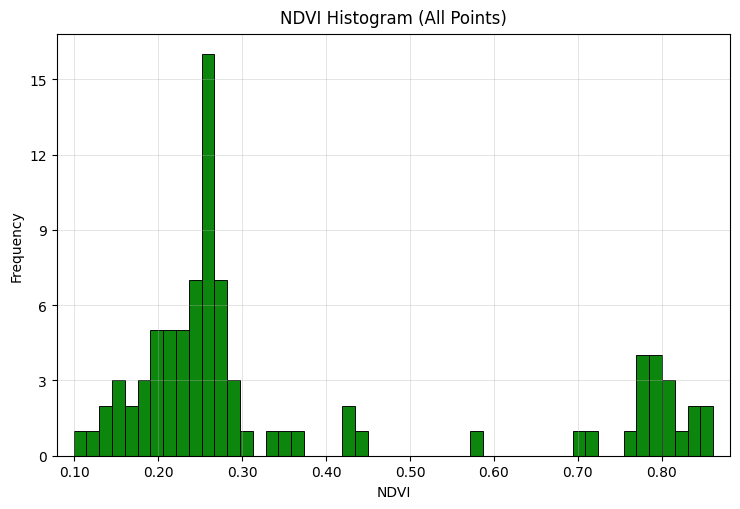

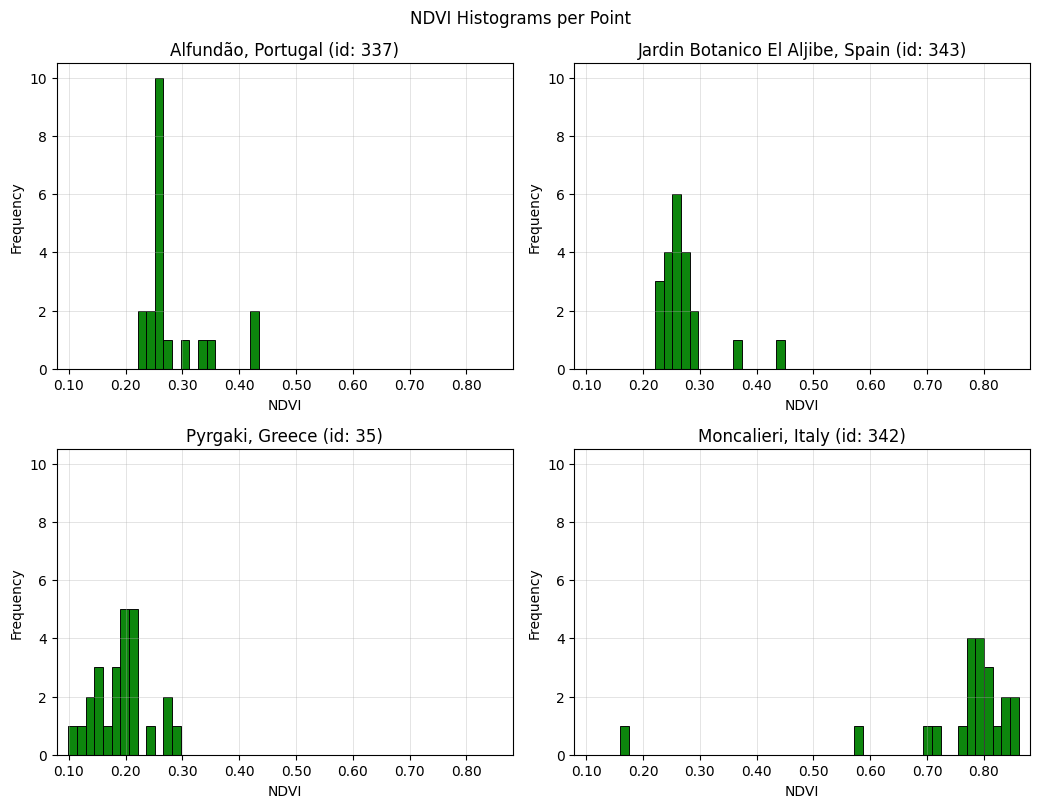

In [ ]:
'''
NDVI QA & Histogram Visualizer
Loads an NDVI time-series CSV, runs light QA (range, counts, quantiles), and
draws: (1) an overall histogram, (2) per-point histograms in 2×2 grids.

Inputs:
- "ndvi_timeseries.csv" with at least columns: NDVI and point identifier (id or point_id).
Outputs:
- Console diagnostics + Matplotlib figures.

Author: Sotirios Loukas Kampylis, Dotsoft
'''

import numpy as np                                        # numerical computing and array operations
import pandas as pd                                       # data analysis and manipulation (DataFrames, CSV/Excel I/O)
import matplotlib.pyplot as plt                           # plotting and visualization library
from matplotlib.ticker import MaxNLocator, FuncFormatter  # custom axis tick control and formatting for plots

# ========= Manual ID → Name mapping =========
# Keep keys as integers (or strings), values as the human-readable names.
ID_TO_NAME = {
    337: "Alfundão, Portugal",
    35:  "Pyrgaki, Greece",
    342: "Moncalieri, Italy",
    343: "Jardin Botanico El Aljibe, Spain",
}

# === Load NDVI data ===
csv_path = "ndvi_timeseries.csv"
df = pd.read_csv(csv_path)

# Ensure NDVI is numeric
# Invalid -> NaN (we will drop NaNs for stats/plots).
df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")

# Decide which column holds the point identifier.
# Priority: 'id' → 'point_id' → (else fail, we no longer synthesize from lon/lat)
if "id" in df.columns:
    id_col = "id"
elif "point_id" in df.columns:
    id_col = "point_id"
else:
    raise ValueError("ndvi_timeseries.csv must contain an identifier column 'id' or 'point_id'.")

# Normalize IDs so 337.0 == 337 (string trim + drop trailing '.0').
def normalize_id_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
    return s

df["_id_norm_str"] = normalize_id_series(df[id_col])

# Also keep an integer version where possible (for dict lookup with int keys).
def to_int_if_possible(x: str):
    try:
        return int(x)
    except Exception:
        return x  # fallback to string if not an integer
df["_id_norm_key"] = df["_id_norm_str"].map(to_int_if_possible)

# Clean NDVI series
ndvi = df["NDVI"].dropna()
if ndvi.empty:
    raise ValueError("No valid NDVI values found after cleaning NDVI.")

# === Quick QA diagnostics ===
ndvi_min, ndvi_max = ndvi.min(), ndvi.max()
print(f"NDVI Range (valid values): {ndvi_min:.3f} to {ndvi_max:.3f}")

below_minus1 = (ndvi < -1).sum()
above_plus1  = (ndvi > 1).sum()
negatives    = (ndvi < 0).sum()
zero_values  = (ndvi == 0).sum()
in_0_1       = ((ndvi >= 0) & (ndvi <= 1)).sum()

print("\n— Basic Counts (and wrong values) —")
print(f"In [0, 1]: {in_0_1}")
print(f"Values < -1: {below_minus1}")
print(f"Values >  1: {above_plus1}")
print(f"Values <  0: {negatives}")
print(f"Values == 0: {zero_values}")

q = ndvi.quantile([0.01, 0.25, 0.5, 0.75, 0.99])
print("\n— Distribution Summary (quantiles) —")
print(q.to_string())

if below_minus1 > 0 or above_plus1 > 0:
    print("\n- Warning: Some values fall outside [-1, 1] — likely NDVI scaling/computation error.")
elif negatives == 0 and ndvi_max <= 1:
    print("\n- Note: No negative values detected and max ≤ 1!")
else:
    print("\n- NDVI values appear within the expected physical range [-1, 1].")

# === Histogram settings (shared across plots for fair comparison) ===
x_lo = max(-1.0, ndvi_min - 0.02)
x_hi = min( 1.0, ndvi_max + 0.02)
HIST_BINS = 50
bin_edges = np.linspace(ndvi_min, ndvi_max, HIST_BINS + 1)

# === Overall histogram ===
fig = plt.figure(figsize=(7.5, 5.2))
ax = plt.gca()
ax.hist(ndvi, bins=bin_edges, edgecolor="black", linewidth=0.7, alpha=0.95, color="green")
ax.set_title("NDVI Histogram (All Points)", pad=8)
ax.set_xlabel("NDVI"); ax.set_ylabel("Frequency")
ax.set_xlim(x_lo, x_hi)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
ax.grid(True, linewidth=0.6, alpha=0.4)
ax.tick_params(axis="both", which="both", labelbottom=True, labeltop=False,
               labelleft=True, labelright=False)
plt.tight_layout()

# === Save as PNG ===
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/NDVI_Histogram_all_Points.png", dpi=150)
plt.show()

# === Per-point histograms (2×2 grids) ===
# We iterate over the unique normalized IDs present in the NDVI file.
unique_ids = df.loc[df["NDVI"].notna(), "_id_norm_key"].unique()

for i in range(0, len(unique_ids), 4):
    batch = unique_ids[i:i+4]
    fig, axes = plt.subplots(2, 2, figsize=(10.5, 8.2), sharex=True, sharey=True)
    axes = axes.ravel()

    for ax, pid_key in zip(axes, batch):
        # Subset NDVI for this ID
        ndvi_p = df.loc[(df["_id_norm_key"] == pid_key) & (df["NDVI"].notna()), "NDVI"]

        # Build display title from manual mapping;
        # if not found, show only "id: <ID>".
        pretty = ID_TO_NAME.get(pid_key, "")
        id_str = str(pid_key)
        title = f"{pretty} (id: {id_str})" if pretty else f"id: {id_str}"
        ax.set_title(title, pad=6)

        ax.hist(ndvi_p, bins=bin_edges, edgecolor="black", linewidth=0.7, alpha=0.95, color="green")
        ax.set_xlabel("NDVI"); ax.set_ylabel("Frequency")
        ax.set_xlim(x_lo, x_hi)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
        ax.grid(True, linewidth=0.6, alpha=0.4)
        ax.tick_params(axis="both", which="both", labelbottom=True, labeltop=False,
                       labelleft=True, labelright=False)

    # Hide unused subplots if last batch has <4 points
    for ax in axes[len(batch):]:
        ax.axis("off")

    fig.suptitle(f"NDVI Histograms per Point")
    plt.tight_layout()

    # === Save as PNG ===
    plt.savefig(f"plots/NDVI_Histograms_per_Point.png", dpi=150)
    plt.show()


### [1.7] NDVI Time-Series Analysis

This step visualizes **how NDVI evolves over time** for each monitored site, producing clear, comparable **2×2 grid line plots** and an optional **global daily-mean NDVI overview**.  
It operates on the exported `ndvi_timeseries.csv` file and uses a **manual ID → Name mapping** to ensure each subplot title clearly identifies its site and ID (e.g., `Pyrgaki, Greece (id: 35)`).

---

### 1) Inputs & Cleaning — *What the script reads*

- **CSV file:** `ndvi_timeseries.csv` containing at least:
  - `NDVI`: values converted to numeric; invalid or non-parsable entries are set to `NaN` and ignored in plots.
  - `id` or `point_id`: unique site identifiers (normalized so that `337.0 → 337`).
  - A date-like column among: `Dates`, `Date`, or `time`.
- **Manual mapping** (`ID_TO_NAME`) assigns human-readable names (e.g., `337 → "Alfundão, Portugal"`).

**Rationale:** Explicit ID mapping guarantees consistent and interpretable subplot titles, independent of metadata sources.

---

### 2) Date Parsing — *Robust handling of heterogeneous formats*

The script automatically detects and parses the most common date structures:

- **`Dates`** (preferred): integers such as `YYYYMMDD` (e.g., `20250608`) parsed with a fixed pattern.
- **`Date`**: ISO-like or free-form timestamps (e.g., `2025-06-08`, `2025/06/08 12:00`).
- **`time`**: UNIX time in milliseconds (e.g., `1.7e12`).

All timestamps are normalized to **daily resolution**, ensuring consistent temporal aggregation.

**Rationale:** NDVI exports may differ between providers (Google Earth Engine, Sentinel Hub, etc.); flexible parsing ensures robust compatibility.

---

### 3) Daily Aggregation — *De-duplication and smoothing*

- Multiple NDVI observations on the same date are **averaged per site**.
- Missing or invalid NDVI values are automatically excluded.

**Rationale:** Produces a single representative NDVI per day per site, minimizing noise from overlapping acquisitions.

---

### 4) Visualization — *What gets plotted*

- **Optional global overview**  
  Displays the **mean NDVI across all sites** per date, summarizing vegetation dynamics network-wide.  
  Enable or disable via `SHOW_GLOBAL_OVERVIEW = True/False`.

- **Per-site NDVI time series**
  - Displayed in **2×2 subplot grids** (one figure per four sites).
  - Titles include both name and ID (e.g., `Moncalieri, Italy (id: 342)`).
  - Shared **Y-limits** ensure cross-site comparability.
  - Each subplot keeps **visible axes and gridlines** for readability.

- **Dynamic date ticks**
  - X-axis labels use **AutoDateLocator** + **ConciseDateFormatter** for adaptive spacing.  
  - Date labels stay **horizontal** and uncluttered, regardless of series length.

**Rationale:** Adaptive ticks prevent overlapping date labels, while consistent axis limits highlight genuine vegetation dynamics.

---

### 5) Outputs & Interpretation

* **Console diagnostics**

  * Prints the full **date range** of available NDVI observations
    (e.g., `[INFO] Date range: 2023-04-12 → 2025-06-30`).

* **Generated figures**

  1. *(Optional)* `plots/NDVI_Time_Series_all_Points.png` — shows the **daily mean NDVI across all sites**, summarizing vegetation dynamics across the full network.
  2. `plots/NDVI_Time_Series_per_Point.png` — a **2×2 grid of per-site NDVI time series**; the figure is refreshed for each batch of four sites, with only the **last** one written to disk.

**Interpretation tips**

* Gradual NDVI rise or fall → **seasonal vegetation cycles**.
* Abrupt spikes or drops → **cloud contamination**, **sensor noise**, or **land-cover changes**.
* Out-of-range NDVI (< –1 or > 1) → **scaling or preprocessing errors** in earlier steps.

---

### 6) Why this step matters

Time-series visualization turns static NDVI tables into **dynamic ecological trajectories**:

- Reveals **temporal vegetation patterns**, seasonal responses, and anomalies.  
- Detects **data inconsistencies** early through visual inspection.  
- Preserves **cross-site comparability** by enforcing consistent limits and adaptive tick density.

**In essence:**  
This analysis converts raw daily NDVI samples into **interpretable, site-specific vegetation timelines**, forming a key foundation for **ecosystem monitoring**, **trend detection**, and **environmental reporting**.

[INFO] Date range: 2025-06-02 → 2025-08-31


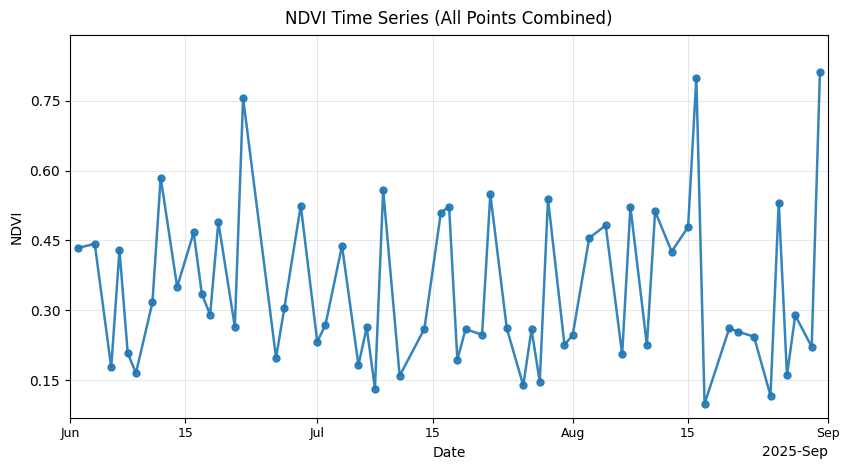

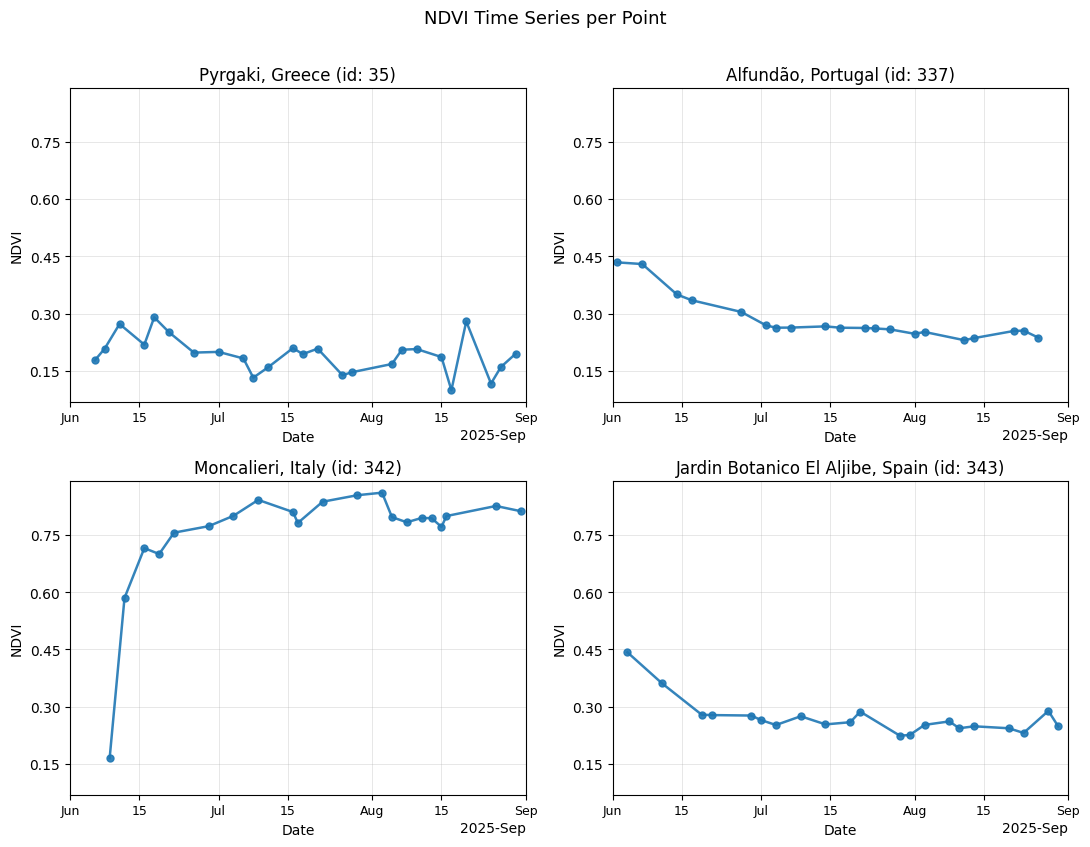

In [ ]:
"""
NDVI Time-Series Visualizer
-------------------------------------------------------------
What this script does
- Loads an NDVI time-series CSV that contains per-point observations.
- Builds an optional overview chart of the global daily mean NDVI.
- Builds 2×2 subplot grids for each group of up to four points.
- Uses consistent Y-limits across all plots for visual comparability.
- Critically: uses a dynamic date locator/formatter so X-axis dates are
  ALWAYS readable and sparsely placed.

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Imports ===
import os                                                           # Filesystem utilities (create output folder, etc.)
import numpy as np                                                  # Numerical operations (not strictly required but kept for future use)
import pandas as pd                                                 # CSV I/O, data wrangling, grouping, date handling
import matplotlib.pyplot as plt                                     # Plotting API
from matplotlib.ticker import MaxNLocator, FuncFormatter            # Y-axis tick control and formatting
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter  # Adaptive date ticks & compact labels

# === Manual mapping from ID → human-readable names ===
ID_TO_NAME = {
    337: "Alfundão, Portugal",
    35:  "Pyrgaki, Greece",
    342: "Moncalieri, Italy",
    343: "Jardin Botanico El Aljibe, Spain",
}

# === Settings ===
SHOW_GLOBAL_OVERVIEW = True   # Toggle to False to skip the overview plot
CSV_PATH = "ndvi_timeseries.csv"
OUT_DIR  = "plots"
DPI      = 150

# === Helper: normalize point IDs ===
def normalize_id(s: pd.Series) -> pd.Series:
    """
    Convert IDs like '337.0' → 337 and leave non-digit strings untouched.

    Why:
    - CSV exports from spreadsheets frequently coerce integer-like IDs to float.
    - For grouping/labeling we want stable integers.

    Returns:
        A pandas Series with integers where possible, otherwise original strings.
    """
    s = s.astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
    return s.map(lambda x: int(x) if x.isdigit() else x)

# === Helper: robust date parsing for multiple input schemas ===
def parse_dates_flex(dframe: pd.DataFrame) -> pd.Series:
    """
    Parse multiple possible date column conventions:
    - 'Dates' as compact YYYYMMDD (e.g., 20250621)
    - 'time' as UNIX epoch in milliseconds
    - 'Date' as ISO or other formats parsable by pandas

    Returns:
        A pandas datetime64[ns] Series.
    Raises:
        ValueError if no known date column is present.
    """
    if "Dates" in dframe.columns:
        return pd.to_datetime(dframe["Dates"].astype(str), format="%Y%m%d", errors="coerce")
    elif "time" in dframe.columns:
        return pd.to_datetime(dframe["time"], unit="ms", errors="coerce")
    elif "Date" in dframe.columns:
        return pd.to_datetime(dframe["Date"], errors="coerce")
    else:
        raise ValueError("No recognized date column found ('Dates', 'Date', or 'time').")

# === Helper: consistent and readable date axis on ANY time-series Axes ===
def setup_date_axis(ax, x_lo, x_hi, minticks: int = 4, maxticks: int = 7):
    """
    Apply an adaptive locator/formatter to the x-axis so that date ticks
    are automatically spaced (days → weeks → months → years) depending
    on the visible range. This guarantees sparse, readable labels.

    Args:
        ax:        The matplotlib Axes to configure.
        x_lo/x_hi: Datetime-like range limits (pandas Timestamps).
        minticks:  Minimum number of major ticks to aim for.
        maxticks:  Maximum number of major ticks to aim for.

    Effect:
        - Sets xlim slightly padded at both ends.
        - Uses AutoDateLocator to pick an appropriate tick interval.
        - Uses ConciseDateFormatter for compact, non-redundant labels.
        - Keeps labels unrotated (ConciseDateFormatter is compact by design).
    """
    # Small 1-day padding looks nicer and ensures first/last points are not on the frame
    ax.set_xlim(x_lo - pd.Timedelta(days=1), x_hi + pd.Timedelta(days=1))

    locator = AutoDateLocator(minticks=minticks, maxticks=maxticks)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))

    # Keep labels horizontal; concise formatter avoids overlap in most ranges
    ax.tick_params(axis="x", labelrotation=0, labelsize=9)

# === Main script ===
def main():
    # --- Load CSV ---
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV not found: {CSV_PATH}")

    df = pd.read_csv(CSV_PATH)

    # Convert NDVI to numeric, coercing bad values to NaN then dropping them later
    df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")

    # Detect the identifier column name
    if "id" in df.columns:
        id_col = "id"
    elif "point_id" in df.columns:
        id_col = "point_id"
    else:
        raise ValueError("CSV must contain an identifier column 'id' or 'point_id'.")

    # Normalize IDs and parse dates
    df["_id"] = normalize_id(df[id_col])
    df["__dt"] = parse_dates_flex(df)

    # Keep only valid rows
    df = df.loc[df["NDVI"].notna() & df["__dt"].notna()].copy()
    if df.empty:
        raise ValueError("No valid NDVI/date entries after cleaning.")

    # Aggregate per-point DAILY NDVI to avoid duplicates; this also sorts
    df["__date"] = df["__dt"].dt.normalize()
    daily = (
        df.groupby(["_id", "__date"], as_index=False)["NDVI"]
          .mean()
          .sort_values(["_id", "__date"])
    )

    # Diagnostics
    print(f"[INFO] Date range: {daily['__date'].min().date()} → {daily['__date'].max().date()}")

    # Shared axis limits for Y (keeps all subplots visually comparable)
    y_lo = max(-1.0, daily["NDVI"].min() - 0.03)
    y_hi = min( 1.0, daily["NDVI"].max() + 0.03)
    x_lo, x_hi = daily["__date"].min(), daily["__date"].max()

    # Output folder
    os.makedirs(OUT_DIR, exist_ok=True)

    # --- (Optional) Global overview: daily mean NDVI across ALL points ---
    if SHOW_GLOBAL_OVERVIEW:
        global_mean = (
            daily.groupby("__date", as_index=False)["NDVI"]
                 .mean()
                 .sort_values("__date")
        )

        fig, ax = plt.subplots(figsize=(8.6, 4.8))
        ax.plot(
            global_mean["__date"], global_mean["NDVI"],
            marker="o", markersize=5, linewidth=1.8, color="tab:blue", alpha=0.9
        )

        ax.set_title("NDVI Time Series (All Points Combined)", pad=8)
        ax.set_xlabel("Date")
        ax.set_ylabel("NDVI")
        ax.set_ylim(y_lo, y_hi)

        # Grid + Y axis formatting
        ax.grid(True, alpha=0.35, linewidth=0.6)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))

        # --- KEY CHANGE: sparse, adaptive date ticks ---
        setup_date_axis(ax, x_lo, x_hi)

        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "NDVI_Time_Series_all_Points.png"), dpi=DPI)
        plt.show()

    # --- Per-point NDVI subplots in 2×2 grids ---
    unique_ids = daily["_id"].unique()

    for i in range(0, len(unique_ids), 4):
        batch = unique_ids[i:i + 4]

        # sharex/sharey are False so each subplot shows its own x tick labels;
        # date locator auto-adjusts per-axes anyway.
        fig, axes = plt.subplots(2, 2, figsize=(11.0, 8.6), sharex=False, sharey=False)
        axes = axes.ravel()

        for ax, pid in zip(axes, batch):
            subset = (
                daily.loc[daily["_id"] == pid, ["__date", "NDVI"]]
                     .sort_values("__date")
            )

            # Title: prefer friendly name if present
            name = ID_TO_NAME.get(pid)
            title = f"{name} (id: {pid})" if name else f"id: {pid}"
            ax.set_title(title, pad=6)

            # The time-series line
            ax.plot(
                subset["__date"], subset["NDVI"],
                marker="o", markersize=5, linewidth=1.8, color="tab:blue", alpha=0.9
            )

            # Consistent Y limits across all subplots
            ax.set_ylim(y_lo, y_hi)

            # Axis labels on ALL subplots (explicit and clear)
            ax.set_xlabel("Date")
            ax.set_ylabel("NDVI")

            # Grid + Y axis formatting
            ax.grid(True, alpha=0.35, linewidth=0.6)
            ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
            ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))

            # --- KEY CHANGE: sparse, adaptive date ticks on EVERY subplot ---
            setup_date_axis(ax, x_lo, x_hi)

        # Turn off any unused panels when the last batch has <4 items
        for ax in axes[len(batch):]:
            ax.axis("off")

        fig.suptitle("NDVI Time Series per Point", fontsize=13)

        # Leave space for the suptitle; otherwise let tight_layout pack nicely
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        out_path = os.path.join(OUT_DIR, f"NDVI_Time_Series_per_Point.png")
        plt.savefig(out_path, dpi=DPI)
        plt.show()


if __name__ == "__main__":
    main()


### [1.8] NDVI Vegetation-Only Histograms (Global + Per-Point)

**Note**: <u>Original idea from *Valeria Gentile*</u>

This step visualizes **NDVI distributions** filtered to **vegetation-only pixels**, using the dynamic threshold proposed by Valeria Gentile.  
It produces both a **global vegetation histogram** (aggregated across all sites) and **per-point histograms** (2×2 grids) in a format consistent with the NDVI Time-Series visualizer.  
The script runs locally on the exported `ndvi_timeseries.csv` and uses a **manual ID → Name mapping** for readable subplot titles.

---

### 1) Inputs & Cleaning — *What the script reads*

- **CSV file** `ndvi_timeseries.csv` containing:
  - `NDVI`: coerced to numeric; invalid entries become `NaN` and are excluded.
  - `id` or `point_id`: unique identifier for each monitoring site.
- **Manual mapping** dictionary (e.g., `337 → "Alfundão, Portugal"`) converts numeric IDs into human-readable labels.

**Rationale:** Explicit name mapping ensures consistent, interpretable titles across all generated figures.

---

### 2) Dynamic Thresholding — *Vegetation-only filtering*

- **Global threshold**
  $$
  T = \frac{\text{NDVI}_{max} - \text{NDVI}_{min}}{2}
  $$
  Pixels with **NDVI > T** are considered vegetation.

- **Per-point threshold**
  $$
  T_i = \frac{\text{NDVI}_{max,i} - \text{NDVI}_{min,i}}{2}
  $$
  applied independently to each site.

**Rationale:** This segmentation step removes non-vegetated surfaces (roads, water, bare soil), following the methodology suggested by Valeria Gentile.

---

### 3) Global Histogram — *Vegetation-only distribution across all sites*

- Compute and print:
  - Global NDVI range  
  - Dynamic threshold T  
  - Vegetation-only min, max, mean, and pixel count
- Plot:
  - **Green bars** = distribution of vegetation-only NDVI values  
  - **Red dashed line** = mean NDVI  
  - Shared x-axis scaled to overall NDVI range (±margin)

**Output:** `plots/NDVI_Histogram_Vegetation_Only_all_Points.png`

---

### 4) Per-Point Histograms — *2×2 grids with consistent layout*

- For each site:
  - Compute local threshold \(T_i\)  
  - Filter vegetation-only pixels (NDVI > T_i)  
  - Compute local min, max, mean and count and print to console
- Plot each site:
  - **Title:** `Name (id: ID)` (from mapping if available)  
  - **Green bars:** vegetation NDVI distribution  
  - **Red dashed line:** mean NDVI  
- Layout:
  - Up to 4 sites per figure (2×2 grid)  
  - Consistent x/y scales across all subplots  
  - Empty panels hidden when fewer than 4 sites remain  
  - Automatic y-limit adapts to highest frequency (+20% headroom)

**Output:** `plots/NDVI_Histograms_Vegetation_Only_per_Point.png`

---

### 5) Outputs & Interpretation

- **Console diagnostics**
  - Global and per-point NDVI ranges, thresholds and vegetation-only statistics.
- **Figures**
  1. Global vegetation-only histogram  
  2. Per-point histograms (2×2 grid pages)

**How to read**
- The distribution width indicates NDVI variability within vegetation.  
- A higher mean suggests denser or healthier vegetation.  
- Narrow distributions = uniform cover; wide = heterogeneous or mixed conditions.  
- Empty or single-bar plots indicate insufficient or highly uniform data.

---

### 6) Why this step matters

Histograms reveal **structural NDVI patterns** that single averages obscure:
- Highlight the **spread** and **shape** of NDVI values.
- Enable **cross-site comparison** on a shared scale.
- Automatically exclude non-vegetation background.

NDVI Range: 0.099 → 0.861
Dynamic NDVI threshold: 0.381

[GLOBAL] Vegetation-only statistics:
Min NDVI: 0.430
Max NDVI: 0.861
Mean NDVI: 0.739
Total vegetation pixels: 23


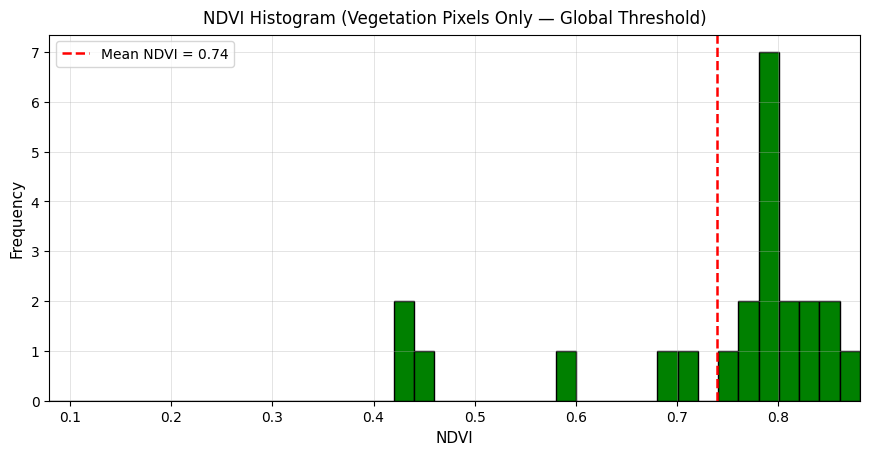


[POINT id=337] Range=0.230–0.434, thr_i=0.102, mean=0.284

[POINT id=343] Range=0.224–0.443, thr_i=0.109, mean=0.271

[POINT id=35] Range=0.099–0.290, thr_i=0.096, mean=0.192

[POINT id=342] Range=0.165–0.861, thr_i=0.348, mean=0.785


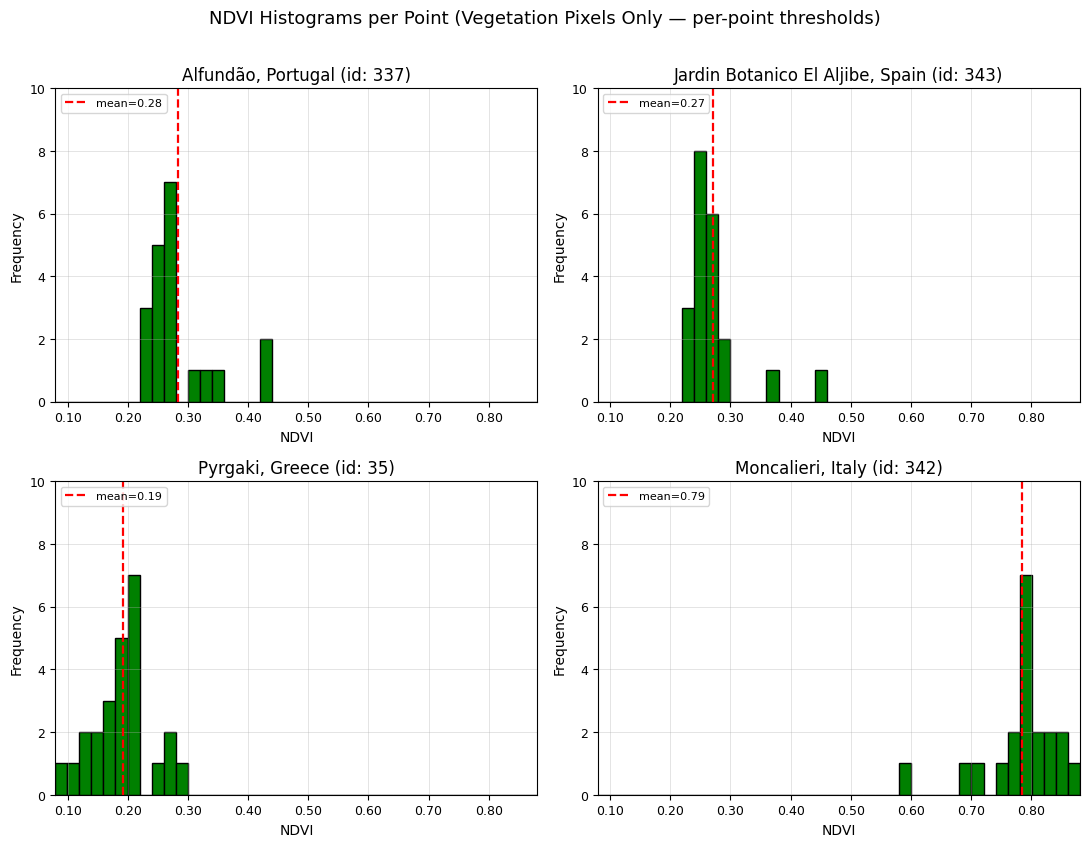

In [ ]:
"""
NDVI Vegetation-Only Histograms (GLOBAL + PER-POINT)
====================================================

This script produces both:
1. A global NDVI histogram using a dynamic threshold
   (same definition as in your NDVI analysis pipeline).
2. A set of per-point histograms (2×2 grid layout),
   matching the exact layout and styling of your NDVI Time-Series plots.

All histograms use consistent axes, font sizes, and spacing,
ensuring that visual comparison between sites is fair and easy.

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Imports ===
import numpy as np                                        # Numerical computing: efficient array operations, min/max, mean, histograms, etc.
import pandas as pd                                       # Data handling: read CSVs, clean/transform columns, group by ID, etc.
import matplotlib.pyplot as plt                           # Plotting library: draw histograms, configure figures, titles, labels, and grids.
from matplotlib.ticker import MaxNLocator, FuncFormatter  # Axis utilities: clean integer tick marks & custom numeric formatting (e.g., NDVI with 2 decimals)
import os                                                 # Filesystem utilities: create 'plots/' folder, handle file saving (e.g., PNG outputs)

# === Manual mapping: ID → human-readable name ===
# Used to display readable subplot titles instead of numeric IDs.
ID_TO_NAME = {
    337: "Alfundão, Portugal",
    35:  "Pyrgaki, Greece",
    342: "Moncalieri, Italy",
    343: "Jardin Botanico El Aljibe, Spain",
}

# === Configurable parameters ===
CSV_PATH = "ndvi_timeseries.csv"     # Input CSV file path
BINS = 40                            # Number of bins for histograms
os.makedirs("plots", exist_ok=True)  # Ensure output folder exists

# === Load and clean NDVI data ===
df = pd.read_csv(CSV_PATH)

# Force NDVI column to numeric (invalid entries → NaN)
df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")

# Drop rows where NDVI could not be parsed
df = df.dropna(subset=["NDVI"]).copy()

if df.empty:
    raise ValueError("No valid NDVI values found after cleaning!")

# Detect correct column name for point ID
if "id" in df.columns:
    id_col = "id"
elif "point_id" in df.columns:
    id_col = "point_id"
else:
    raise ValueError("CSV must contain either 'id' or 'point_id' column.")

# Normalize point IDs (convert floats like 337.0 → 337)
def normalize_id(x):
    try:
        return int(x)
    except Exception:
        return str(x).strip()

df["_pid"] = df[id_col].map(normalize_id)

# GLOBAL HISTOGRAM — Vegetation-only NDVI Distribution
# Compute global NDVI range and dynamic vegetation threshold
ndvi_min, ndvi_max = df["NDVI"].min(), df["NDVI"].max()
threshold = (ndvi_max - ndvi_min) / 2.0

# Keep only vegetation-like pixels (NDVI > threshold)
veg_global = df.loc[df["NDVI"] >= threshold, "NDVI"]

# Compute descriptive statistics for global vegetation subset
g_min, g_max, g_mean = veg_global.min(), veg_global.max(), veg_global.mean()

# Print diagnostics to console
print(f"NDVI Range: {ndvi_min:.3f} → {ndvi_max:.3f}")
print(f"Dynamic NDVI threshold: {threshold:.3f}")
print("\n[GLOBAL] Vegetation-only statistics:")
print(f"Min NDVI: {g_min:.3f}")
print(f"Max NDVI: {g_max:.3f}")
print(f"Mean NDVI: {g_mean:.3f}")
print(f"Total vegetation pixels: {len(veg_global)}")

# Compute consistent X-axis limits for all histograms
x_lo = max(-1.0, ndvi_min - 0.02)
x_hi = min(1.0, ndvi_max + 0.02)
bin_edges = np.linspace(x_lo, x_hi, BINS + 1)

# --- Plot GLOBAL histogram ---
fig, ax = plt.subplots(figsize=(8.8, 4.8))
ax.hist(veg_global, bins=bin_edges, color="green", edgecolor="black")

# Overlay vertical dashed line at mean NDVI
if not veg_global.empty:
    ax.axvline(g_mean, color="red", linestyle="--", linewidth=1.8, label=f"Mean NDVI = {g_mean:.2f}")

# Axis and layout settings
ax.set_title("NDVI Histogram (Vegetation Pixels Only — Global Threshold)", pad=8)
ax.set_xlabel("NDVI", fontsize=11)
ax.set_ylabel("Frequency", fontsize=11)
ax.set_xlim(x_lo, x_hi)
ax.grid(True, alpha=0.4, linewidth=0.6)
ax.tick_params(axis="both", labelsize=10)
ax.legend()

# Save and display the global histogram
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig("plots/NDVI_Histogram_Vegetation_Only_all_Points.png", dpi=150)
plt.show()

# PER-POINT HISTOGRAMS — 2×2 Layout, Time-Series Style
# Determine shared Y-axis limit (so all subplots use same scale)
y_max = 0
for pid in df["_pid"].unique():
    vals = df.loc[df["_pid"] == pid, "NDVI"].to_numpy()
    if len(vals) == 0:
        continue
    pmin, pmax = vals.min(), vals.max()
    thr_i = (pmax - pmin) / 2.0
    veg_i = vals[vals >= thr_i]
    counts, _ = np.histogram(veg_i, bins=bin_edges)
    if counts.size > 0:
        y_max = max(y_max, counts.max())

# Add small padding to top of histogram bars
y_hi = int(np.ceil(y_max * 1.2)) if y_max > 0 else 1

# Generate per-point plots in 2×2 grids (same layout as time-series)
pids = df["_pid"].unique()

for i in range(0, len(pids), 4):
    group = pids[i:i + 4]

    # Create figure with 2×2 subplots, same dimensions as NDVI time-series layout
    fig, axes = plt.subplots(2, 2, figsize=(11.0, 8.6), sharex=False, sharey=False)
    axes = axes.ravel()

    # Iterate over each point in this batch of up to 4
    for ax, pid in zip(axes, group):
        vals = df.loc[df["_pid"] == pid, "NDVI"].to_numpy()
        if len(vals) == 0:
            ax.axis("off")
            continue

        # Compute per-point threshold and vegetation-only subset
        pmin, pmax = vals.min(), vals.max()
        thr_i = (pmax - pmin) / 2.0
        veg_i = vals[vals >= thr_i]
        vmean = veg_i.mean() if len(veg_i) > 0 else np.nan

        # Print point-specific statistics
        print(f"\n[POINT id={pid}] Range={pmin:.3f}–{pmax:.3f}, thr_i={thr_i:.3f}, mean={vmean:.3f}")

        # Title combines friendly name and ID
        title = f"{ID_TO_NAME.get(pid, 'id: '+str(pid))} (id: {pid})"
        ax.set_title(title, pad=6)

        # Plot histogram
        ax.hist(veg_i, bins=bin_edges, color="green", edgecolor="black")

        # Mean NDVI line (if valid)
        if not np.isnan(vmean):
            ax.axvline(vmean, color="red", linestyle="--", linewidth=1.6, label=f"mean={vmean:.2f}")

        # Axis formatting (identical to NDVI time-series layout)
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(0, y_hi)
        ax.set_xlabel("NDVI", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)
        ax.tick_params(axis="both", labelsize=9)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax.grid(True, alpha=0.4, linewidth=0.6)
        ax.legend(fontsize=8, loc="upper left")

    # Hide empty subplots if less than 4
    for ax in axes[len(group):]:
        ax.axis("off")

    # Shared title and layout — identical geometry to NDVI time-series
    fig.suptitle("NDVI Histograms per Point (Vegetation Pixels Only — per-point thresholds)", fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Save figure for this group of 4 points
    ids_str = "-".join(str(pid) for pid in group)
    plt.savefig(f"plots/NDVI_Histograms_Vegetation_Only_per_Point.png", dpi=150)
    plt.show()


### [1.9] Download NDVI Results from Colab (Zip & Save)

This step compresses **Sentinel 2 outputs** into a single `.zip` file and triggers an automatic **download** from Colab.

### 1) What it includes / excludes

**Included**

* Folders: `merged_metadata/`, `ndvi_output/`, `plots/`, `raw_metadata/`
* Files: `ndvi_timeseries.csv`, `points.csv`
  *(core NDVI time-series data and point metadata)*

**Excluded**

* `sample_data/` (entire folder)
* **Hidden** files and directories (e.g., `.ipynb_checkpoints/`, `.git/`)
* The generated zip file itself (to prevent recursion)

**Why:** Ensures a clean, lightweight archive containing only relevant NDVI deliverables.

---

### 2) How it works — *Zip & Download*

* **ZIP creation:**
  Uses the system `zip` utility in quiet (`-q`) recursive (`-r`) mode to bundle only the defined folders and files.
* **Exclusions:**
  Hidden items and `sample_data/` are skipped for clarity.
* **Download trigger:**
  Uses Colab’s built-in `files.download()` to open a browser prompt for immediate file saving.

---

### 3) Output

* **File:** `ndvi_results_sentinel_2_only.zip`
* **Contents:** only the key NDVI result folders and CSVs (structure preserved exactly as in the Colab file tree).
* **Purpose:** lightweight, shareable archive for post-processing, validation, or reporting.

In [ ]:
"""
NDVI Results Archiver (Selective ZIP Export for Colab)
======================================================

This utility script packages only the essential NDVI analysis results
into a single ZIP file, ready for download from Google Colab.

It includes:
- Core output folders (merged_metadata, ndvi_output, plots, raw_metadata)
- Primary result tables (ndvi_timeseries.csv, points.csv)
and excludes all auxiliary or sample directories (e.g. sample_data/).

Hidden files are automatically skipped to keep the archive clean and minimal.

Author: Sotirios Loukas Kampylis, Dotsoft
"""

import subprocess, os           # subprocess: runs shell commands (e.g., zip), os: checks paths & file existence
from google.colab import files  # provides upload/download utilities in Google Colab environment

# Items to include (exactly as shown in the screenshot)
targets = ['merged_metadata', 'ndvi_output', 'plots', 'raw_metadata',
           'ndvi_timeseries.csv', 'points.csv']

# Keep only existing
targets = [t for t in targets if os.path.exists(t)]
if not targets:
    raise SystemExit("No matching files/folders found.")

# Zip command (quiet mode, exclude hidden + sample_data)
zip_name = 'ndvi_results_sentinel_2_only.zip'
cmd = ['zip', '-r', '-q', zip_name] + targets + ['-x', '*/.*', '.*', 'sample_data/*', 'sample_data/**']

# Run and download
subprocess.run(cmd, check=True)
files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## [2] NOAA NDVI Processing & Validation Pipeline

**Short description:**
This section runs the complete **NOAA VIIRS NDVI data pipeline**, handling data retrieval, processing, quality control, and validation. It automates the collection of NDVI imagery from **Google Earth Engine (GEE)**, converts it into structured CSV outputs, and evaluates the completeness and integrity of the merged metadata.

More specifically, this section:

* Retrieves **NOAA VIIRS NDVI** datasets for your selected locations and time range.
* Computes **daily and time-series NDVI statistics** (e.g., mean, quantiles, histograms).
* Generates ready-to-analyze CSV files for downstream analysis and visualization.
* Validates merged NOAA metadata against GEE for **coverage**, **missing keys**, and **duplicates**.
* Exports the final outputs (data, plots, reports) for local download and archival.

This ensures that NOAA NDVI data is processed **reproducibly, consistently, and transparently**, maintaining alignment with Sentinel-2 workflows for cross-satellite comparison within Colab.


### [2.1] NOAA CDR AVHRR/VIIRS NDVI — S2-like Pipeline

This step implements a reproducible **Google Earth Engine (GEE)** pipeline in Python for long-term vegetation monitoring.  
The goal is to extract **NDVI (Normalized Difference Vegetation Index)** data from NOAA’s **Climate Data Record (CDR)** collections by merging AVHRR (historical) and VIIRS (modern) sensors into a unified, continuous dataset.

The script performs two primary operations:

1. **Point-based NDVI time series extraction** (via `getRegion` at specific coordinates).  
2. **Spatial NDVI GeoTIFF and metadata export** (single-band NDVI with full image information in JSON).

It relies on the following libraries: `ee` (GEE Python API), `pandas`, `numpy`, `requests`, `os`, and `json`.  
The GEE session is initialized using project **“germoflife”** after authentication.

---

### 1) Datasets and Global Filters — *What and Why*

**Datasets (NOAA CDR NDVI):**
- **AVHRR** – `NOAA/CDR/AVHRR/NDVI/V5` (coverage: *1981-06-24 → 2013-12-31*)  
- **VIIRS** – `NOAA/CDR/VIIRS/NDVI/V1` (coverage: *2014-01-01 → present*)

**Temporal filtering:**  
Each collection is filtered with `.filterDate(start_date, end_date)` and then merged, so a single query can seamlessly span the AVHRR→VIIRS transition period (1981–present).

**Spatial filtering:**  
- For **point time series**, the collection is filtered by `filterBounds(Point(lon, lat))`.  
- For **spatial exports**, a small rectangular buffer (≈5 km) around each point is used with `filterBounds(Rectangle)`.

**Rationale:**  
Combining both datasets ensures cross-era NDVI continuity, while the spatial and temporal filters reduce data volume and improve performance.

---

### 2) QA Masking and NDVI Scaling — *What and Why*

**Functions:** `mask_noaa_quality(image)` and `scale_noaa_ndvi(image)`

* **Quality Masking (`QA` band):**  
  - **Bit 1** → cloud flag  
  - **Bit 2** → shadow flag  
  Only pixels where both bits equal 0 (clear sky) are retained.

* **NDVI Scaling:**  
  The CDR NDVI values are stored as `int16` integers scaled by 10,000.  
  Each value is multiplied by 0.0001 to restore the physical NDVI range **[-1, 1]**.

The processed collection is then reduced to the `NDVI` band for simplicity.

**Rationale:**  
QA filtering removes cloud- and shadow-contaminated pixels, while scaling yields physically meaningful NDVI values suitable for quantitative analysis.

---

### 3) Point-Based NDVI Time Series — *How It Works*

**Function:** `extract_noaa_point(lon, lat, start_date, end_date)`

* Builds the merged AVHRR + VIIRS NDVI collection for the specified coordinate and date range.  
* Applies cloud/shadow masking and NDVI scaling.  
* Extracts values using `.getRegion(point, 5566)` (≈ 5.6 km native grid).

**Post-processing:** `process_noaa_data(df, start_date, end_date)`

* Reads the input DataFrame (`points.csv`) containing columns `longitude`, `latitude`, and `id`.  
* For each point, retrieves valid NDVI samples and constructs structured records:
  - Acquisition date (`Dates`, derived from `system:index`)
  - Longitude, latitude, and user point ID
  - Scaled NDVI value
  - Corresponding `ImageID`
* Invalid or masked NDVI values (`NaN`) are discarded.  
* File paths for each record are constructed:
  - `image_path`: `/content/ndvi_noaa_output/NDVI_<ImageID>_ID<id>.tif`  
  - `json_path`: `/content/ndvi_noaa_output/processed_metadata_<ImageID>_ID<id>.json`
* The resulting DataFrame is sorted chronologically by `Dates` and `id`, then exported to **`ndvi_noaa_timeseries.csv`**.

**Rationale:**  
This approach preserves all valid NDVI observations for each point, ensuring full temporal coverage without averaging or grouping.

---

### 4) Spatial NDVI Export and Metadata — *How It Works*

**Function:**  
`download_spatial_noaa_ndvi(lon, lat, point_id, start_date, end_date, directory_path, buffer_meters=5000)`

* Constructs a small bounding box around each coordinate (≈ 5 km, converted from meters to degrees).  
* Loads the QA-masked and scaled NDVI collection filtered by this region.  
* For each valid image intersecting the region:
  1. **Metadata JSON** is generated using `save_image_metadata(...)`, which records:
     - `system:index`, acquisition properties, band schema, and image footprint.
  2. **GeoTIFF download:**  
     The NDVI layer is exported via `getDownloadURL({scale: 5566, crs: 'EPSG:4326', region: bbox})`  
     and saved locally as `NDVI_<ImageID>_ID<id>.tif`.

**Rationale:**  
A small bounding box provides spatial context while keeping files compact.  
Each NDVI GeoTIFF corresponds to a single valid acquisition and includes a companion JSON metadata file for full reproducibility.

---

### 5) Script Entry Point — *Execution Flow*

When executed as `__main__`, the script performs the following steps:

1. Loads `points.csv` containing the columns **`longitude`**, **`latitude`**, and **`id`**.  
2. Calls `process_noaa_data()` to build the NDVI time series and exports it as **`ndvi_noaa_timeseries.csv`**.  
3. For each input point, calls `download_spatial_noaa_ndvi()` to export:
   - The **NDVI GeoTIFFs** (`NDVI_<ImageID>_ID<id>.tif`)  
   - The corresponding **metadata JSON files** (`processed_metadata_<ImageID>_ID<id>.json`)  
   into the `./ndvi_noaa_output/` directory.

---

### 6) Assumptions and Notes

* **Authentication:** If `ee.Initialize(project='germoflife')` fails, the user must run `ee.Authenticate()` once and re-initialize.  
* **Scale and CRS:** Both point extraction (`getRegion`) and GeoTIFF exports use a scale of 5566 m at **EPSG:4326**.  
* **Buffer approximation:** The conversion `buffer_meters / 111320` is accurate for small AOIs (≈ < 10 km).  
* **Client-side operations:** `.getRegion(...).getInfo()` retrieves data client-side; avoid excessive point counts to prevent timeouts.  
* **Cross-sensor continuity:** The merged AVHRR + VIIRS collection ensures seamless temporal coverage across the 2013–2014 transition.

---

### 7) Outputs

* **`ndvi_noaa_timeseries.csv`** — structured time series table containing:  
  `Dates, longitude, latitude, id, NDVI, ImageID, image_path, json_path`  
  - `NDVI`: scaled, valid pixel values (–1 → 1) after QA masking.  
  - `ImageID`: unique identifier of the source image.  
  - `image_path` / `json_path`: absolute paths linking to corresponding exported files.

* **`./ndvi_noaa_output/NDVI_<ImageID>_ID<id>.tif`** — single-band NDVI GeoTIFF, QA-masked and scaled to **[-1, 1]**.  
* **`./ndvi_noaa_output/processed_metadata_<ImageID>_ID<id>.json`** — detailed metadata JSON including image properties, bands, and footprint geometry.

In [ ]:
"""
Script for retrieving NDVI from NOAA CDR (AVHRR + VIIRS) satellite imagery (long-term data)
===========================================================================================

Purpose
-------
This script retrieves daily NDVI (Normalized Difference Vegetation Index) values for a list
of geographic points from the NOAA Climate Data Record (CDR) collections using the Google
Earth Engine (GEE) API. It merges the AVHRR (historical) and VIIRS (modern) datasets to
produce a continuous NDVI time series from 1981 to the present.

It performs:
    - Extraction of valid NDVI values at specific points for a date range
    - Export of valid daily NDVI values as CSV
    - Download of spatial NDVI GeoTIFFs (5 km tiles) with metadata JSON per image

Key Features
------------
- Automatically merges AVHRR and VIIRS periods to ensure continuity
- Masks clouds and shadows using NOAA’s quality band (QA)
- Scales integer NDVI values to float representation (-1 → 1)
- Only exports pixels where NDVI is valid (non-masked)
- Outputs structured metadata for each valid NDVI scene

Original Author: Odunayo David Adeniyi, CMCC Foundation - Euro-Mediterranean Center on Climate Change, Italy
Modifications by: Sotirios Loukas Kampylis, Dotsoft
"""

# === Library Imports ===================================================
import ee            # Google Earth Engine API
import pandas as pd  # Structured data (CSV I/O)
import numpy as np   # Numerical ops (NaN checking)
import requests      # File download via URL
import json          # JSON read/write
import os            # File and directory utilities

# === Output Configuration ==============================================
IMAGES_DIR  = "./ndvi_noaa_output"           # Folder for NDVI GeoTIFF files
JSON_DIR    = IMAGES_DIR                     # Folder for metadata JSON files
JSON_PREFIX = "processed_metadata_"          # JSON filename prefix
CSV_OUTPUT  = "ndvi_noaa_timeseries.csv"     # Output CSV filename

# === Earth Engine Initialization =======================================
try:
    ee.Initialize(project='germoflife')
except Exception as e:
    print(f"Error initializing Google Earth Engine: {e}")
    print("Please run `ee.Authenticate()` manually and retry.")
    exit(1)

# === NOAA Dataset Identifiers ==========================================
AVHRR_ID = 'NOAA/CDR/AVHRR/NDVI/V5'   # Historical coverage (1981–2013)
VIIRS_ID = 'NOAA/CDR/VIIRS/NDVI/V1'   # Modern coverage (2014–present)

# === Quality Masking ===================================================
def mask_noaa_quality(image):
    """
    Applies the NOAA CDR cloud and shadow mask using the QA band.

    Each pixel is tested for cloud (bit 1) and shadow (bit 2) flags.
    Only pixels with both bits = 0 (clear sky) are retained.
    """
    qa = image.select('QA')
    cloud_bit = 1 << 1
    shadow_bit = 1 << 2
    mask = qa.bitwiseAnd(cloud_bit).eq(0).And(qa.bitwiseAnd(shadow_bit).eq(0))
    return image.updateMask(mask)

# === NDVI Scaling ======================================================
def scale_noaa_ndvi(image):
    """
    Scales the NDVI band from integer (×10,000) to float (-1.0 to 1.0).
    NOAA stores NDVI as int16; the factor 0.0001 restores true reflectance range.
    """
    ndvi_scaled = image.select('NDVI').multiply(0.0001).rename('NDVI')
    return image.addBands(ndvi_scaled, overwrite=True)

# === NOAA Collection Loader ============================================
def load_noaa_collection(geometry, start_date, end_date):
    """
    Builds a merged NOAA NDVI collection (AVHRR + VIIRS) for a given geometry and date range.

    Steps:
        - Select AVHRR if period overlaps pre-2014
        - Select VIIRS if period overlaps post-2014
        - Merge both subsets
        - Apply QA filtering and NDVI scaling

    Returns:
        ee.ImageCollection: Consistent NDVI time series
    """
    avhrr_end, viirs_start = '2013-12-31', '2014-01-01'
    collections = []

    if start_date <= avhrr_end and end_date >= '1981-06-24':
        collections.append(
            ee.ImageCollection(AVHRR_ID)
              .filterBounds(geometry)
              .filterDate(max(start_date, '1981-06-24'), min(end_date, avhrr_end))
        )

    if end_date >= viirs_start:
        collections.append(
            ee.ImageCollection(VIIRS_ID)
              .filterBounds(geometry)
              .filterDate(max(start_date, viirs_start), end_date)
        )

    if not collections:
        return ee.ImageCollection([])

    merged = collections[0] if len(collections) == 1 else collections[0].merge(collections[1])
    return merged.map(mask_noaa_quality).map(scale_noaa_ndvi).select(['NDVI'])

# === NDVI Extraction per Point =========================================
def extract_noaa_point(lon, lat, start_date, end_date):
    """
    Retrieves NDVI time series for a specific coordinate.

    Returns:
        List-like structure from getRegion(), or None if empty.
    """
    point = ee.Geometry.Point(lon, lat)
    collection = load_noaa_collection(point, start_date, end_date)

    if collection.size().getInfo() == 0:
        print(f"No NOAA NDVI images found for ({lon},{lat}) in {start_date}..{end_date}")
        return None

    try:
        values = collection.getRegion(point, 5566).getInfo()
        return values
    except Exception as e:
        print(f"Error retrieving NDVI for ({lon},{lat}): {e}")
        return None

# === NDVI Table Builder ================================================
def process_noaa_data(df, start_date, end_date):
    """
    Processes all points from the user-provided DataFrame (points.csv),
    extracting valid NDVI samples and formatting results for export.

    Returns:
        pandas.DataFrame with columns:
        ['Dates','longitude','latitude','id','NDVI','ImageID','image_path','json_path']
    """
    required_cols = {'longitude', 'latitude', 'id'}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    all_rows = []

    # Iterate through each point in the table
    for _, row in df.iterrows():
        lon, lat, pid = float(row['longitude']), float(row['latitude']), int(row['id'])
        region_data = extract_noaa_point(lon, lat, start_date, end_date)
        if region_data is None:
            continue

        header, records = region_data[0], region_data[1:]
        idx_id   = header.index('id')
        idx_lon  = header.index('longitude')
        idx_lat  = header.index('latitude')
        idx_ndvi = header.index('NDVI')

        # Collect only valid (non-null) NDVI entries
        for rec in records:
            if len(rec) >= len(header):
                ndvi_val = rec[idx_ndvi]
                if ndvi_val is None:
                    continue
                all_rows.append({
                    "Dates": rec[idx_id][:8],
                    "longitude": rec[idx_lon],
                    "latitude": rec[idx_lat],
                    "id": pid,
                    "NDVI": float(ndvi_val),
                    "ImageID": rec[idx_id]
                })

    if not all_rows:
        print("No valid NDVI samples found for provided coordinates.")
        return None

    df_ndvi = pd.DataFrame(all_rows)
    df_ndvi['NDVI'] = pd.to_numeric(df_ndvi['NDVI'], errors='coerce')
    df_ndvi = df_ndvi.dropna(subset=['NDVI'])

    # --- Path construction following NOAA output structure -----------------
    df_ndvi['image_path'] = df_ndvi.apply(
        lambda r: f"/content/ndvi_noaa_output/NDVI_{r['ImageID']}_ID{int(r['id'])}.tif", axis=1
    )
    df_ndvi['json_path'] = df_ndvi.apply(
        lambda r: f"/content/ndvi_noaa_output/processed_metadata_{r['ImageID']}_ID{int(r['id'])}.json", axis=1
    )

    # --- Chronological ordering by acquisition date ------------------------
    df_ndvi = df_ndvi.sort_values(by=['Dates', 'id'], ascending=[True, True])

    # --- Final column alignment for CSV output -----------------------------
    df_ndvi = df_ndvi[['Dates', 'longitude', 'latitude', 'id', 'NDVI', 'ImageID', 'image_path', 'json_path']]

    return df_ndvi

# === Metadata Writer ===================================================
def save_image_metadata(image, lon, lat, point_id):
    """
    Extracts image metadata (properties, bands, footprint) and saves it as JSON.

    Each JSON includes:
        - ImageID and geographic point
        - All image properties
        - Band information
        - Image footprint geometry
    """
    try:
        os.makedirs(JSON_DIR, exist_ok=True)
        image_id = image.get('system:index').getInfo()
        prop_names = image.propertyNames().getInfo()

        properties = {}
        for name in prop_names:
            try:
                properties[name] = image.get(name).getInfo()
            except Exception:
                properties[name] = "Unavailable"

        info = image.getInfo()
        bands = info.get('bands', [])
        footprint = info.get('geometry', None)

        metadata = {
            "imageID": image_id,
            "point_id": int(point_id),
            "lon": lon,
            "lat": lat,
            "properties": properties,
            "system:bands": bands,
            "system:footprint": footprint
        }

        out_path = os.path.join(JSON_DIR, f"{JSON_PREFIX}{image_id}_ID{int(point_id)}.json")
        with open(out_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, indent=2)

        print(f"Metadata saved to: {out_path}")
        return out_path
    except Exception as e:
        print(f"Failed to save metadata: {e}")
        return None

# === GeoTIFF Downloader ================================================
def download_spatial_noaa_ndvi(lon, lat, point_id, start_date, end_date,
                               directory_path=IMAGES_DIR, buffer_meters=5000):
    """
    Downloads NDVI GeoTIFF tiles (≈5 km buffer) and their JSON metadata
    for each valid image in the NOAA NDVI collection for a given point.

    Notes
    -----
    - Each TIFF corresponds to one valid NDVI image in the CSV output
    - The same spatial area is used for all points (5 km bounding box)
    - Metadata JSON is written only after a successful TIFF download
    """
    os.makedirs(directory_path, exist_ok=True)

    # Build rectangular geometry around the coordinate (approx. 5 km)
    deg = buffer_meters / 111320.0
    bbox = ee.Geometry.Rectangle([lon - deg/2, lat - deg/2, lon + deg/2, lat + deg/2])

    collection = load_noaa_collection(bbox, start_date, end_date).select(['NDVI'])
    count = collection.size().getInfo()
    if count == 0:
        print(f"No NDVI images for point {point_id} ({lon},{lat}) in {start_date}..{end_date}")
        return

    images = collection.toList(count)
    kept, skipped = 0, 0

    for i in range(count):
        image = ee.Image(images.get(i))
        try:
            image_id = image.get('system:index').getInfo()

            # Check NDVI value exactly at the point to confirm validity
            point = ee.Geometry.Point(lon, lat)
            ndvi_dict = image.reduceRegion(
                reducer=ee.Reducer.first(),
                geometry=point,
                scale=5566,
                maxPixels=1e7
            ).getInfo()

            ndvi_value = ndvi_dict.get('NDVI') if ndvi_dict else None
            if ndvi_value is None or np.isnan(ndvi_value):
                print(f"Skipping masked NDVI for {image_id}")
                skipped += 1
                continue

            # Save JSON metadata first
            save_image_metadata(image, lon, lat, point_id)

            # Construct download URL for the NDVI GeoTIFF
            url = image.getDownloadURL({
                'scale': 5566,
                'crs': 'EPSG:4326',
                'region': bbox,
                'format': 'GeoTIFF'
            })

            tif_name = f"NDVI_{image_id}_ID{int(point_id)}.tif"
            out_path = os.path.join(directory_path, tif_name)
            r = requests.get(url)
            r.raise_for_status()
            with open(out_path, 'wb') as f:
                f.write(r.content)

            print(f"Downloaded: {out_path}")
            kept += 1

        except Exception as e:
            print(f"Error downloading image {i}: {e}")

    print(f"\nSummary for point ID={point_id}: {kept} TIFFs, {skipped} skipped.\n")

# === Main Execution Block ==============================================
if __name__ == '__main__':
    # Input file: points.csv must contain columns [longitude, latitude, id]
    df_points = pd.read_csv('points.csv')

    # Define temporal window for NDVI extraction
    start_date = '2025-06-01'
    end_date   = '2025-09-01'

    # === Build NDVI time series ================================
    df_ndvi = process_noaa_data(df_points, start_date, end_date)
    if df_ndvi is not None:
        print(f"Exporting NDVI time series to {CSV_OUTPUT}")
        df_ndvi.to_csv(CSV_OUTPUT, index=False)
    else:
        print("No valid NDVI data found — skipping export.")

    # === Download TIFFs & JSONs ================================
    for _, row in df_points.iterrows():
        download_spatial_noaa_ndvi(
            lon=row['longitude'],
            lat=row['latitude'],
            point_id=int(row['id']),
            start_date=start_date,
            end_date=end_date,
            directory_path=IMAGES_DIR,
            buffer_meters=5000
        )


Exporting NDVI time series to ndvi_noaa_timeseries.csv
Skipping masked NDVI for 20250601
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250602_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250602_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250603_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250603_ID337.tif
Skipping masked NDVI for 20250604
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250605_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250605_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250606_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250606_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250607_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250607_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250608_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250608_ID337.tif
Skipping masked NDVI for 20250609
Metadata saved to: ./ndvi_noaa_output/processed_met

Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250627_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250627_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250628_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250628_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250629_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250629_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250630_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250630_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250701_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250701_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250702_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250702_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250703_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250703_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250704_ID337.json

Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250708_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250708_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250710_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250710_ID337.tif
Skipping masked NDVI for 20250711
Skipping masked NDVI for 20250712
Skipping masked NDVI for 20250713
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250714_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250714_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250715_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250715_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250716_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250716_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250717_ID337.json
Downloaded: ./ndvi_noaa_output/NDVI_20250717_ID337.tif
Metadata saved to: ./ndvi_noaa_output/processed_metadata_20250718_ID337.json
Downloaded: ./ndvi_noaa_outpu

### [2.2] Export Raw NOAA CDR NDVI Metadata for Multiple Points

This step implements a reproducible **Google Earth Engine (GEE)** pipeline in Python to:

1. Read a list of monitoring points from a CSV file.  
2. Retrieve **all NOAA CDR NDVI images** (AVHRR + VIIRS) intersecting each point within a date range.  
3. Export the **raw, unprocessed image metadata** (all system properties) as JSON files corresponding only to **already processed images** (i.e., existing GeoTIFFs).

Unlike analysis pipelines that compute NDVI values or apply QA masks, this step preserves the **original metadata exactly as stored in Earth Engine**, ensuring traceability and reproducibility.

The implementation uses: `ee` (GEE Python API), `pandas`, `os`, `json`, and `re`.  
Earth Engine is initialized with the **project ID** *“germoflife”* and requires prior authentication.

---

### 1) Input Collections and Filters — *What and Why*

**Datasets (NOAA CDR NDVI):**
- **AVHRR** – `NOAA/CDR/AVHRR/NDVI/V5` (coverage: *1981-06-24 → 2013-12-31*)  
- **VIIRS** – `NOAA/CDR/VIIRS/NDVI/V1` (coverage: *2014-01-01 → present*)

**Temporal filter:**  
`.filterDate(start_date, end_date)` is applied to both datasets, which are then **merged** so a single date range can span the AVHRR→VIIRS transition.

**Spatial filter:**  
`.filterBounds(Point(lon, lat))` ensures that only images intersecting each input coordinate are retrieved.

**Rationale:**  
Filtering by **time** and **location** only ensures that all intersecting scenes are retrieved without altering or omitting metadata attributes.

---

### 2) Raw Metadata Extraction — *How It Works*

**Function:** `export_raw_props_for_point(point_id, lon, lat, valid_ids, start_date, end_date, out_root)`

* Builds a point geometry (`ee.Geometry.Point`) for each site.  
* Uses `build_noaa_collection(...)` to merge AVHRR and VIIRS collections for the given point and date range.  
* Iterates over every image in the merged collection and:
  - Reads its `system:index`.  
  - Fetches **all available properties** (attempts to retrieve every key).  
  - Writes them **verbatim** to a JSON file.  

**Key difference:**  
Only images that correspond to **previously processed GeoTIFFs** (from `./ndvi_noaa_output/`) are exported.  
This ensures a one-to-one match between **NDVI GeoTIFFs** and their **raw metadata**.

**No QA masking**, **no scaling**, and **no NDVI computation** are performed — this is a *pure metadata extraction step*.

---

### 3) File Output Organization — *What and Why*

* Output folder: `./raw_metadata_noaa/`  
* Each JSON file is named using the pattern:  
  `raw_metadata_<ImageID>_ID<id>.json`

**Example:**  
For the GeoTIFF `NDVI_20250713_ID342.tif`, the corresponding metadata file will be:  
`raw_metadata_20250713_ID342.json`

**Rationale:**  
Using the same `system:index`-based naming pattern allows metadata to be easily cross-referenced with other data products (e.g., NDVI CSVs, processed GeoTIFFs).

---

### 4) Inputs and Defaults

* **CSV:** `points.csv` — must contain columns `id`, `longitude`, and `latitude`.  
* **Date window:** defined by `START_DATE` and `END_DATE`.  
* **Existing TIFFs:** read from `./ndvi_noaa_output/`.  
* **Output folder:** `./raw_metadata_noaa/`.

Each monitoring point is processed individually, and the script saves one JSON file per valid NOAA NDVI image that matches an existing GeoTIFF.

---

### 5) Script Logic — *Step-by-Step Overview*

1. **Initialize GEE** with project *“germoflife”*.  
2. **Read existing GeoTIFF filenames** from `./ndvi_noaa_output/`.  
   - Extract image IDs (e.g., `20250713_ID342` from `NDVI_20250713_ID342.tif`).  
3. **Read input coordinates** from `points.csv`.  
4. **For each point:**
   - Build the merged NOAA NDVI collection (AVHRR + VIIRS).  
   - Loop through all images within the date range.  
   - Export metadata only for images that correspond to previously downloaded TIFFs.  
5. **Write results** as JSON files into `./raw_metadata_noaa/`.

At the end, the console prints the total number of metadata files successfully exported.

---

### 6) Purpose and Rationale

The purpose of this step is to build a **complete, unaltered metadata archive** of the NOAA CDR NDVI imagery that was previously processed and downloaded as GeoTIFFs.  
This metadata archive:

* Provides **full traceability** for every exported image.  
* Enables **sensor transition auditing** (AVHRR→VIIRS).  
* Allows comparison and merging with **derived NDVI time series** and **QA-filtered datasets**.  
* Preserves the **original Earth Engine metadata** for reproducibility and provenance tracking.

---

### 7) Outputs

* **`./raw_metadata_noaa/raw_metadata_<ImageID>_ID<id>.json`** — full metadata JSON file for each processed NDVI image.  
  Each file contains:
  - `system:index` (unique ID)  
  - All original image properties and metadata fields  
  - No computed NDVI or scaling applied  

---

### Summary

This script acts as a **metadata companion pipeline** to the NDVI downloader.  
By using existing TIFF filenames as the filtering key, it ensures that only the relevant NOAA CDR NDVI image metadata is exported — preserving data integrity and one-to-one consistency between raster files and their associated metadata.

In [ ]:
"""
Export raw NOAA CDR NDVI metadata (JSON per image) for all points in a CSV,
but only for those NOAA NDVI images that already have corresponding
processed GeoTIFF files in the local output directory.

This ensures you only export raw (unprocessed) metadata for images that
have already been downloaded and processed in your NDVI pipeline —
maintaining one-to-one consistency between rasters and their metadata.

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Library Imports ===
import ee                 # Google Earth Engine API for accessing NOAA NDVI imagery
import pandas as pd       # For reading and handling point coordinate data from CSV
import os                 # For creating folders and handling paths
import json               # For saving image metadata as JSON files
import re                 # For matching image IDs from TIFF filenames
from pathlib import Path  # Modern, object-oriented filesystem path handling

# ===================== USER SETTINGS =====================
START_DATE = "2025-06-01"                   # Query start date (YYYY-MM-DD)
END_DATE   = "2025-09-01"                   # Query end date   (YYYY-MM-DD)
POINTS_CSV = "points.csv"                   # CSV with columns: id, longitude, latitude
TIFF_DIR   = Path("./ndvi_noaa_output")     # Directory containing processed NDVI GeoTIFFs
OUTPUT_DIR = Path("./raw_metadata_noaa")    # Output directory for raw metadata JSON files
# ==========================================================

AVHRR_ID = "NOAA/CDR/AVHRR/NDVI/V5"   # Historical NOAA NDVI dataset (1981–2013)
VIIRS_ID = "NOAA/CDR/VIIRS/NDVI/V1"   # Modern NOAA NDVI dataset (2014–present)

# === Initialize Earth Engine ===
def init_ee():
    """
    Initializes the Google Earth Engine (GEE) client using the specified project ID.

    If initialization fails (e.g., missing credentials), prints a helpful message
    suggesting manual authentication via `ee.Authenticate()`.
    """
    try:
        ee.Initialize(project="germoflife")
    except Exception as e:
        print(f"Error initializing Earth Engine: {e}")
        print("Run ee.Authenticate() manually if needed.")
        raise

# === TIFF ID Extraction ===
def extract_tiff_image_ids(tiff_dir: Path):
    """
    Extracts image identifiers (e.g., 20250713_ID342) from GeoTIFF filenames.

    Each filename must follow the convention:
        NDVI_<ImageID>_ID<point_id>.tif

    Example:
        NDVI_20250713_ID342.tif → image ID: 20250713_ID342

    Args:
        tiff_dir (Path): Path to the folder containing NDVI GeoTIFF files.

    Returns:
        list[str]: Sorted list of extracted image identifiers.
    """
    tiff_files = list(tiff_dir.glob("NDVI_*.tif"))
    ids = []
    for f in tiff_files:
        m = re.match(r"NDVI_(.+)\.tif$", f.name)
        if m:
            ids.append(m.group(1))
    return sorted(ids)

# === NOAA Collection Builder ===
def build_noaa_collection(point_geom, start_date, end_date):
    """
    Builds a merged NOAA NDVI ImageCollection (AVHRR + VIIRS) filtered by
    date range and spatial location.

    No QA masking or scaling is applied — this is a raw, unprocessed merge.

    Args:
        point_geom (ee.Geometry): Earth Engine geometry (usually a point).
        start_date (str): Start of the temporal range (YYYY-MM-DD).
        end_date (str): End of the temporal range (YYYY-MM-DD).

    Returns:
        ee.ImageCollection: Combined NOAA NDVI dataset for the specified filters.
    """
    avhrr_end, viirs_start = "2013-12-31", "2014-01-01"
    parts = []
    if start_date <= avhrr_end and end_date >= "1981-06-24":
        parts.append(
            ee.ImageCollection(AVHRR_ID)
            .filterBounds(point_geom)
            .filterDate(max(start_date, "1981-06-24"), min(end_date, avhrr_end))
        )
    if end_date >= viirs_start:
        parts.append(
            ee.ImageCollection(VIIRS_ID)
            .filterBounds(point_geom)
            .filterDate(max(start_date, viirs_start), end_date)
        )
    if not parts:
        return ee.ImageCollection([])
    merged = parts[0] if len(parts) == 1 else parts[0].merge(parts[1])
    return merged.sort("system:time_start")

# === Raw Metadata Export per Point ===
def export_raw_props_for_point(point_id, lon, lat, valid_ids, start_date, end_date, out_root):
    """
    For a single monitoring point:
    --------------------------------
    1. Builds a NOAA NDVI ImageCollection covering the given (lon, lat) and time period.
    2. Iterates through each image and retrieves its Earth Engine metadata properties.
    3. Exports only those images that correspond to already processed GeoTIFFs
       (i.e., IDs present in `valid_ids`).

    Output:
        One JSON file per valid image, containing all original metadata properties.

    Args:
        point_id (int): Unique site identifier.
        lon (float): Longitude coordinate.
        lat (float): Latitude coordinate.
        valid_ids (list[str]): List of existing image IDs that have TIFFs.
        start_date (str): Start date for query.
        end_date (str): End date for query.
        out_root (Path): Directory where JSON files will be written.

    Returns:
        int: Number of metadata JSON files successfully saved.
    """
    aoi = ee.Geometry.Point(float(lon), float(lat))
    col = build_noaa_collection(aoi, start_date, end_date)
    size = col.size().getInfo()

    if size == 0:
        print(f"[INFO] ({point_id}) No images found in date range.")
        return 0

    img_list = col.toList(size)
    saved = 0

    # Filter valid TIFF IDs belonging to this specific point
    valid_for_point = [vid for vid in valid_ids if vid.endswith(f"ID{point_id}")]
    if not valid_for_point:
        print(f"[INFO] ({point_id}) No TIFFs correspond to this point ID.")
        return 0

    for i in range(size):
        img = ee.Image(img_list.get(i))
        image_id = img.get("system:index").getInfo()

        # Match only images whose system:index date part appears in our TIFF list
        if not any(date_part.split("_")[0] in image_id for date_part in valid_for_point):
            continue

        try:
            # Retrieve all available image properties
            props = {}
            prop_names = img.propertyNames().getInfo()
            for p in prop_names:
                try:
                    props[p] = img.get(p).getInfo()
                except Exception as e:
                    props[p] = f"Error: {e}"

            props["_image_id"] = image_id

            # Determine output filename (aligned with NDVI TIFF naming convention)
            matched_tiff_id = [vid for vid in valid_for_point if vid.split("_")[0] in image_id]
            fname = f"raw_metadata_{matched_tiff_id[0]}.json" if matched_tiff_id else f"raw_metadata_{image_id}.json"
            fpath = out_root / fname

            # Save JSON to disk
            with open(fpath, "w", encoding="utf-8") as f:
                json.dump(props, f, ensure_ascii=False, indent=2)

            saved += 1
            print(f"[OK] ({point_id}) Saved metadata for {fname}")

        except Exception as e:
            print(f"[WARN] ({point_id}) Error for {image_id}: {e}")

    return saved

# === Main Routine ===
def main():
    """
    Main execution workflow:
    ------------------------
    1. Initializes the Earth Engine client.
    2. Ensures that the output folder exists.
    3. Reads all processed NDVI GeoTIFF names from TIFF_DIR.
    4. Loads all monitoring points from POINTS_CSV.
    5. For each point, calls `export_raw_props_for_point()` to save raw JSON metadata.
    6. Prints a final summary showing total JSONs exported.
    """
    init_ee()
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Extract IDs from already processed GeoTIFFs
    valid_ids = extract_tiff_image_ids(TIFF_DIR)
    print(f"[INFO] Found {len(valid_ids)} processed TIFFs → restricting export to these.")

    # Load all monitoring points
    df = pd.read_csv(POINTS_CSV, dtype={"id": "Int64", "longitude": float, "latitude": float})
    total = 0

    # Loop through each site and export corresponding metadata
    for _, row in df.iterrows():
        point_id = int(row["id"])
        lon, lat = float(row["longitude"]), float(row["latitude"])

        total += export_raw_props_for_point(
            point_id=point_id,
            lon=lon,
            lat=lat,
            valid_ids=valid_ids,
            start_date=START_DATE,
            end_date=END_DATE,
            out_root=OUTPUT_DIR
        )

    print(f"[DONE] A total of {total} raw JSON files were exported.")

# === ENTRY POINT ===
if __name__ == "__main__":
    main()


[INFO] Found 281 processed TIFFs → restricting export to these.
[OK] (337) Saved metadata for raw_metadata_20250602_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250603_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250605_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250606_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250607_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250608_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250610_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250612_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250613_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250614_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250615_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250616_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250617_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250619_ID337.json
[OK] (337) Saved metadata for raw_metadata_20250620_ID

### [2.3] Merge NOAA CDR NDVI Metadata (Processed + Raw) by ImageID

This standalone Python script performs a **deterministic and reproducible merge** of NOAA NDVI metadata files between two sources — *processed* and *raw* — directly on the local filesystem (e.g., within Colab). No Earth Engine calls are made.

---

## 1) Inputs & Matching Strategy

* **Processed metadata:**  
  Located in `./ndvi_noaa_output/`  
  Example: `processed_metadata_<ImageID>.json`

* **Raw metadata:**  
  Located in `./raw_metadata_noaa/` (flat or nested structure)  
  Example: `raw_metadata_<ImageID>.json`

**Primary match key:**  
The **`ImageID`** is extracted directly from filenames:

* `processed_metadata_20250601.json`  
* `raw_metadata_20250601.json`

**Matching policy:**  
Only ImageIDs that exist in the processed folder are considered.  
If a processed JSON has no matching raw JSON with the same ImageID, it is skipped — no date fallback or approximate matching is applied.

**Rationale:**  
NOAA NDVI image identifiers are unique per acquisition, ensuring that each processed record is merged only with its exact raw counterpart for full determinism.

---

## 2) Deep Merge Policy — *How It Works*

* **Dictionaries:** merged recursively, keeping all keys.  
* **Lists:** merged with **order-preserving de-duplication** (first occurrence kept).  
* **Scalars or type mismatches:** the **processed** value always takes precedence.  
  Differing raw values are logged under a `"_conflicts"` section, with JSON Pointer-style paths (e.g., `/properties/system:footprint`).

**Bands normalization (helper fields):**

* **`system:bands_merged`** — a unified dictionary keyed by band ID, combining descriptors from both metadata sources.  
* **`system:band_names_merged`** — a merged, unique, order-preserving list of all band names.

**Rationale:**  
This ensures that band definitions and names are consistently available while maintaining the processed metadata as the authoritative record.

---

## 3) Outputs & Index

* **Merged JSON per ImageID:**  
  Saved to `./merged_metadata_noaa/<ImageID>.json`

* **Skipped records:**  
  Processed images without matching raw metadata are not merged or copied.

* **Merge summary CSV:**  
  Written to `./merged_metadata_noaa/_index.csv`  
  Columns:  
  `image_id, status, full_path, raw_path, match_mode, conflict_count`

**Rationale:**  
The index file provides a compact audit trail of all merge operations, detailing which files were merged, which were skipped, and the number of metadata conflicts.

---

## 4) Safety & Reproducibility Notes

* **Offline-only:** runs locally in Python or Colab.  
* **Read-only inputs:** source metadata files are never altered.  
* **Processed-preferred merge:** processed metadata is the primary source.  
* **Transparent conflict tracking:** all differences between processed and raw metadata are explicitly logged under `"_conflicts"`.  
* **Idempotent behavior:** re-running with identical inputs yields identical results.

---

## 5) Next Steps — *Practical Use*

* Treat the merged JSONs in `./merged_metadata_noaa/` as the **canonical metadata archive** for NOAA NDVI scenes.  
* Cross-reference them with:  
  * NDVI time-series tables (e.g., `ndvi_noaa_timeseries.csv`)  
  * GeoTIFF outputs under `./ndvi_noaa_output/`  
* Use `_index.csv` for integrity checks and quality control — filter by `conflict_count` to locate scenes with metadata discrepancies.

---

### Summary

This script implements a **processed-first, ID-based-only merging mechanism** for NOAA CDR NDVI metadata.  
It skips unmatched files, preserves processed values as authoritative, logs all raw differences under `"_conflicts"`, and produces a structured, reproducible, and traceable merged metadata archive — ensuring complete alignment between processed and raw NOAA NDVI datasets.

In [ ]:
"""
NOAA CDR NDVI Merge (Processed-first, ID-based only)

Purpose
-------
This standalone Python script performs a deterministic, reproducible merge
of NOAA NDVI metadata files between two sources:

  • Processed metadata:
        ./ndvi_noaa_output/processed_metadata_<ImageID>.json
  • Raw metadata:
        ./raw_metadata_noaa/**/raw_metadata_<ImageID>.json

Only ImageIDs that exist in the processed folder are considered.
If a processed JSON does not have a matching raw JSON, it is skipped.

Distinctive Features
--------------------
- Pure ID-based matching (no date fallback, no approximate search)
- Skips unmatched processed images rather than keeping placeholders
- Keeps processed metadata as the authoritative source (processed-preferred merge)
- Records all differences from raw metadata under `_conflicts`
- Synthesizes helper fields:
      • `system:bands_merged`      — unified dictionary of band descriptors
      • `system:band_names_merged` — merged, unique list of band names
- Generates a summary CSV `_index.csv` logging merge results and conflict counts

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Library Imports ========================================================
import os                  # Handles file and directory operations (creation, joining paths, scanning folders)
import re                  # Provides regular expressions for extracting ImageIDs or patterns from filenames
import json                # Reads and writes JSON files containing metadata information
import csv                 # Writes merge summaries and index tables (_index.csv) in structured format
from copy import deepcopy  # Creates independent copies of Python objects to prevent unintended modifications during merge
from glob import glob      # Searches for files using wildcard patterns (e.g., raw_metadata_*.json across subdirectories)

# === Configurable Directories ===============================================
# Adjust these paths to match your NOAA NDVI workspace layout.
FULL_DIR = "./ndvi_noaa_output"      # Directory with processed metadata
RAW_DIR  = "./raw_metadata_noaa"     # Directory with raw NOAA metadata
OUT_DIR  = "./merged_metadata_noaa"  # Destination directory for merged results

# === Regex Definition for ImageID Extraction ================================
# Matches file names like: processed_metadata_<ID>.json or raw_metadata_<ID>.json
ID_RE = re.compile(r'_(.+?)\.json$', re.IGNORECASE)

# ---------------------------------------------------------------------------
# Utility Functions
# ---------------------------------------------------------------------------

def ensure_outdir():
    """
    Ensures the output directory exists.

    This creates `./merged_metadata_noaa` if missing.
    It is safe to call multiple times.
    """
    os.makedirs(OUT_DIR, exist_ok=True)

def extract_image_id_from_path(path: str):
    """
    Extracts the <ImageID> portion from a metadata file name.

    Examples:
        processed_metadata_20250607T121000_T29SNC.json → "20250607T121000_T29SNC"
        raw_metadata_20250607T121000_T29SNC.json       → "20250607T121000_T29SNC"

    Returns:
        str | None – the extracted ImageID (without prefix/suffix), or None if unrecognized.
    """
    base = os.path.basename(path)
    m = ID_RE.search(base)
    if m:
        return m.group(1)
    if base.lower().endswith(".json") and "_" in base:
        return (
            base.split("raw_metadata_")[-1]
                .split("processed_metadata_")[-1]
                .rsplit(".json", 1)[0]
        )
    return None

def load_json(path: str):
    """
    Loads and parses a JSON file using UTF-8 encoding.

    Raises:
        json.JSONDecodeError – if the JSON is invalid
        FileNotFoundError – if the file cannot be found
    """
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def merge_lists(a, b):
    """
    Merges two lists with **order-preserving de-duplication**.

    Rationale
    ----------
    NOAA metadata, like Sentinel-2, can contain arrays of band descriptors or
    feature properties. Some lists may appear in both sources with overlapping
    elements. To prevent redundant entries, this function:

      1. Concatenates both lists (`processed + raw`)
      2. Converts each element to a JSON string key (stable, sorted)
      3. Keeps only the first occurrence of each unique key

    Returns:
        list – merged list with stable ordering and no duplicates.
    """
    seen, merged = set(), []
    for item in (a or []) + (b or []):
        try:
            key = json.dumps(item, sort_keys=True, ensure_ascii=False)
        except TypeError:
            key = str(item)
        if key not in seen:
            seen.add(key)
            merged.append(item)
    return merged

# ---------------------------------------------------------------------------
# Deep Merge Logic (Processed-preferred)
# ---------------------------------------------------------------------------

def deep_merge(full_obj, raw_obj, path: str = "", conflicts=None):
    """
    Recursively merges `raw_obj` INTO `full_obj` while keeping `full_obj`
    (processed metadata) as the authoritative source.

    Merge Strategy
    ---------------
    • dict vs dict → recursive merge by key
    • list vs list → order-preserving merge with de-duplication
    • scalar or type mismatch → keep processed value (record conflict if different)

    Conflict Tracking
    -----------------
    When a field differs between processed and raw, the differing values are recorded as:
        "_conflicts": {
            "/properties/cloudy_pixel_percentage": {
                "kept_from_processed": <value>,
                "other_from_raw": <value>
            }
        }

    Returns:
        dict, list, or primitive – the merged composite structure.
    """
    if conflicts is None:
        conflicts = {}

    # Case 1 – Both are dictionaries: merge by keys
    if isinstance(full_obj, dict) and isinstance(raw_obj, dict):
        out = {}
        for key in set(full_obj.keys()).union(raw_obj.keys()):
            f_has, r_has = key in full_obj, key in raw_obj
            f_val, r_val = full_obj.get(key), raw_obj.get(key)
            if f_has and r_has:
                out[key] = deep_merge(f_val, r_val, f"{path}/{key}", conflicts)
            elif f_has:
                out[key] = deepcopy(f_val)
            else:
                out[key] = deepcopy(r_val)
        return out

    # Case 2 – Both are lists: merge and deduplicate
    elif isinstance(full_obj, list) and isinstance(raw_obj, list):
        return merge_lists(full_obj, raw_obj)

    # Case 3 – Scalar or type mismatch: prefer processed
    else:
        if full_obj != raw_obj:
            conflicts[path] = {
                "kept_from_processed": full_obj,
                "other_from_raw": raw_obj
            }
        return deepcopy(full_obj)

# ---------------------------------------------------------------------------
# Band Normalization
# ---------------------------------------------------------------------------

def bands_to_dict_from_list(band_list):
    """
    Converts a list of band descriptors (dicts with 'id') into a dictionary keyed by band ID.

    This simplifies later inspection of merged results, e.g.:
        merged["system:bands_merged"]["B4"]["wavelength"]

    Returns:
        dict[str, dict] – mapping of band_id → band_metadata
    """
    out = {}
    if not isinstance(band_list, list):
        return out
    for band in band_list:
        if isinstance(band, dict) and band.get("id"):
            out.setdefault(band["id"], {}).update(band)
    return out

def normalize_bands(merged_root):
    """
    Synthesizes unified band summaries after merge.

    Adds two helper keys:
      • `system:bands_merged` — consolidated dictionary of band descriptors
      • `system:band_names_merged` — union of band names without duplicates

    These aid debugging and validation without altering scientific data.
    """
    props = merged_root.get("properties", {})
    top_list = merged_root.get("system:bands")
    props_dict = props.get("system:bands")

    # Merge all band definitions into one dict
    merged = bands_to_dict_from_list(top_list)
    if isinstance(props_dict, dict):
        for k, v in props_dict.items():
            merged.setdefault(k, {}).update(v if isinstance(v, dict) else {})

    if merged:
        merged_root["system:bands_merged"] = merged

    # Union of band name lists (order-preserving)
    names = []
    if isinstance(merged_root.get("system:band_names"), list):
        names.extend(merged_root["system:band_names"])
    if isinstance(props.get("system:band_names"), list):
        names.extend(props["system:band_names"])
    seen, uniq = set(), []
    for n in names:
        if n not in seen:
            seen.add(n)
            uniq.append(n)
    if uniq:
        merged_root["system:band_names_merged"] = uniq

# ---------------------------------------------------------------------------
# File Indexing
# ---------------------------------------------------------------------------

def index_full_and_raw():
    """
    Scans both directories and builds ID → file path mappings for processed and raw metadata.

    Returns:
        tuple(dict, dict): (full_by_id, raw_by_id)
    """
    full_by_id = {
        extract_image_id_from_path(p): p
        for p in glob(os.path.join(FULL_DIR, "processed_metadata_*.json"))
        if extract_image_id_from_path(p)
    }
    raw_by_id = {
        extract_image_id_from_path(p): p
        for p in glob(os.path.join(RAW_DIR, "**", "raw_metadata_*.json"), recursive=True)
        if extract_image_id_from_path(p)
    }
    return full_by_id, raw_by_id

# ---------------------------------------------------------------------------
# Merge Operation
# ---------------------------------------------------------------------------

def merge_one_pair(image_id, full_path, raw_path):
    """
    Performs the merge for one processed/raw pair.

    Steps:
      1. Load both JSONs.
      2. Apply deep merge (processed-preferred).
      3. Normalize band metadata.
      4. Attach `_conflicts` section if differences exist.

    Returns:
        (merged_json_dict, conflict_count)
    """
    full, raw = load_json(full_path), load_json(raw_path)
    conflicts = {}
    merged = deep_merge(full, raw, conflicts=conflicts)
    normalize_bands(merged)
    if conflicts:
        merged["_conflicts"] = conflicts
    return merged, len(conflicts)

# ---------------------------------------------------------------------------
# Main Routine
# ---------------------------------------------------------------------------

def main():
    """
    Main entry point of the NOAA metadata merge operation.

    Workflow
    ---------
    1. Create the output directory if missing.
    2. Build indices for processed and raw metadata files.
    3. Iterate through all processed ImageIDs.
    4. Merge only when a corresponding raw file exists.
    5. Write the merged result to ./merged_metadata_noaa/<ImageID>.json
    6. Write a summary CSV (_index.csv) with conflict counts.

    Note:
    -----
    - Raw-only files are skipped (not merged or copied).
    - Each merged file is fully self-contained and JSON-valid.
    - Conflicts are recorded for transparency but never overwrite processed values.
    """
    ensure_outdir()
    full_by_id, raw_by_id = index_full_and_raw()

    index_rows, merged_count = [], 0
    total = len(full_by_id)
    print(f"[INFO] Found {total} processed NOAA metadata files to check for merging...")

    for iid, full_path in sorted(full_by_id.items()):
        raw_path = raw_by_id.get(iid)
        if not raw_path:
            print(f"[SKIP] No raw metadata found for {iid}")
            continue

        try:
            merged, nconf = merge_one_pair(iid, full_path, raw_path)
            out_path = os.path.join(OUT_DIR, f"{iid}.json")

            with open(out_path, "w", encoding="utf-8") as f:
                json.dump(merged, f, ensure_ascii=False, indent=2)

            merged_count += 1
            index_rows.append([iid, "merged", full_path, raw_path, "id", nconf])
            print(f"[OK] Merged {iid}")
        except Exception as e:
            print(f"[ERROR] Failed to merge {iid}: {e}")

    # Write merge summary CSV
    csv_path = os.path.join(OUT_DIR, "_index.csv")
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["image_id", "status", "full_path", "raw_path", "match_mode", "conflict_count"])
        writer.writerows(index_rows)

    print(f"\n[DONE] Successfully merged {merged_count}/{total} processed NOAA files.")
    print(f"[INFO] Output directory: {OUT_DIR}")
    print(f"[INFO] CSV summary written to: {csv_path}")

# ---------------------------------------------------------------------------
# Entrypoint
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    main()


[INFO] Found 281 processed NOAA metadata files to check for merging...
[OK] Merged metadata_20250601_ID343
[OK] Merged metadata_20250602_ID337
[OK] Merged metadata_20250603_ID337
[OK] Merged metadata_20250603_ID35
[OK] Merged metadata_20250604_ID343
[OK] Merged metadata_20250604_ID35
[OK] Merged metadata_20250605_ID337
[OK] Merged metadata_20250605_ID343
[OK] Merged metadata_20250605_ID35
[OK] Merged metadata_20250606_ID337
[OK] Merged metadata_20250606_ID343
[OK] Merged metadata_20250606_ID35
[OK] Merged metadata_20250607_ID337
[OK] Merged metadata_20250607_ID343
[OK] Merged metadata_20250608_ID337
[OK] Merged metadata_20250608_ID342
[OK] Merged metadata_20250608_ID343
[OK] Merged metadata_20250608_ID35
[OK] Merged metadata_20250609_ID342
[OK] Merged metadata_20250609_ID343
[OK] Merged metadata_20250609_ID35
[OK] Merged metadata_20250610_ID337
[OK] Merged metadata_20250610_ID343
[OK] Merged metadata_20250610_ID35
[OK] Merged metadata_20250611_ID342
[OK] Merged metadata_20250611_ID343


### [2.4] Conflicts Report for Merged **NOAA NDVI** Metadata

This standalone script performs a **local audit** of all NOAA NDVI metadata merges by identifying and extracting **conflict details** recorded during the merging of “full” and “raw” metadata JSONs.
It operates purely on local files — **no Earth Engine calls are required** — and produces a clean CSV summary of all conflicts for QA or regression analysis.

---

### 1) Inputs & Discovery — *What the script reads*

* **Merge index CSV** — the summary file from the NOAA merge process:
  `./merged_metadata_noaa/_index.csv`
  containing columns such as:
  `image_id, status, full_path, raw_path, match_mode, conflict_count`

* **Merged JSON files** — one per image:

  * ID-based merges → `./merged_metadata_noaa/<ImageID>.json`
  * Date-based merges → `./merged_metadata_noaa/<FULL_ID>_DATE_MATCH.json`

**Row filter:**
Only entries where `status == "merged"` **and** `conflict_count > 0` are analyzed.

---

### 2) Resolution Logic — *How each merged JSON path is determined*

The script infers the correct file to open based on the merge mode:

* If `match_mode == "id"` → open `<ImageID>.json`.
* If `match_mode == "date"` → open `<FULL_ID>_DATE_MATCH.json`,
  where `image_id` is formatted as `<FULL_ID>⟷<RAW_ID>` in the index.
* If the expected file is missing, fallback logic is applied:

  1. Try `<FULL_ID>*DATE_MATCH*.json`
  2. Else any `<FULL_ID>*.json`

These **glob fallbacks** ensure the extractor tolerates file renames or slight ordering differences in generation.

---

### 3) Conflict Extraction — *What becomes a table row*

Each merged JSON may contain a top-level key `_conflicts` mapping **JSON pointer–like paths** (e.g. `/properties/system:footprint`) to conflict objects of the form:

```json
{
  "kept_from_full": <value_kept>,
  "other_from_raw": <conflicting_value_discarded>
}
```

Each such entry becomes a **row** with the following fields:
`image_id, json_path, conflict_path, kept_from_full, other_from_raw`.

Complex structures (dicts/lists) are serialized into compact JSON strings to ensure CSV safety and readability.

If the file cannot be opened or lacks `_conflicts`, a placeholder row is still emitted for audit completeness.

---

### 4) Outputs & Usage — *What you get and how to use it*

* **DataFrame:** `report` (one row per conflict).
* **CSV file:** `./merged_metadata_noaa/_conflicts_report.csv`.

You can:

* Filter by `conflict_path` to isolate specific metadata differences.
* Use the report for quality control, regression diffs, or dashboard ingestion.
* Quickly identify recurring discrepancies (e.g. in footprints, timestamps, or band names).

---

### 5) Troubleshooting & Tips

* **Empty report despite non-zero counts?**
  Check that you’re pointing to the correct `merged_metadata_noaa` directory and `_index.csv` from the same merge run.

* **Rows with `<no _conflicts key>`:**
  These indicate that conflicts were reported in the index, but the corresponding JSON lacks `_conflicts`. Re-run the merge to synchronize outputs.

* **Date-match duplicates:**
  If multiple images share the same date, the merge pipeline only produces unique pairs to prevent ambiguity.

In [ ]:
"""
Conflicts Report Extractor (NOAA NDVI) — Robust and Production-Safe
===================================================================

Purpose
-------
This standalone Python utility audits the results of the NOAA NDVI metadata
merge process by parsing the merge index (`merged_metadata_noaa/_index.csv`),
identifying entries that were successfully merged and contain recorded
conflicts, loading the corresponding merged JSONs, and extracting every
individual conflict into a structured CSV report with the following columns:

    image_id, json_path, conflict_path, kept_from_full, other_from_raw

This enables transparent auditing of all differences between "full" and "raw"
metadata versions across large NOAA NDVI batches.

Distinctive Features
--------------------
• Handles variable column naming for conflict counters
  (e.g., “conflict_count”, “n_conflicts”, etc.).
• Tolerates missing columns by safely creating default placeholders.
• Recovers gracefully from NaN/None values in `match_mode` and reconstructs
  file paths using multi-step fallback strategies.
• Emits an explicit row even when a JSON cannot be opened or lacks a
  "_conflicts" key, ensuring full audit traceability.
• Produces a stable, machine- and human-readable CSV suitable for downstream
  QA validation, regression diffs, or ETL ingestion.

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Library Imports ===
import os            # Provides functions for directory and file management (create, join, list)
import json          # Enables reading and writing of JSON files (used for metadata handling)
import pandas as pd  # Used for loading and processing CSV files such as _index.csv
from glob import glob  # Performs wildcard-based file searches (e.g., finding JSONs by pattern)

OUT_DIR = "./merged_metadata_noaa"                 # directory where merged NOAA outputs live
INDEX_CSV = os.path.join(OUT_DIR, "_index.csv")    # summary index produced by NOAA merge

# Load the index CSV into a DataFrame. If your pipeline writes a different delimiter,
# you can pass sep=";" here. We also normalize header whitespace to avoid surprises
# like BOM markers or trailing spaces that break exact column matching.
df = pd.read_csv(INDEX_CSV)
df.columns = df.columns.str.strip()

# Resolve the "status" column that declares whether a row represents a successfully
# merged pair. This is required to filter down to meaningful entries. If it is missing,
# the index contract is not compatible with this extractor; we fail fast with a clear error.
status_col = next((c for c in df.columns if c.lower() == "status"), None)
if status_col is None:
    raise ValueError("The NOAA index file is missing a 'status' column. Please verify _index.csv.")

# Resolve the conflict counter column. NOAA pipelines may label it in multiple ways.
# We scan a set of reasonable aliases. If none is present, we synthesize a placeholder
# with zeros so the script can continue without throwing a KeyError.
aliases = {"conflict_count", "conflicts", "conflicts_count", "num_conflicts", "n_conflicts"}
conflict_col = next((c for c in df.columns if c.lower() in aliases), None)
if conflict_col is None:
    print("[WARN] No conflict counter column found in _index.csv — creating placeholder with zeros.")
    df["__conflict_count__"] = 0
    conflict_col = "__conflict_count__"

# Normalize the conflict counter to integers to support numeric filtering reliably.
# Non-numeric strings become NaN, which we coerce to 0, then cast to int.
df[conflict_col] = pd.to_numeric(df[conflict_col], errors="coerce").fillna(0).astype(int)

# Filter the DataFrame to the rows we actually care about:
#   • status == "merged"   → both raw and processed were merged
#   • conflict_count > 0   → there are recorded differences to extract
df_conf = df[(df[status_col] == "merged") & (df[conflict_col] > 0)].copy()
print(f"[INFO] Found {len(df_conf)} merged NOAA entries with conflicts.")

def merged_json_path(image_id: str, match_mode: str) -> str:
    """
    Compute the on-disk path to the merged JSON for a given index row and recover
    gracefully if the expected filename does not exist.

    Supported naming patterns (must mirror your merge script):
      • ID-based merge:       "<ImageID>.json"
      • Date-matched merge:   "<FULL_ID>_DATE_MATCH.json"
        where the index stores image_id as "FULL_ID⟷RAW_ID" and match_mode == "date"

    Fallback resolution (in order):
      1) Directly constructed expected filename
      2) Any "<FULL_ID>*DATE_MATCH*.json" via wildcard search
      3) Any "<FULL_ID>*.json" as a last resort

    Returning the constructed path even if it does not exist helps emit a
    meaningful error row when the open() call fails, which is useful in audits.
    """
    # Normalize match_mode; treat NaN/None as an empty string
    if isinstance(match_mode, float) and pd.isna(match_mode):
        match_mode = ""

    # Construct the primary expected path
    if match_mode == "date":
        # For "date" mode we use only the left-hand (FULL) side of "FULL⟷RAW"
        left_id = image_id.split("⟷", 1)[0]
        candidate = os.path.join(OUT_DIR, f"{left_id}_DATE_MATCH.json")
    else:
        # For "id" (or anything else), use the image_id verbatim
        candidate = os.path.join(OUT_DIR, f"{image_id}.json")

    # If the primary candidate exists, we are done
    if os.path.exists(candidate):
        return candidate

    # Try a DATE_MATCH wildcard using the left side of "FULL⟷RAW" or the entire image_id
    base = image_id.split("⟷", 1)[0] if "⟷" in image_id else image_id
    candidates = glob(os.path.join(OUT_DIR, f"{base}*DATE_MATCH*.json"))
    if candidates:
        return candidates[0]

    # As a final fallback, try any JSON that starts with the base ID
    any_json = glob(os.path.join(OUT_DIR, f"{base}*.json"))
    return any_json[0] if any_json else candidate

# Iterate through the filtered index rows, open each merged JSON, and extract
# a row per conflict. We always append a row even for failure modes (e.g., file
# missing, malformed JSON, or absent "_conflicts") to keep the audit trail complete.
rows = []

for _, row in df_conf.iterrows():
    image_id = str(row.get("image_id", ""))   # robust casting: avoid NaN poisoning
    match_mode = row.get("match_mode", "")    # may be NaN; merged_json_path normalizes it
    path = merged_json_path(image_id, match_mode)

    # Attempt to load the merged JSON; on failure, record an error row and continue
    try:
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)
    except Exception as e:
        rows.append({
            "image_id": image_id,
            "json_path": path,
            "conflict_path": "<failed to open>",
            "kept_from_full": f"ERROR: {e}",
            "other_from_raw": ""
        })
        continue

    # Pull the conflicts dictionary. If it is missing or empty, note that explicitly.
    conflicts = obj.get("_conflicts", {})
    if not isinstance(conflicts, dict) or not conflicts:
        rows.append({
            "image_id": image_id,
            "json_path": path,
            "conflict_path": "<no _conflicts key>",
            "kept_from_full": "",
            "other_from_raw": ""
        })
        continue

    # Convert each conflict entry into one row. We stringify complex values (dict/list)
    # into compact JSON so that the CSV remains machine- and human-readable.
    for cpath, payload in conflicts.items():
        kept = payload.get("kept_from_full", None)
        other = payload.get("other_from_raw", None)

        def fmt(v):
            if isinstance(v, (dict, list)):
                return json.dumps(v, ensure_ascii=False, sort_keys=True)
            return v

        rows.append({
            "image_id": image_id,
            "json_path": path,
            "conflict_path": cpath,
            "kept_from_full": fmt(kept),
            "other_from_raw": fmt(other),
        })

# Assemble the final DataFrame in a stable column order for easy diffing and ingestion.
report = pd.DataFrame(
    rows,
    columns=["image_id", "json_path", "conflict_path", "kept_from_full", "other_from_raw"]
)

# Saving as UTF-8 CSV ensures portability across environments and tools (Excel, pandas, etc.).
report_path = os.path.join(OUT_DIR, "_conflicts_report.csv")
report.to_csv(report_path, index=False, encoding="utf-8")

print(f"[INFO] Conflicts report written to: {report_path}")


[INFO] Found 281 merged NOAA entries with conflicts.
[INFO] Conflicts report written to: ./merged_metadata_noaa/_conflicts_report.csv


### [2.5] Validate Merged **VIIRS NDVI** Metadata Completeness & Integrity

This step performs an **offline completeness and coverage QA** over all merged NOAA VIIRS NDVI metadata JSON files stored under `./merged_metadata_noaa/`.
It validates that each merged file retains the **expected set of metadata keys** from Google Earth Engine (collection: `NOAA/CDR/VIIRS/NDVI/V1`), identifies **missing or extra keys**, and computes a **coverage percentage**.
The process optionally connects to Earth Engine if available — otherwise, only local schema checks are executed.

---

## 1) What it checks — *Goal & Rationale*

For every merged file, the validator:

* determines the **image identifier**, prioritizing `system:index`, then `imageID` or `_image_id`, or finally the filename stem;
* optionally queries **Earth Engine** to retrieve the **canonical list of metadata property names** via `propertyNames()`;
* extracts all “**property-like**” keys from the local JSON, combining:

  * all **top-level** keys starting with `system:` or in **ALLCAPS**, and
  * all keys found under the `properties` dictionary;
* compares local vs. EE key sets to report:

  * **missing keys** (exist in EE but not locally),
  * **extra keys** (exist locally but not in EE),
  * **coverage %** = number of local keys ÷ total EE keys × 100.

When EE is not available, only local completeness and structure checks are run.

**Why:** This validation ensures that merged NOAA NDVI metadata JSONs faithfully preserve the Earth Engine schema, remain internally consistent, and are ready for downstream ingestion or analytics.

---

## 2) Inputs & Outputs — *At a glance*

**Inputs**

* Folder: `./merged_metadata_noaa/*.json` — all merged NOAA NDVI metadata files.

**Outputs**

* `merged_completeness_report.csv` — per-file diagnostics, including:

  * `file`, `image_id`, `ee_total`, `merged_found`, `coverage_percent`,
  * `missing_count`, `missing_list`,
  * `extra_in_merged_count`, `extra_in_merged_list`,
  * and diagnostic notes (e.g., EE unavailable or missing IDs).

* `merged_completeness_summary.json` — aggregate statistics, including:

  * total files checked,
  * number of images not found in EE,
  * coverage **mean**, **min**, and **max**,
  * and the **most frequently missing keys** across all files.

---

## 3) How it works — *Step by step*

1. **Earth Engine bootstrap (optional)**
   The script imports and initializes the `ee` API. If initialization fails, the process continues in offline mode.

2. **Discover files**
   It scans all JSON files in `./merged_metadata_noaa/`, skipping previously generated QA reports.

3. **Infer image ID**
   Resolves each file’s identifier from `system:index`, `imageID`, `_image_id`, or filename.

4. **Fetch EE reference keys (optional)**
   If Earth Engine is active, retrieves the official property set for the corresponding image from
   `NOAA/CDR/VIIRS/NDVI/V1` using `ee.ImageCollection(...).filter(ee.Filter.eq("system:index", image_id))`.

5. **Collect merged keys**
   Combines all metadata-like fields (top-level `system:` and ALLCAPS keys plus all `properties` keys).

6. **Compare and compute coverage**
   Finds missing and extra keys, counts them, and computes the coverage ratio
   `len(merged_keys) / len(ee_keys) * 100`.

7. **Write results**
   Produces a per-file CSV (`merged_completeness_report.csv`) and a JSON summary (`merged_completeness_summary.json`)
   with coverage metrics and the most frequently missing properties.

---

## 4) Assumptions & Conventions

* **Collection validated:** `NOAA/CDR/VIIRS/NDVI/V1`.
* **Primary ID:** `system:index` is the authoritative identifier for each image.
* **EE dependency:** Earth Engine initialization is optional; the script remains functional offline.
* **Metadata scope:** Top-level `system:*` or ALLCAPS fields plus all `properties` keys are considered property-like.
* **Output schema:** CSV for detailed per-file records; JSON for dataset-level completeness statistics.

---

## 5) Interpreting the results

* **High coverage (≈100%)** → the merged file includes nearly all EE properties.
* **Low coverage** → check `missing_list` in the CSV to identify dropped fields.
* **Extra keys** → verify they are intentionally added by your merge pipeline.
* **No EE access** → note marked as “Image not found in EE or propertyNames() unavailable”.

Typical causes for **missing keys** include:

* Dropped or renamed `system:*` properties during merge.
* Mismatched `system:index` values between local and EE.
* Earth Engine properties that only appear in certain acquisition dates or product versions.

In [ ]:
"""
NOAA (VIIRS NDVI CDR) — Merged Metadata Completeness Validator
=================================================================
This script validates each merged NOAA metadata JSON file against
Google Earth Engine (optional) to verify completeness and coverage
of all expected metadata properties.

It is designed to mirror the Sentinel-2 completeness validator.

What it does
------------
For each JSON under ./merged_metadata_noaa (or a user-specified folder):
  1) Extracts the image identifier (preferring 'system:index', else 'imageID').
  2) Optionally queries Google Earth Engine (EE) for the reference list of
     metadata property names in NOAA/CDR/VIIRS/NDVI/V1.
  3) Compares local vs. EE keys:
        • Missing keys  (present in EE but absent locally)
        • Extra keys    (present locally but not in EE)
        • Coverage %    = (#keys found locally ÷ #EE keys) × 100
  4) Writes:
        • CSV report  → per-file diagnostics
        • JSON summary → aggregate stats & most frequent missing keys

Inputs
------
- Folder: ./merged_metadata_noaa/*.json

Outputs
-------
- noaa_completeness_report.csv
- noaa_completeness_summary.json

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Library Imports =====================================================
import os                     # filesystem operations (paths, joining)
import json                   # read/write JSON files
from pathlib import Path       # path traversal utilities
from typing import Dict, Any, List, Set, Optional
import pandas as pd           # tabular data (CSV output)
import numpy as np            # numeric helpers (NaN-safe operations)

# === Configuration =======================================================
MERGED_DIR = "./merged_metadata_noaa"   # where merged NOAA JSONs are stored
OUT_REPORT_CSV = os.path.join(MERGED_DIR, "merged_completeness_report.csv")
OUT_SUMMARY_JSON = os.path.join(MERGED_DIR, "merged_completeness_summary.json")

# Earth Engine collection for NOAA VIIRS NDVI
EE_COLLECTION = "NOAA/CDR/VIIRS/NDVI/V1"

# === Earth Engine Initialization ========================================
EE_OK = True
try:
    import ee  # earthengine-api
except Exception:
    EE_OK = False

def ee_init() -> bool:
    """Try to initialize Earth Engine; return True if ready, else False."""
    if not EE_OK:
        return False
    try:
        ee.Initialize()
        return True
    except Exception:
        try:
            ee.Initialize(project="germoflife")
            return True
        except Exception:
            return False

def ee_property_names(image_index: str) -> Optional[Set[str]]:
    """
    Retrieve the authoritative property names for the given system:index
    from NOAA/CDR/VIIRS/NDVI/V1. Returns a set[str] or None if not found.
    """
    if not EE_OK:
        return None
    try:
        ic = ee.ImageCollection(EE_COLLECTION).filter(
            ee.Filter.eq("system:index", image_index)
        )
        img = ic.first()
        if img is None:
            return None
        names = img.propertyNames().getInfo()
        if not isinstance(names, list):
            return None
        return set(map(str, names))
    except Exception:
        return None

# === Helper Functions ====================================================
def load_json(path: Path) -> Optional[dict]:
    """Safely load a JSON file and return its dict, or None if unreadable."""
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return None

def infer_image_id(merged_obj: dict, path: Path) -> Optional[str]:
    """
    Determine the best available image identifier for comparison.
    Priority: system:index → imageID/_image_id → filename stem
    """
    for k in ("system:index", "imageID", "_image_id"):
        v = merged_obj.get(k)
        if isinstance(v, str) and v.strip():
            return v.strip()
    return path.stem or None

def collect_merged_keys(merged_obj: dict) -> Set[str]:
    """
    Collect all 'metadata-like' keys present in the merged JSON.
    Includes:
      - top-level keys starting with 'system:' or ALLCAPS,
      - all keys inside 'properties'.
    """
    keys: Set[str] = set()

    # scan top-level
    for k in merged_obj.keys():
        if k == "properties":
            continue
        if k.startswith("system:") or k.isupper():
            keys.add(k)

    # scan properties{}
    props = merged_obj.get("properties", {})
    if isinstance(props, dict):
        keys.update(map(str, props.keys()))

    return keys

# === Main Validation Logic ===============================================
def main() -> None:
    """Main entry point for the completeness validation process."""
    # Try Earth Engine initialization
    ee_ready = ee_init()
    if not ee_ready:
        print("[WARN] Earth Engine is not initialized. Only local schema check will run.")
        print("[HINT] Run: ee.Authenticate(); ee.Initialize(project='germoflife')")
        raise SystemExit(2)

    # Gather all JSON files, excluding validation reports or summaries
    merged_paths: List[Path] = sorted([
        p for p in Path(MERGED_DIR).glob("*.json")
        if not p.name.startswith("noaa_completeness_")
        and not p.name.startswith("noaa_merged_validation_")
    ])
    if not merged_paths:
        raise SystemExit(f"No merged JSON files found in: {MERGED_DIR}")

    rows: List[Dict[str, Any]] = []
    not_found_in_ee = 0
    key_missing_counter: Dict[str, int] = {}

    # Iterate through all merged JSONs
    for p in merged_paths:
        obj = load_json(p)
        if not isinstance(obj, dict):
            continue

        image_id = infer_image_id(obj, p)
        if not image_id:
            # Skip file without identifiable image ID
            rows.append({
                "file": str(p),
                "image_id": None,
                "ee_total": None,
                "merged_found": None,
                "coverage_percent": None,
                "missing_count": None,
                "missing_list": "",
                "extra_in_merged_count": None,
                "extra_in_merged_list": "",
                "note": "No imageID or system:index; skipped"
            })
            continue

        # Retrieve EE property list for this image ID
        ee_keys = ee_property_names(image_id)
        if not ee_keys:
            not_found_in_ee += 1
            rows.append({
                "file": str(p),
                "image_id": image_id,
                "ee_total": None,
                "merged_found": None,
                "coverage_percent": None,
                "missing_count": None,
                "missing_list": "",
                "extra_in_merged_count": None,
                "extra_in_merged_list": "",
                "note": "Image not found in EE or propertyNames() unavailable"
            })
            continue

        # Local merged keys
        merged_keys = collect_merged_keys(obj)

        # Determine differences
        missing = sorted(list(ee_keys - merged_keys))
        extras = sorted(list(merged_keys - ee_keys))

        for k in missing:
            key_missing_counter[k] = key_missing_counter.get(k, 0) + 1

        # Append row result
        rows.append({
            "file": str(p),
            "image_id": image_id,
            "ee_total": len(ee_keys),
            "merged_found": len(merged_keys),
            "coverage_percent": round(100.0 * len(merged_keys) / max(1, len(ee_keys)), 2),
            "missing_count": len(missing),
            "missing_list": ";".join(missing),
            "extra_in_merged_count": len(extras),
            "extra_in_merged_list": ";".join(extras),
            "note": ""
        })

    # === Build and Save Report ===========================================
    df = pd.DataFrame(rows)
    df.to_csv(OUT_REPORT_CSV, index=False)

    # Summary statistics
    summary: Dict[str, Any] = {
        "files_checked": len(merged_paths),
        "rows_in_report": int(df.shape[0]),
        "images_not_found_in_EE": int(not_found_in_ee)
    }

    if not df.empty and "coverage_percent" in df.columns:
        cov = df["coverage_percent"].dropna().astype(float)
        if not cov.empty:
            summary.update({
                "coverage_percent_mean": round(float(cov.mean()), 2),
                "coverage_percent_min": round(float(cov.min()), 2),
                "coverage_percent_max": round(float(cov.max()), 2)
            })

    # Top missing keys across dataset
    summary["most_common_missing_keys"] = [
        {"property": k, "missing_in_files": v}
        for k, v in sorted(key_missing_counter.items(), key=lambda kv: kv[1], reverse=True)[:50]
    ]

    # Write summary JSON
    with open(OUT_SUMMARY_JSON, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)

    # === Console Output ==================================================
    print(f"[OK] Wrote '{OUT_REPORT_CSV}' (per-file completeness report).")
    print(f"[OK] Wrote '{OUT_SUMMARY_JSON}' (aggregate summary).")
    print("Tip: Open the CSV and inspect 'missing_list' to see which EE properties are absent.")

# === Script Entry Point ==================================================
if __name__ == "__main__":
    main()


[OK] Wrote './merged_metadata_noaa/merged_completeness_report.csv' (per-file completeness report).
[OK] Wrote './merged_metadata_noaa/merged_completeness_summary.json' (aggregate summary).
Tip: Open the CSV and inspect 'missing_list' to see which EE properties are absent.


### [2.6] NOAA NDVI Quality Control and Per-Point Distribution Analysis

This step performs **local quality assurance and distribution analysis** for NOAA CDR (AVHRR/VIIRS) NDVI time series.
It reads the exported file `ndvi_noaa_timeseries.csv`, validates all NDVI values against physical limits, summarizes their statistical distribution, and visualizes both the **global** and **per-site** NDVI histograms in a consistent, publication-ready format.

---

### 1) Inputs & Cleaning — *What the script reads*

* **Input CSV:** `ndvi_noaa_timeseries.csv`
  containing columns such as
  `Date, longitude, latitude, id (or point_id), NDVI, ImageID, image_path, json_path`.

* The script:

  * Converts the `NDVI` column to numeric, coercing invalid values to `NaN`.
  * Drops rows with missing NDVI values.
  * Detects the site identifier column (`id` preferred, else `point_id`).
  * Normalizes IDs (e.g., `337.0 → 337`) and maps them to **readable site names** via the manual dictionary:

    ```python
    ID_TO_NAME = {
        337: "Alfundão, Portugal",
        35:  "Pyrgaki, Greece",
        342: "Moncalieri, Italy",
        343: "Jardin Botanico El Aljibe, Spain"
    }
    ```

**Rationale:** Normalization ensures clean joins with manual site metadata and consistent labeling across plots.

---

### 2) NDVI Range Validation — *Checking physical plausibility*

* NDVI theoretically lies within **[-1, 1]** after proper scaling.
  The script prints key range diagnostics:

  * Total valid count,
  * Values < −1 or > 1 (scaling errors),
  * **Negative** values (bare soil, urban areas, water),
  * **Zeros** (possible no-data),
  * Values within **[0, 1]** (vegetation signal).

If out-of-range values exist, a warning is displayed. Otherwise, the NDVI field is confirmed as physically valid.

---

### 3) Statistical Summary — *Distribution characteristics*

* Computes quantiles at **1%, 25%, 50%, 75%, 99%**.
* Displays them in the console for quick diagnostic checks.

These summary statistics help identify skewness, outliers, or unusual patterns
(e.g., clipped or bimodal NDVI distributions).

---

### 4) Visualization — *Global and per-site histograms*

**Global histogram (all points combined)**

* Uses 50 fixed bins, clipped to the observed NDVI range.
* Uniform green color palette to represent vegetation.
* Includes gridlines, numeric axis labels formatted to two decimals,
  and saves the figure as:

  ```
  plots_noaa/NDVI_Histogram_all_Points.png
  ```

**Per-site histograms (2×2 subplot grids)**

* Each figure visualizes up to four sites per page.
* Titles include both the site name (if available) and ID, e.g.
  `Alfundão, Portugal (id: 337)`.
* Uses shared bin edges and consistent axis limits for all subplots.
* Saved to:

  ```
  plots_noaa/NDVI_Histograms_per_Point.png
  ```

**Rationale:**
Histograms reveal whether NDVI distributions differ among locations — for example, flatter curves (urban) vs. narrower peaks (dense vegetation).

---

### 5) Outputs & Interpretation

**Console Output**

* Prints:

  * NDVI min/max,
  * count diagnostics (invalid, negative, zero, valid),
  * quantile statistics,
  * and notes/warnings about range compliance.

**Saved Figures**

* `plots_noaa/NDVI_Histogram_all_Points.png` — global distribution.
* `plots_noaa/NDVI_Histograms_per_Point.png` — per-site histograms in 2×2 grids.

**How to interpret**

* **Values outside [-1, 1]** → scaling or preprocessing issue.
* **No negative values** → possibly all-vegetated region (check masking).
* **Extremely narrow distributions** → potential extraction error or low site variability.
* **Smooth spread within [0, 1]** → NDVI field behaves as expected and is ready for temporal or spatial trend analysis.

---

### 6) Why this step matters

This QA step ensures that NOAA CDR NDVI data are **physically valid, statistically sound, and visually interpretable**.
It standardizes diagnostics and plots so that all sites share consistent axes, scaling, and binning — a prerequisite for reliable vegetation monitoring, cross-site comparison, and multi-sensor harmonization.

**In short:**
It transforms the raw NDVI CSV into **verified, visualized, and quality-assured NDVI distributions**, ready for scientific interpretation and reporting.

NDVI Range (valid values): 0.212 to 0.681

— Basic Counts (and wrong values) —
In [0, 1]: 281
Values < -1: 0
Values >  1: 0
Values <  0: 0
Values == 0: 0

— Distribution Summary (quantiles) —
0.01    0.29500
0.25    0.36850
0.50    0.39910
0.75    0.56810
0.99    0.67146

- Note: No negative values detected and max ≤ 1! (vegetation-heavy dataset)


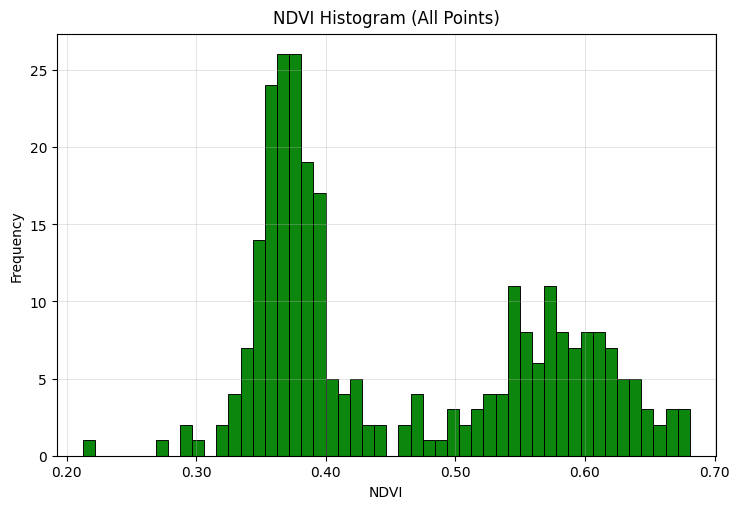

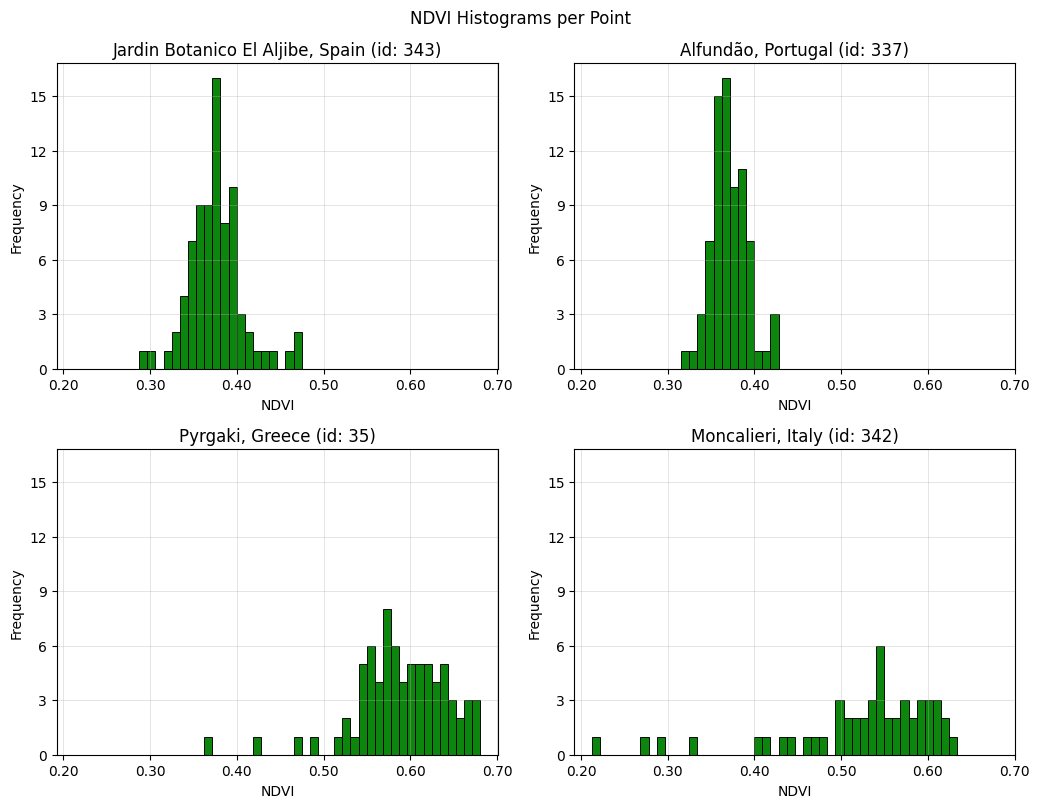

In [ ]:
'''
NDVI QA & Histogram Visualizer (NOAA-compatible unified version)
----------------------------------------------------------------
Loads a NOAA NDVI time-series CSV, performs basic QA diagnostics
and visualizes NDVI distributions as:

  (1) One overall histogram for all points combined.
  (2) Per-point histograms arranged in 2×2 subplot grids.

This script ensures consistent axis limits, titles, and color scheme
for all plots, and stores the resulting figures in a "plots" folder
for easy inspection. It is designed to mirror the behavior and
visual output of the simpler NDVI QA script.

Inputs
------
- "ndvi_noaa_timeseries.csv" (or rename to match your file)
  containing at least:
    * NDVI values
    * Point identifier column: 'id' or 'point_id'

Typical NOAA extraction columns include:
    Date, longitude, latitude, id, NDVI, ImageID, image_path, json_path

Outputs
-------
- Console QA diagnostics (min/max, counts, quantiles)
- "plots/NDVI_Histogram_all_Points.png"
- "plots/NDVI_Histograms_per_Point.png"

Author: Sotirios Loukas Kampylis, Dotsoft
'''

# === Imports ===
import os                                                 # directory and file operations
import numpy as np                                        # numerical computing and array operations
import pandas as pd                                       # data analysis and manipulation (DataFrames, CSV/Excel I/O)
import matplotlib.pyplot as plt                           # plotting and visualization library
from matplotlib.ticker import MaxNLocator, FuncFormatter  # custom axis tick control and formatting for plots

# === Manual ID → Name mapping ===
# This dictionary assigns readable location names to numeric site IDs.
# Update as necessary for your dataset.
ID_TO_NAME = {
    337: "Alfundão, Portugal",
    35:  "Pyrgaki, Greece",
    342: "Moncalieri, Italy",
    343: "Jardin Botanico El Aljibe, Spain",
}

# === Load NDVI data ===
# Specify the CSV path here. Ensure it includes NDVI values and site identifiers.
csv_path = "ndvi_noaa_timeseries.csv"
df = pd.read_csv(csv_path)

# === NDVI Cleaning ===
# Convert NDVI column to numeric.
# Invalid entries (non-numeric strings, missing values) become NaN and will be dropped.
df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")

# === Identify site ID column ===
# Priority: 'id' → 'point_id' → else fail gracefully.
if "id" in df.columns:
    id_col = "id"
elif "point_id" in df.columns:
    id_col = "point_id"
else:
    raise ValueError(f"{csv_path} must contain an identifier column 'id' or 'point_id'.")

# === Normalize site IDs ===
# Convert values like '337.0' to '337' and trim whitespace.
def normalize_id_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
    return s

df["_id_norm_str"] = normalize_id_series(df[id_col])

# Convert normalized IDs to int where possible, keeping strings otherwise.
def to_int_if_possible(x: str):
    try:
        return int(x)
    except Exception:
        return x

df["_id_norm_key"] = df["_id_norm_str"].map(to_int_if_possible)

# === NDVI Cleaning and Validation ===
ndvi = df["NDVI"].dropna()
if ndvi.empty:
    raise ValueError("No valid NDVI values found after cleaning NDVI column.")

# === QA Diagnostics ===
# Print basic descriptive statistics and range checks for NDVI.
ndvi_min, ndvi_max = ndvi.min(), ndvi.max()
print(f"NDVI Range (valid values): {ndvi_min:.3f} to {ndvi_max:.3f}")

# Count subsets for QA
below_minus1 = (ndvi < -1).sum()
above_plus1  = (ndvi > 1).sum()
negatives    = (ndvi < 0).sum()
zero_values  = (ndvi == 0).sum()
in_0_1       = ((ndvi >= 0) & (ndvi <= 1)).sum()

print("\n— Basic Counts (and wrong values) —")
print(f"In [0, 1]: {in_0_1}")
print(f"Values < -1: {below_minus1}")
print(f"Values >  1: {above_plus1}")
print(f"Values <  0: {negatives}")
print(f"Values == 0: {zero_values}")

# === Distribution summary (quantiles) ===
q = ndvi.quantile([0.01, 0.25, 0.5, 0.75, 0.99])
print("\n— Distribution Summary (quantiles) —")
print(q.to_string())

# === Interpret and flag potential anomalies ===
if below_minus1 > 0 or above_plus1 > 0:
    print("\n- Warning: Some values fall outside [-1, 1] — possible NDVI scaling error.")
elif negatives == 0 and ndvi_max <= 1:
    print("\n- Note: No negative values detected and max ≤ 1! (vegetation-heavy dataset)")
else:
    print("\n- NDVI values appear within expected physical range [-1, 1].")

# === Create output folder for plots ===
os.makedirs("plots_noaa", exist_ok=True)

# === Histogram settings (consistent across all plots) ===
x_lo = max(-1.0, ndvi_min - 0.02)
x_hi = min(1.0, ndvi_max + 0.02)
HIST_BINS = 50
bin_edges = np.linspace(ndvi_min, ndvi_max, HIST_BINS + 1)
HIST_COLOR = "green"  # vegetation color scheme

# === Global Histogram (All Points) ===
fig = plt.figure(figsize=(7.5, 5.2))
ax = plt.gca()

# Plot all NDVI values combined
ax.hist(ndvi, bins=bin_edges, edgecolor="black", linewidth=0.7, alpha=0.95, color=HIST_COLOR)

# Configure appearance
ax.set_title("NDVI Histogram (All Points)", pad=8)
ax.set_xlabel("NDVI")
ax.set_ylabel("Frequency")
ax.set_xlim(x_lo, x_hi)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
ax.grid(True, linewidth=0.6, alpha=0.4)
ax.tick_params(axis="both", which="both", labelbottom=True, labeltop=False,
               labelleft=True, labelright=False)

plt.tight_layout()

# Save to "plots/" folder
plt.savefig("plots_noaa/NDVI_Histogram_all_Points.png", dpi=150)
plt.show()

# === Per-Point Histograms (2×2 grid layout) ===
unique_ids = df.loc[df["NDVI"].notna(), "_id_norm_key"].unique()

# Iterate in batches of 4 points (2×2 layout)
for i in range(0, len(unique_ids), 4):
    batch = unique_ids[i:i+4]
    fig, axes = plt.subplots(2, 2, figsize=(10.5, 8.2), sharex=True, sharey=True)
    axes = axes.ravel()

    for ax, pid_key in zip(axes, batch):
        # Extract NDVI values for this specific ID
        ndvi_p = df.loc[(df["_id_norm_key"] == pid_key) & (df["NDVI"].notna()), "NDVI"]

        # Build title using manual mapping (if available)
        pretty = ID_TO_NAME.get(pid_key, "")
        id_str = str(pid_key)
        title = f"{pretty} (id: {id_str})" if pretty else f"id: {id_str}"
        ax.set_title(title, pad=6)

        # Plot NDVI histogram for the site
        ax.hist(ndvi_p, bins=bin_edges, edgecolor="black", linewidth=0.7,
                alpha=0.95, color=HIST_COLOR)

        # Configure per-subplot appearance
        ax.set_xlabel("NDVI")
        ax.set_ylabel("Frequency")
        ax.set_xlim(x_lo, x_hi)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
        ax.grid(True, linewidth=0.6, alpha=0.4)
        ax.tick_params(axis="both", which="both", labelbottom=True, labeltop=False,
                       labelleft=True, labelright=False)

    # Hide unused subplots if fewer than 4 IDs remain
    for ax in axes[len(batch):]:
        ax.axis("off")

    # Shared title for the entire 2×2 grid
    fig.suptitle("NDVI Histograms per Point")
    plt.tight_layout()

    # Save single combined figure (same filename for consistency)
    plt.savefig("plots_noaa/NDVI_Histograms_per_Point.png", dpi=150)
    plt.show()


### [2.7] NOAA NDVI Time-Series Analysis

This step visualizes **temporal NDVI evolution per monitoring site** using NOAA CDR (AVHRR/VIIRS) data, producing both a **global daily-mean NDVI overview** and **per-site trend plots** organized in 2×2 grids.
It runs locally on `ndvi_noaa_timeseries.csv` and applies a **manual ID→Name mapping** to label plots consistently.

---

### 1) Inputs & Cleaning — *What the script reads*

* **CSV file:** `ndvi_noaa_timeseries.csv`
  must contain at least:

  * `NDVI` — numeric vegetation index values (non-numeric entries are coerced to `NaN` and excluded),
  * `id` or `point_id` — site identifier (normalized, e.g., `337.0 → 337`),
  * and one **date-like** column among `Dates`, `Date`, or `time`.

* **Manual mapping** dictionary:

  ```python
  ID_TO_NAME = {
      337: "Alfundão, Portugal",
      35:  "Pyrgaki, Greece",
      342: "Moncalieri, Italy",
      343: "Jardin Botanico El Aljibe, Spain"
  }
  ```

  assigns readable names to site IDs for subplot titles.

* **Optional smoothing parameter:**
  `MOVING_AVG_DAYS` controls an optional moving-average window (in days)
  for smoothing NDVI curves. By default it is set to `0` (disabled).

**Rationale:**
ID normalization and explicit naming ensure each subplot is clearly labeled and directly interpretable.

---

### 2) Date Parsing — *Flexible handling of NOAA formats*

The script automatically detects and parses date columns based on their content:

* **`Dates`** → if values look like `YYYYMMDD`, parsed with `format="%Y%m%d"`;
* **`Date`** → numeric values interpreted as UNIX timestamps (seconds or milliseconds);
  otherwise parsed as ISO-formatted strings;
* **`time`** → always treated as UNIX milliseconds (typical for Earth Engine exports).

All timestamps are normalized to **daily resolution**.

**Rationale:**
NOAA NDVI exports vary in date representation — this flexibility ensures consistent, error-tolerant parsing.

---

### 3) Daily Aggregation — *Collapsing duplicates*

After cleaning:

* Invalid NDVI or unparsable date rows are removed.
* NDVI values are **aggregated per site per day** using a daily mean.
* The resulting table is sorted chronologically per site.

**Rationale:**
Aggregation prevents duplicate sampling for the same day and produces a stable daily time-series suitable for comparison.

---

### 4) Visualization — *What gets drawn*

**(a) Global Daily Mean NDVI**

* If `SHOW_GLOBAL_OVERVIEW = True`,
  computes and plots the **overall daily mean NDVI** across all sites.
* The chart includes:

  * Clear date axis (auto-scaled, concise labels),
  * NDVI range clamped to `[-1, 1]`,
  * Light gridlines and smooth blue line with circular markers.
* Output:
  `plots_noaa/NDVI_Time_Series_all_Points.png`

**(b) Per-Site NDVI Trends**

* Generates **2×2 grid figures**, each showing up to four sites.
* Subplot titles follow the naming dictionary, e.g.
  `"Pyrgaki, Greece (id: 35)"`.
* Each line uses consistent styling: blue color, markers, smoothed axes.
* Shared **y-limits** across all subplots (clamped to `[-1, 1]`).
* Automatic date axis scaling via adaptive tick locators.
* Output:
  `plots_noaa/NDVI_Time_Series_per_Point.png`
  *(only the final 2×2 grid is saved, overwriting previous batches)*

**Rationale:**
Uniform scales and grid layouts allow visual comparison between regions, making vegetation cycles and anomalies more evident.

---

### 5) Outputs & Diagnostics

**Console diagnostics**

* Total number of daily NDVI records processed,
* Number of unique sites,
* Detected date range (min → max).

**Figures saved**

* `plots_noaa/NDVI_Time_Series_all_Points.png` — global daily mean NDVI trend
* `plots_noaa/NDVI_Time_Series_per_Point.png` — final composite plot (2×2 grid of last four sites)

---

### 6) How to Interpret the Results

* **Smooth seasonal oscillations** → expected vegetation growth and senescence patterns.
* **Sharp drops/spikes** → possible cloud contamination or sensor anomalies.
* **Persistent low NDVI** → non-vegetated or winter conditions.
* **Values outside [-1, 1]** → likely upstream scaling or unit mismatch (e.g., missing ×0.0001 factor).

---

### 7) Why this step matters

Temporal NDVI visualization transforms static pixel data into **ecologically meaningful trends**.
This analysis:

* Highlights **seasonality** and **vegetation dynamics** per site,
* Reveals **data-quality issues** (gaps, clipping, scaling errors),
* Provides **comparable, publication-ready plots** across all NOAA monitoring sites.

**Bottom line:**
It converts raw NOAA NDVI time series into **interpretable trend lines**,
allowing reliable temporal monitoring and reporting of vegetation health.

[INFO] Processed daily NDVI: 281 rows across 4 points.
[INFO] Date range: 2025-06-01 → 2025-08-31


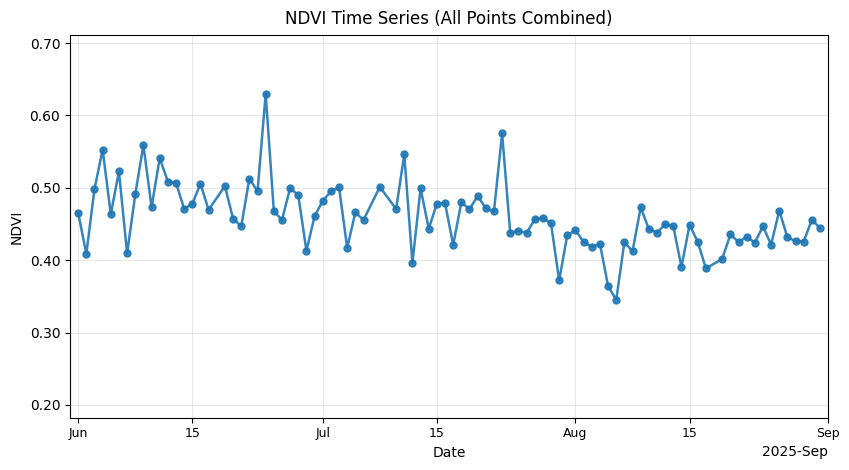

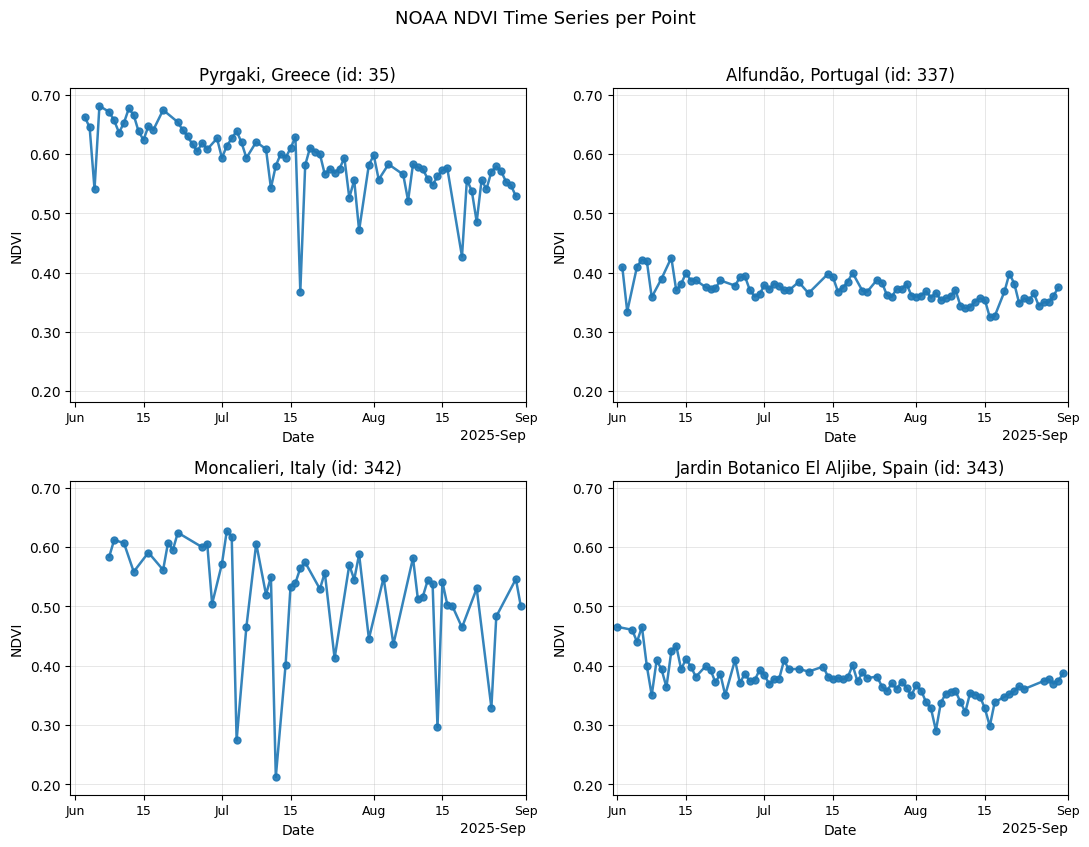

In [ ]:
"""
NOAA NDVI Time-Series Visualizer
-------------------------------------------------------------
Loads a NOAA NDVI time-series CSV and visualizes NDVI trends
over time with adaptive, readable axes and consistent scales.

What it does
------------
1. Loads a NOAA NDVI CSV (columns: NDVI, id or point_id, Dates/Date/time)
2. Parses flexible date formats (YYYYMMDD, ISO, UNIX ms)
3. Aggregates daily NDVI means per point
4. Plots:
   - Global daily mean NDVI across all points
   - Per-point NDVI time-series in 2×2 subplot grids
5. Ensures:
   - Shared Y-limits across all plots
   - Adaptive, concise date tick labels
   - Clean, publication-quality figures

Outputs
-------
Folder: plots_noaa/
    - NDVI_Time_Series_all_Points.png
    - NDVI_Time_Series_per_Point_Group_<N>.png

Author: Sotirios Loukas Kampylis, Dotsoft
"""

# === Imports ===
import os                                                           # Handle file and directory operations
import numpy as np                                                  # Numerical computations and array processing
import pandas as pd                                                 # Read and manipulate CSVs and DataFrames
import matplotlib.pyplot as plt                                     # Create plots and visualizations
from matplotlib.ticker import MaxNLocator, FuncFormatter            # Control and format plot axes
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter  # Auto-format date axes

# === Manual ID → Name mapping ===
ID_TO_NAME = {
    337: "Alfundão, Portugal",
    35:  "Pyrgaki, Greece",
    342: "Moncalieri, Italy",
    343: "Jardin Botanico El Aljibe, Spain",
}

# === Settings ===
CSV_PATH = "ndvi_noaa_timeseries.csv"   # Input file
OUT_DIR  = "plots_noaa"                 # Folder for output plots
DPI      = 150                          # Image resolution
SHOW_GLOBAL_OVERVIEW = True             # Toggle for overall daily mean plot
MOVING_AVG_DAYS = 0                     # Moving average smoothing window (0 disables)

# === Helper: normalize IDs ===
def normalize_id(s: pd.Series) -> pd.Series:
    """Normalize IDs like '337.0' → 337 and strip spaces."""
    s = s.astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
    return s.map(lambda x: int(x) if x.isdigit() else x)

# === Helper: flexible date parsing ===
def parse_dates_flex(df: pd.DataFrame) -> pd.Series:
    """Parse NOAA-style date fields ('Dates', 'Date', or 'time') with auto-format detection."""
    if "Dates" in df.columns:
        s = df["Dates"].astype(str).str.strip()
        if s.str.match(r"^\d{8}$", na=False).any():
            return pd.to_datetime(s, format="%Y%m%d", errors="coerce")
        return pd.to_datetime(s, errors="coerce")
    if "Date" in df.columns:
        s = df["Date"]
        if np.issubdtype(s.dtype, np.number):
            use_ms = pd.Series(s).gt(1e11).any()
            return pd.to_datetime(s, unit=("ms" if use_ms else "s"), errors="coerce")
        return pd.to_datetime(s.astype(str), errors="coerce")
    if "time" in df.columns:
        return pd.to_datetime(df["time"], unit="ms", errors="coerce")
    raise ValueError("No valid date column found ('Dates', 'Date', or 'time').")

# === Helper: adaptive X-axis for dates ===
def setup_date_axis(ax, x_lo, x_hi, minticks=4, maxticks=7):
    """Apply adaptive locator/formatter for clean date labels."""
    ax.set_xlim(x_lo - pd.Timedelta(days=1), x_hi + pd.Timedelta(days=1))
    locator = AutoDateLocator(minticks=minticks, maxticks=maxticks)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))
    ax.tick_params(axis="x", labelrotation=0, labelsize=9)

# === Main script ===
def main():
    # --- Load CSV ---
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV not found: {CSV_PATH}")

    df = pd.read_csv(CSV_PATH)
    df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")

    # Determine ID column
    if "id" in df.columns:
        id_col = "id"
    elif "point_id" in df.columns:
        id_col = "point_id"
    else:
        raise ValueError("CSV must contain 'id' or 'point_id'.")

    # Normalize and parse
    df["_id"] = normalize_id(df[id_col])
    df["__dt"] = parse_dates_flex(df)

    df = df.loc[df["NDVI"].notna() & df["__dt"].notna()].copy()
    if df.empty:
        raise ValueError("No valid NDVI/date entries after cleaning.")

    # Aggregate per day
    df["__date"] = df["__dt"].dt.normalize()
    daily = (
        df.groupby(["_id", "__date"], as_index=False)["NDVI"]
          .mean()
          .sort_values(["_id", "__date"])
    )

    print(f"[INFO] Processed daily NDVI: {len(daily)} rows across {daily['_id'].nunique()} points.")
    print(f"[INFO] Date range: {daily['__date'].min().date()} → {daily['__date'].max().date()}")

    # Prepare limits
    os.makedirs(OUT_DIR, exist_ok=True)
    ndvi_min, ndvi_max = daily["NDVI"].min(), daily["NDVI"].max()
    y_lo = max(-1.0, ndvi_min - 0.03)
    y_hi = min(1.0, ndvi_max + 0.03)
    x_lo, x_hi = daily["__date"].min(), daily["__date"].max()

    # --- (1) Global NDVI time series ---
    if SHOW_GLOBAL_OVERVIEW:
        global_mean = (
            daily.groupby("__date", as_index=False)["NDVI"]
                 .mean()
                 .sort_values("__date")
        )
        fig, ax = plt.subplots(figsize=(8.6, 4.8))
        ax.plot(global_mean["__date"], global_mean["NDVI"],
                marker="o", markersize=5, linewidth=1.8,
                color="tab:blue", alpha=0.9)

        ax.set_title("NDVI Time Series (All Points Combined)", pad=8)
        ax.set_xlabel("Date")
        ax.set_ylabel("NDVI")
        ax.set_ylim(y_lo, y_hi)
        ax.grid(True, alpha=0.35, linewidth=0.6)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
        setup_date_axis(ax, x_lo, x_hi)

        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "NDVI_Time_Series_all_Points.png"), dpi=DPI)
        plt.show()

    # --- (2) Per-point NDVI time series (2×2 grid) ---
    unique_ids = daily["_id"].unique()

    for i in range(0, len(unique_ids), 4):
        batch = unique_ids[i:i + 4]
        fig, axes = plt.subplots(2, 2, figsize=(11.0, 8.6))
        axes = axes.ravel()

        for ax, pid in zip(axes, batch):
            sub = daily.loc[daily["_id"] == pid, ["__date", "NDVI"]].sort_values("__date")
            name = ID_TO_NAME.get(pid)
            title = f"{name} (id: {pid})" if name else f"id: {pid}"
            ax.set_title(title, pad=6)

            ax.plot(sub["__date"], sub["NDVI"],
                    marker="o", markersize=5, linewidth=1.8,
                    color="tab:blue", alpha=0.9)

            ax.set_ylim(y_lo, y_hi)
            ax.set_xlabel("Date")
            ax.set_ylabel("NDVI")
            ax.grid(True, alpha=0.35, linewidth=0.6)
            ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
            ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
            setup_date_axis(ax, x_lo, x_hi)

        for ax in axes[len(batch):]:
            ax.axis("off")

        fig.suptitle("NOAA NDVI Time Series per Point", fontsize=13)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.savefig(os.path.join(OUT_DIR, f"NDVI_Time_Series_per_Point.png"), dpi=DPI)
        plt.show()

if __name__ == "__main__":
    main()


### [2.8] NOAA Vegetation-Only Histograms (Global + Per-Point)

**Note**: <u>Original idea from *Valeria Gentile*</u>

This step reproduces the **Sentinel-2 vegetation-only filtering logic** for **NOAA NDVI (AVHRR/VIIRS)** datasets, applying a **dynamic threshold rule** to isolate vegetation-dominant pixels and visualize their distributions both globally and per site.
It provides consistent, publication-ready histograms that emphasize vegetation signal strength and homogeneity across monitoring locations.

---

### 1) Inputs & Cleaning — *What the script reads*

* **CSV file:** `ndvi_noaa_timeseries.csv` containing columns such as
  `NDVI, id (or point_id), longitude, latitude, Date`.
* The script:

  * Converts `NDVI` to numeric and drops invalid rows (`NaN` or non-numeric).
  * Detects the site identifier column (`id` preferred, otherwise `point_id`).
  * Normalizes IDs (e.g., `337.0 → 337`) for stable per-site grouping.
  * Optionally maps IDs to readable names via:

    ```python
    ID_TO_NAME = {
        337: "Alfundão, Portugal",
        35:  "Pyrgaki, Greece",
        342: "Moncalieri, Italy",
        343: "Jardin Botanico El Aljibe, Spain"
    }
    ```

**Rationale:**
NOAA exports often vary in column naming or ID formatting; normalization and name mapping ensure consistent site references and figure titles.

---

### 2) Vegetation Filtering — *Dynamic threshold logic*

To separate vegetation signals from background noise, the script computes **adaptive thresholds** identical to the Sentinel-2 approach:

* **Global threshold**
  $$
  T = \frac{\max(\text{NDVI}) - \min(\text{NDVI})}{2}
  $$
  All NDVI values above this global T are treated as vegetation pixels.

* **Per-point thresholds**
  $$
  T_i = \frac{\max_i(\text{NDVI}) - \min_i(\text{NDVI})}{2}
  $$
  for each i.
  Only values with **NDVI > Tᵢ** are retained.

**Rationale:**
This adaptive thresholding removes low-NDVI background (soil, water, shadow), focusing the histograms on vegetation-dominated observations.

---

### 3) Global Vegetation-Only Histogram

* Computes global statistics:

  * NDVI **min → max**,
  * **Dynamic threshold (T)**,
  * Vegetation-only **min, max, mean, count**.
* Plots a histogram of vegetation-only NDVI values:

  * **Green bars** — valid vegetation pixels,
  * **Red dashed line** — vegetation mean value.
* Axis limits are clamped to **[-1, 1]** for physical consistency.
* Saves the figure as:

  ```
  plots_noaa/NDVI_Histogram_Vegetation_Only_all_Points.png
  ```

**Console Output Example:**

```
[GLOBAL] Vegetation-only NDVI statistics (NOAA)
NDVI range: -0.25 → 0.89
Dynamic global threshold: 0.57
Mean NDVI: 0.72
Total vegetation pixels: 13420
```

---

### 4) Per-Point Vegetation-Only Histograms — *2×2 grid layout*

For each site:

* Calculates the per-site threshold (Tᵢ),
  filters NDVIᵢ > Tᵢ,
  and reports per-site vegetation stats (range, Tᵢ, mean, pixel count).
* Visualizes histograms in **2×2 subplot grids**, with:

  * **Titles:** `"Site Name (id: X)"` (or `id: X` if unnamed),
  * **Green bars** (NDVI distribution),
  * **Red dashed line** (mean NDVIᵢ),
  * **Shared x-limits** for comparability across panels.
* Unused subplots are hidden automatically.

**Output filename:**

```
plots_noaa/NDVI_Histograms_Vegetation_Only_per_Point.png
```

**Console Example:**

```
[POINT id=342] Vegetation-only NDVI statistics (NOAA)
Range: 0.02 → 0.85
Dynamic threshold_i: 0.42
Mean NDVI (veg-only): 0.71
Total vegetation pixels: 389
```

---

### 5) Outputs & Diagnostics

**Console diagnostics**

* Prints both **global** and **per-point** vegetation statistics,
  including thresholds, means, and pixel counts.

**Saved figures**

1. `NDVI_Histogram_Vegetation_Only_all_Points.png` — Global vegetation-only NDVI distribution.
2. `NDVI_Histograms_Vegetation_Only_per_Point.png` — Per-site vegetation-only histograms.

---

### 6) Customization Cheatsheet

* **Histogram bins:** change `BINS = 40` for finer/coarser resolution.
* **NDVI range:** lock `x_lo/x_hi` to `[-1, 1]` for consistent physical bounds.
* **Batch size:** adjust `range(0, len(pids), 4)` to display more sites per page.
* **Site names:** update the `ID_TO_NAME` dictionary for custom labels.
* **Export folder:** modify `OUT_DIR` to redirect output images.

---

### 7) Interpretation & Importance

Vegetation-only histograms provide a **structural summary** of NDVI patterns across sites:

* **Higher mean NDVI** → dense or healthy vegetation.
* **Wider spread** → mixed land cover or temporal variability.
* **Empty histograms** → no valid vegetation pixels (e.g., mostly non-vegetated sites).

This filtering and visualization step ensures that NOAA NDVI distributions are **directly comparable to Sentinel-2 results**, highlighting genuine vegetation signals while suppressing background noise.

**In essence:**
It converts raw NOAA NDVI values into **clean, vegetation-focused statistical summaries**, enhancing ecological interpretability and inter-sensor consistency.

[GLOBAL] Vegetation-only NDVI statistics (NOAA)
NDVI range: 0.212 → 0.681
Dynamic global threshold: 0.234
Min NDVI: 0.274
Max NDVI: 0.681
Mean NDVI: 0.459
Total vegetation pixels: 280


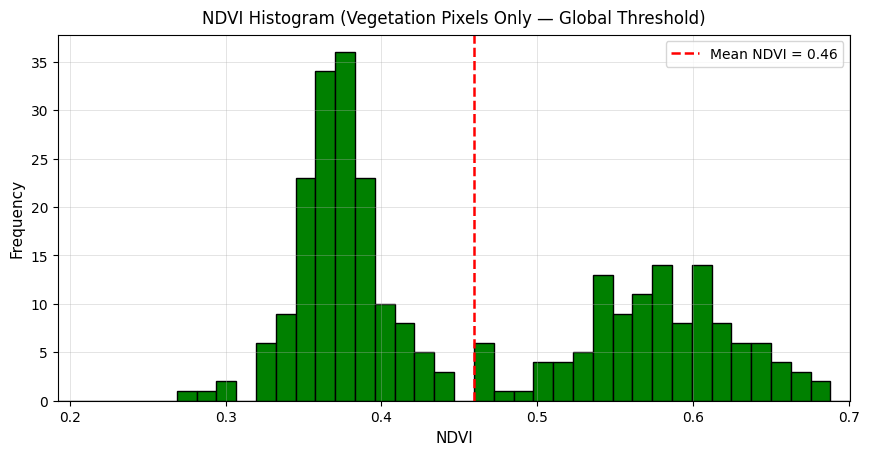

----------------------------------------------------
[POINT id=343] Vegetation-only NDVI statistics (NOAA)
----------------------------------------------------
Range: 0.291 → 0.465
Dynamic threshold_i: 0.087
Mean NDVI (veg-only): 0.376
Total vegetation pixels: 79
----------------------------------------------------
[POINT id=337] Vegetation-only NDVI statistics (NOAA)
----------------------------------------------------
Range: 0.325 → 0.425
Dynamic threshold_i: 0.050
Mean NDVI (veg-only): 0.371
Total vegetation pixels: 76
----------------------------------------------------
[POINT id=35] Vegetation-only NDVI statistics (NOAA)
----------------------------------------------------
Range: 0.368 → 0.681
Dynamic threshold_i: 0.156
Mean NDVI (veg-only): 0.589
Total vegetation pixels: 76
----------------------------------------------------
[POINT id=342] Vegetation-only NDVI statistics (NOAA)
----------------------------------------------------
Range: 0.212 → 0.627
Dynamic threshold_i: 0.208
M

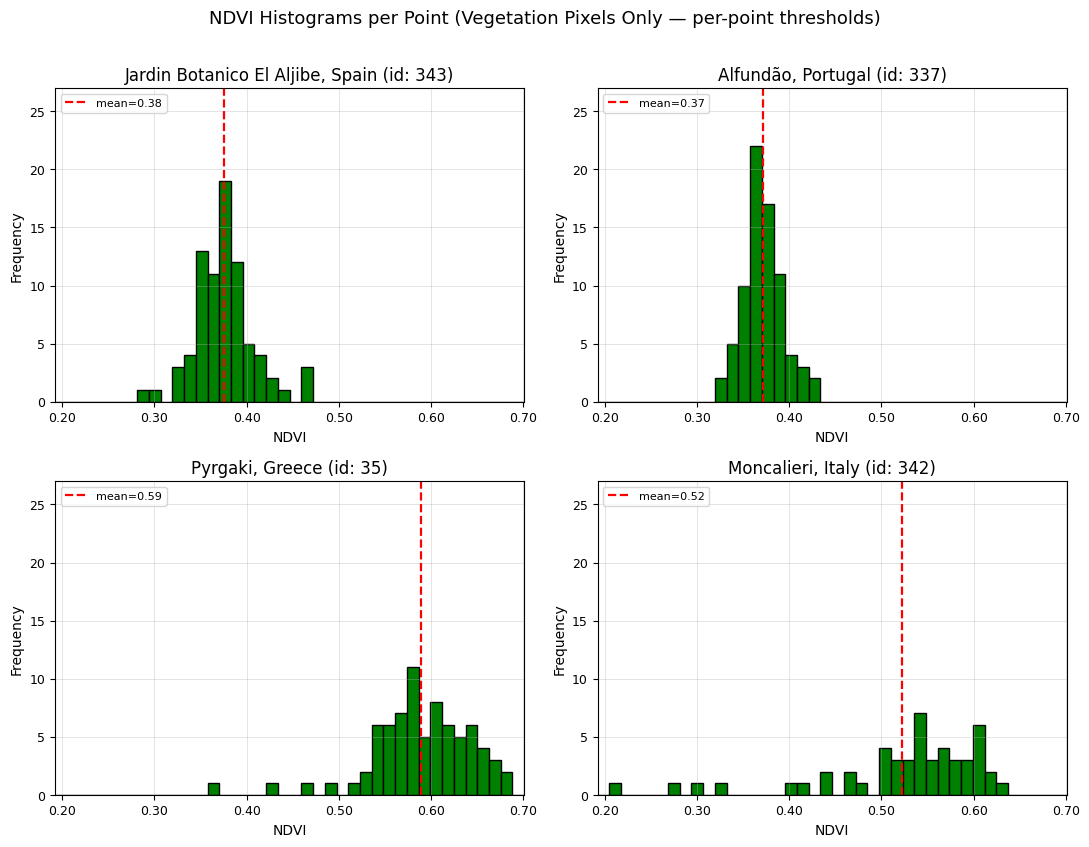

In [ ]:
"""
NOAA NDVI Vegetation-Only Histograms (GLOBAL + PER-POINT)
=========================================================

This script replicates the Sentinel-2 vegetation-only histogram logic
for NOAA NDVI datasets, ensuring identical processing, visual style,
and output naming conventions.

What it does
------------
1. Loads a NOAA NDVI time-series CSV (with NDVI and point IDs).
2. Computes vegetation-only subsets using dynamic per-point thresholds.
3. Generates:
   - A global histogram (vegetation pixels only, global threshold)
   - Per-point histograms (2×2 grid layout) matching Sentinel-2 styling.
4. Prints descriptive statistics for both global and per-point subsets.

Outputs
-------
Folder: plots_noaa/
    - NDVI_Histogram_Vegetation_Only_all_Points.png
    - NDVI_Histograms_Vegetation_Only_per_Point.png

Author
------
Sotirios Loukas Kampylis, Dotsoft
"""

# === Imports ===
import numpy as np                                        # Numerical operations: min/max, histograms, thresholds
import pandas as pd                                       # DataFrame handling: load CSV, clean NDVI, group by ID
import matplotlib.pyplot as plt                           # Plotting: draw histograms, configure figures, grids
from matplotlib.ticker import MaxNLocator, FuncFormatter  # Axis formatting utilities for clean tick labels
import os                                                 # Filesystem operations: folder creation and file saving

# === Manual mapping: ID → human-readable names ===
ID_TO_NAME = {
    337: "Alfundão, Portugal",
    35:  "Pyrgaki, Greece",
    342: "Moncalieri, Italy",
    343: "Jardin Botanico El Aljibe, Spain",
}

# === Settings ===
CSV_PATH = "ndvi_noaa_timeseries.csv"  # NOAA NDVI CSV input
OUT_DIR  = "plots_noaa"                # Output folder for all figures
BINS     = 40                          # Histogram resolution
DPI      = 150                         # Figure export quality
os.makedirs(OUT_DIR, exist_ok=True)

# ============================================================
# === Load and prepare data ==================================
# ============================================================
df = pd.read_csv(CSV_PATH)
df["NDVI"] = pd.to_numeric(df["NDVI"], errors="coerce")
df = df.dropna(subset=["NDVI"]).copy()

if df.empty:
    raise ValueError("No valid NDVI values found after cleaning!")

# Identify ID column (same as Sentinel-2 logic)
if "id" in df.columns:
    id_col = "id"
elif "point_id" in df.columns:
    id_col = "point_id"
else:
    raise ValueError("CSV must contain 'id' or 'point_id' column.")

# Normalize IDs: 337.0 → 337, strings remain intact
def normalize_id(x):
    try:
        return int(x)
    except Exception:
        return str(x).strip()

df["_pid"] = df[id_col].map(normalize_id)

# ============================================================
# === GLOBAL histogram (vegetation-only, dynamic threshold) ===
# ============================================================
ndvi_min, ndvi_max = df["NDVI"].min(), df["NDVI"].max()
threshold = (ndvi_max - ndvi_min) / 2.0  # identical rule as Sentinel-2

veg_global = df.loc[df["NDVI"] >= threshold, "NDVI"]

g_min, g_max, g_mean = veg_global.min(), veg_global.max(), veg_global.mean()
print("====================================================")
print("[GLOBAL] Vegetation-only NDVI statistics (NOAA)")
print("====================================================")
print(f"NDVI range: {ndvi_min:.3f} → {ndvi_max:.3f}")
print(f"Dynamic global threshold: {threshold:.3f}")
print(f"Min NDVI: {g_min:.3f}")
print(f"Max NDVI: {g_max:.3f}")
print(f"Mean NDVI: {g_mean:.3f}")
print(f"Total vegetation pixels: {len(veg_global)}")

# Consistent axis limits for all histograms
x_lo = max(-1.0, ndvi_min - 0.02)
x_hi = min(1.0, ndvi_max + 0.02)
bin_edges = np.linspace(x_lo, x_hi, BINS + 1)

# --- Plot global histogram ---
fig, ax = plt.subplots(figsize=(8.8, 4.8))
ax.hist(veg_global, bins=bin_edges, color="green", edgecolor="black")
if not veg_global.empty:
    ax.axvline(g_mean, color="red", linestyle="--", linewidth=1.8, label=f"Mean NDVI = {g_mean:.2f}")

ax.set_title("NDVI Histogram (Vegetation Pixels Only — Global Threshold)", pad=8)
ax.set_xlabel("NDVI", fontsize=11)
ax.set_ylabel("Frequency", fontsize=11)
ax.set_xlim(x_lo, x_hi)
ax.grid(True, alpha=0.4, linewidth=0.6)
ax.tick_params(axis="both", labelsize=10)
ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(OUT_DIR, "NDVI_Histogram_Vegetation_Only_all_Points.png"), dpi=DPI)
plt.show()

# ============================================================
# === PER-POINT histograms (2×2 grid, vegetation-only) ========
# ============================================================
# Determine shared Y-axis limit (identical normalization to Sentinel-2)
y_max = 0
for pid in df["_pid"].unique():
    vals = df.loc[df["_pid"] == pid, "NDVI"].to_numpy()
    if len(vals) == 0:
        continue
    pmin, pmax = vals.min(), vals.max()
    thr_i = (pmax - pmin) / 2.0
    veg_i = vals[vals >= thr_i]
    counts, _ = np.histogram(veg_i, bins=bin_edges)
    if counts.size > 0:
        y_max = max(y_max, counts.max())

y_hi = int(np.ceil(y_max * 1.2)) if y_max > 0 else 1

# Generate per-point histograms (identical layout as Sentinel-2 version)
pids = df["_pid"].unique()
for i in range(0, len(pids), 4):
    group = pids[i:i + 4]
    fig, axes = plt.subplots(2, 2, figsize=(11.0, 8.6), sharex=False, sharey=False)
    axes = axes.ravel()

    for ax, pid in zip(axes, group):
        vals = df.loc[df["_pid"] == pid, "NDVI"].to_numpy()
        if len(vals) == 0:
            ax.axis("off")
            continue

        pmin, pmax = vals.min(), vals.max()
        thr_i = (pmax - pmin) / 2.0
        veg_i = vals[vals >= thr_i]
        vmean = veg_i.mean() if len(veg_i) > 0 else np.nan

        # Print identical stats style to Sentinel-2
        print("----------------------------------------------------")
        print(f"[POINT id={pid}] Vegetation-only NDVI statistics (NOAA)")
        print("----------------------------------------------------")
        print(f"Range: {pmin:.3f} → {pmax:.3f}")
        print(f"Dynamic threshold_i: {thr_i:.3f}")
        print(f"Mean NDVI (veg-only): {vmean:.3f}")
        print(f"Total vegetation pixels: {len(veg_i)}")

        # Plot histogram
        title = f"{ID_TO_NAME.get(pid, 'id: '+str(pid))} (id: {pid})"
        ax.set_title(title, pad=6)
        ax.hist(veg_i, bins=bin_edges, color="green", edgecolor="black")

        if not np.isnan(vmean):
            ax.axvline(vmean, color="red", linestyle="--", linewidth=1.6, label=f"mean={vmean:.2f}")

        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(0, y_hi)
        ax.set_xlabel("NDVI", fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)
        ax.tick_params(axis="both", labelsize=9)
        ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax.grid(True, alpha=0.4, linewidth=0.6)
        ax.legend(fontsize=8, loc="upper left")

    for ax in axes[len(group):]:
        ax.axis("off")

    fig.suptitle("NDVI Histograms per Point (Vegetation Pixels Only — per-point thresholds)", fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(os.path.join(OUT_DIR, "NDVI_Histograms_Vegetation_Only_per_Point.png"), dpi=DPI)
    plt.show()


### [2.9] Download NOAA NDVI Results from Colab (Zip & Save)

This step compresses all **NOAA NDVI outputs** into a single `.zip` file and triggers an automatic **download dialog** from Google Colab.

---

### 1) What it includes / excludes

**Included**

* **Folders:**
  `merged_metadata_noaa/`, `ndvi_noaa_output/`, `raw_metadata_noaa/`, `plots_noaa/`

* **Files:**
  `ndvi_noaa_timeseries.csv`,
  `ndvi_noaa_daily_means_by_id.csv`,
  `ndvi_noaa_stats_by_id.csv`,
  `noaa_merged_validation_report.csv`,
  `noaa_merged_validation_summary.json`,
  `points.csv`

* **Figures:**
  Any `.png` whose filename contains “NOAA” or “*noaa*”.

**Excluded**

* `sample_data/` *(entire folder)*
* Hidden/system files (e.g., `.ipynb_checkpoints/`, `.git/`)
* Sentinel-2 outputs (`merged_metadata/`, `ndvi_output/`, `raw_metadata/`, `plots/`)
* Existing ZIP archives (including `ndvi_results_sentinel_2_only.zip`)
* The new archive itself

**Why:** Keeps the export clean and focused only on NOAA deliverables.

---

### 2) How it works — *Zip & Download*

* **ZIP creation:**
  Uses Colab’s underlying `zip` utility in quiet recursive mode to gather only NOAA-specific data folders, CSVs, and figures.

* **Exclusions:**
  Hidden/system files, Sentinel-2 data, and any pre-existing ZIPs are skipped automatically.

* **Download trigger:**
  Calls `files.download()` to open Colab’s browser prompt, allowing you to save the `.zip` locally with one click.

---

### 3) Output

* **File:** `ndvi_results_noaa_only.zip`
* **Contents:** all NOAA analysis results and plots, preserving folder structure exactly as in the Colab workspace
* **Purpose:** lightweight, shareable archive containing every NOAA NDVI dataset, figure, and validation report for backup, post-processing, or publication.

In [ ]:
"""
NOAA NDVI Results Archiver (Complementary ZIP Export for Colab)
===============================================================

This utility script packages only the NOAA NDVI analysis results
into a single ZIP file, ready for download from Google Colab.

It includes:
- NOAA output folders (merged_metadata_noaa, ndvi_noaa_output, raw_metadata_noaa, plots_noaa)
- Core NOAA tables (ndvi_noaa_timeseries.csv, ndvi_noaa_daily_means_by_id.csv,
  ndvi_noaa_stats_by_id.csv, noaa_merged_validation_report.csv,
  noaa_merged_validation_summary.json)
- Shared file (points.csv)
- All NOAA-related figures (any PNG containing "NOAA" or "_noaa_")

It excludes:
- Sentinel-2 results and folders (merged_metadata, ndvi_output, raw_metadata, plots)
- Hidden/system files
- sample_data/
- Any ZIP archives (including ndvi_results_sentinel_2_only.zip)
- The new archive itself

Result:
Creates → ndvi_results_noaa_only.zip
and automatically triggers download inside the Colab environment.

Author: Sotirios Loukas Kampylis, Dotsoft
"""

import subprocess, os, glob      # subprocess: run shell commands (like zip), os: check files/folders, glob: match file patterns
from google.colab import files   # provides upload/download utilities in Google Colab environment

# Items to include (NOAA-only)
targets = [
    'merged_metadata_noaa',
    'ndvi_noaa_output',
    'raw_metadata_noaa',
    'plots_noaa',                               # include NOAA-specific figures folder
    'ndvi_noaa_timeseries.csv',
    'ndvi_noaa_daily_means_by_id.csv',
    'ndvi_noaa_stats_by_id.csv',
    'noaa_merged_validation_report.csv',
    'noaa_merged_validation_summary.json',
    'points.csv',                               # shared file between Sentinel-2 and NOAA
]

# Add all NOAA figure PNGs that match "NOAA" or "_noaa_" patterns
noaa_pngs = glob.glob("NOAA_*.png") + glob.glob("*_NOAA_*.png") + glob.glob("*_noaa_*.png")
targets += sorted(set(noaa_pngs))               # append only unique figure paths

# Keep only existing items (avoid zip errors)
targets = [t for t in targets if os.path.exists(t)]
if not targets:
    raise SystemExit("No matching NOAA files/folders found.")

# Define output ZIP name
zip_name = 'ndvi_results_noaa_only.zip'

# Zip command (quiet mode) — exclude hidden files, sample_data, Sentinel-2 folders, and any zips
cmd = [
    'zip', '-r', '-q', zip_name
] + targets + [
    '-x', '*/.*', '.*',                       # exclude hidden/system files
    'sample_data/*', 'sample_data/**',        # exclude sample data folder
    'merged_metadata/*', 'merged_metadata/**',# exclude Sentinel-2 data
    'ndvi_output/*', 'ndvi_output/**',
    'raw_metadata/*', 'raw_metadata/**',
    'plots/*', 'plots/**',                    # exclude Sentinel-2 plots
    'ndvi_results_sentinel_2_only.zip',       # exclude existing Sentinel-2 ZIP
    '*.zip',                                  # exclude any other ZIPs
    zip_name                                 # exclude the output ZIP itself
]

# Run the zip command
subprocess.run(cmd, check=True)

# Automatically download the created archive
files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>